In [ ]:
### test vivit using video data

In [102]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import torch

np.random.seed(0)

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

print(video.shape)

(32, 360, 640, 3)


In [122]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")


Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params: ,} || all params: {all_param: ,} || trainable%: {100 * trainable_params / all_param}"
    )

print(model.config)
print_trainable_parameters(model)
# image_processor

VivitConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vivit-b-16x2-kinetics400",
  "architectures": [
    "ViViTForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "L

In [8]:
model.config.hidden_size

768

In [4]:
video.shape

(32, 360, 640, 3)

In [ ]:
# transformers-cli convert --model_type=vivit \
#                          --tf_checkpoint=./vivit/L_K699_checkpoint \
#                          --config=./vivit/L_K699_config.json \
#                          --pytorch_dump_output=./vivit/L_K699/pytorch_model.bin
# image_processor = VivitImageProcessor.from_pretrained("./vivit/checkpoint")
# model = VivitModel.from_pretrained("./vivit/checkpoint")

In [130]:
import torch
inputs = image_processor(list(video), return_tensors="pt")
print(inputs['pixel_values'].shape)

processed_video = np.array(inputs['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_video.shape

torch.Size([1, 32, 3, 224, 224])


(32, 224, 224, 3)

In [5]:
import av
import cv2  # For visualization

# ... (your existing code for reading the video) ...

# Display the original video using OpenCV
for frame in video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file

# Display the original video using OpenCV
for frame in processed_video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file



ModuleNotFoundError: No module named 'cv2'

In [131]:

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(list(last_hidden_states.shape))
cls_representation = last_hidden_states[:, 0, :]
print(cls_representation.shape)

[1, 3137, 768]
torch.Size([1, 768])


In [ ]:
###  test using MD data

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math

def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

In [41]:
import mdtraj as md
import numpy as np

# Load trajectory and topology
traj = md.load('./vivit/1k5n_A_analysis/1k5n_A_R1.xtc', top='./vivit/1k5n_A_analysis/1k5n_A.pdb')

# Compute contact maps for each frame using a distance cutoff (e.g., 0.45 nm)
cutoff = 7  # in nanometers
contact_maps = []
for frame in traj:
    # compute pairwise distances
    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA'))
    # generate contact map: 1 if distance < cutoff, else 0
    # contact_map = (distances < cutoff).astype(int)
    # contact_maps.append(contact_map)
    contact_maps.append(distances)

# Now contact_maps is a list of contact maps, one per frame.

In [42]:
# np.sum(contact_maps[1]>1)
print(len(contact_maps))
print(contact_maps[1].shape)

1001
(1, 37950)


In [43]:
# a=vector_to_contact_map(contact_maps[1].reshape(-1))
# np.expand_dims(a, axis=-1).shape

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

print(contact_maps[1].shape)

map_list=[]
for map in contact_maps:
    contact_map = vector_to_contact_map(map.reshape(-1))
    contact_map = np.expand_dims(contact_map, axis=-1)
    normalized_map = normalize_contact_map(contact_map)
    three_channel_map = np.repeat(normalized_map, 3, axis=-1) 
    map_list.append(three_channel_map)
    if len(map_list) == 32:
        break

print(map_list[0].shape)

input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False)
print(input_map['pixel_values'].shape)

(1, 37950)
(276, 276, 3)
torch.Size([1, 32, 3, 224, 224])


(276, 276)


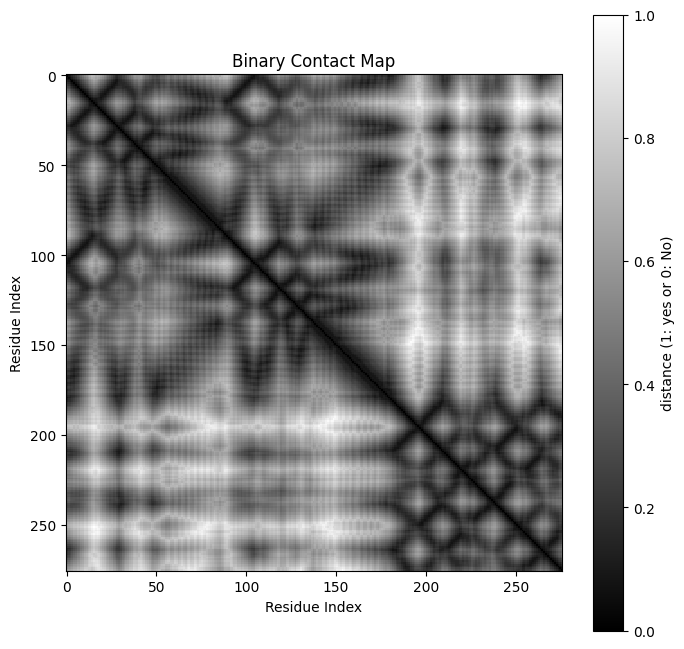

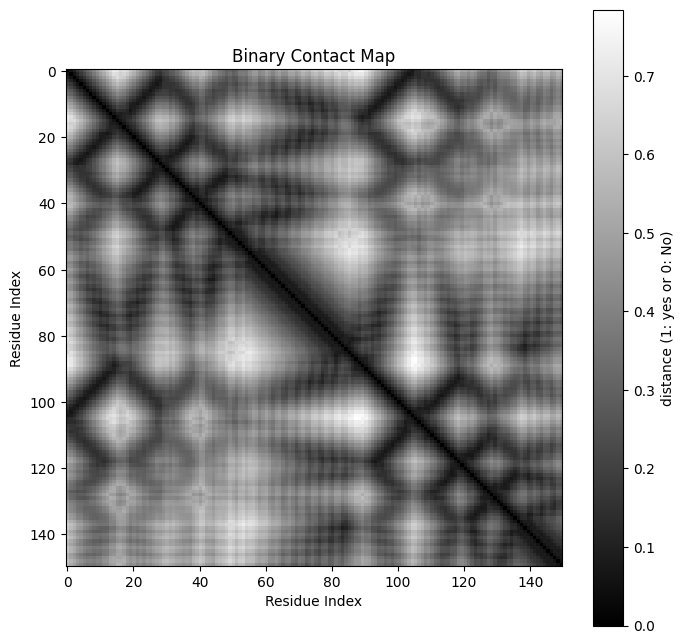

In [50]:
# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
# contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))
contact_map = map_list[0][:,:,0]
print(contact_map.shape)
# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

contact_map = map_list[0][:150,:150,0]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

(276, 276, 3)
torch.Size([1, 32, 3, 224, 224])


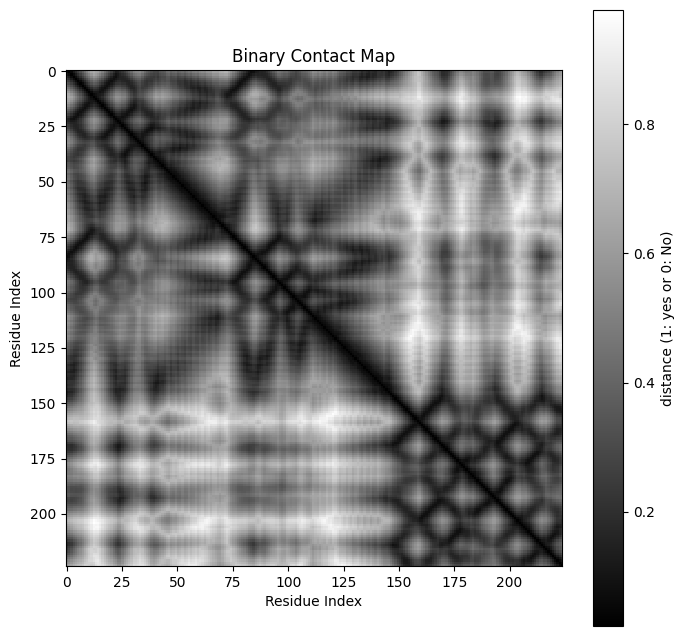

(150, 150, 3)
torch.Size([1, 32, 3, 224, 224])


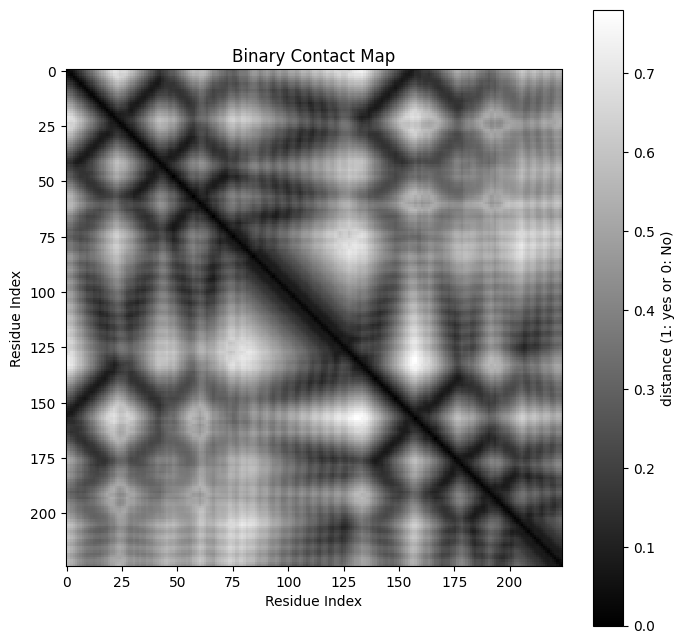

In [61]:

print(map_list[0].shape)
b = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=224, do_center_crop=False)
print(b['pixel_values'].shape)
contact_map = b['pixel_values'][0, 0, 0, :, :]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()


map_list_short = [i[:150, :150, :] for i in map_list]
print(map_list_short[0].shape)
b = image_processor(map_list_short, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=224, do_center_crop=False)
print(b['pixel_values'].shape)
contact_map = b['pixel_values'][0, 0, 0, :, :]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

In [45]:
a=map_list[0][:100,:100,:]
print(a.shape)
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224, 224])
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False)
back=np.zeros((224,224,3))
back[:100,:100,:]=a
b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False, do_center_crop=False)
# b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224,224], do_center_crop=False)
c=b['pixel_values'][0,0,0]
print(c.shape)
d=a[:,:,0]
print(d.shape)
print(c)
print(d)

(100, 100, 3)
torch.Size([224, 224])
(100, 100)
tensor([[0.0000, 0.0614, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0614, 0.0000, 0.0601,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0601, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
[[0.         0.06137533 0.09999483 ... 0.3588073  0.32841434 0.27128245]
 [0.06137533 0.         0.06005734 ... 0.30704371 0.27689615 0.22155744]
 [0.09999483 0.06005734 0.         ... 0.25943856 0.2296494  0.17345286]
 ...
 [0.3588073  0.30704371 0.25943856 ... 0.         0.06111426 0.10914952]
 [0.32841434 0.27689615 0.2296494  ... 0.06111426 0.         0.05978399]
 [0.27128245 0.22155744 0.17345286 ... 0.10914952 0.05978399 0.        ]]


In [172]:
b['pixel_values'].shape

torch.Size([1, 1, 3, 224, 224])

In [161]:
res['attentions'][0].shape

torch.Size([1, 12, 3137, 3137])

In [59]:
print(input_map['pixel_values'].shape)

torch.Size([1, 32, 3, 224, 224])


In [198]:
# input_map.keys()
a = torch.concatenate((input_map['pixel_values'], input_map['pixel_values']), dim=0)
# # print(map['pixel_values'].shape)
a.shape

outputs=model(a)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
print(last_hidden_states[0,0:5,0:5])
print(last_hidden_states[1,0:5,0:5])

torch.Size([2, 3137, 768])
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)


In [17]:
map_list[0].shape

(276, 276, 3)

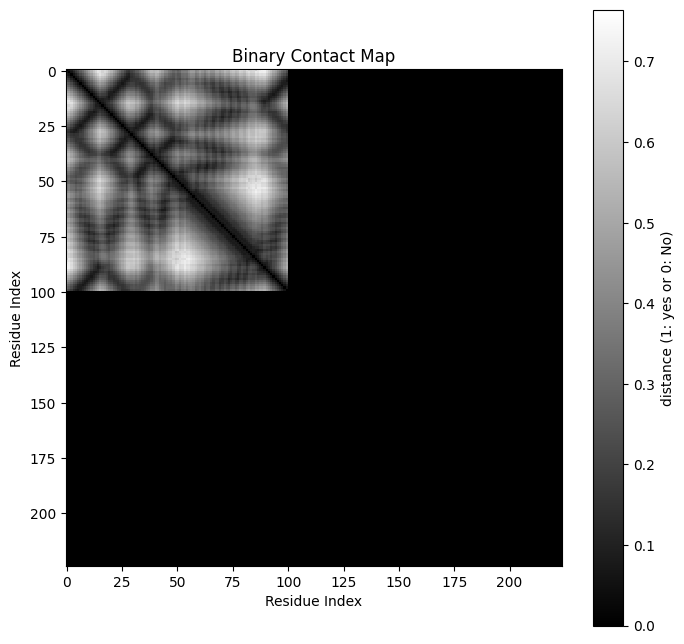

In [46]:


# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
# contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))
contact_map = map_list[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(c, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

In [ ]:
from Bio.PDB import PDBParser, PPBuilder

# Replace with your PDB file path
pdb_file = "./data/MD/dev_data/r1/1k5n_A.pdb"

# Create a PDB parser object
parser = PDBParser(QUIET=True)

# Parse the structure from the PDB file
structure = parser.get_structure("protein", pdb_file)

# Initialize the polypeptide builder
ppb = PPBuilder()

# Extract sequences from all chains in the structure
for model in structure:
    for chain in model:
        # Build polypeptides for the chain (could be more than one segment)
        polypeptides = ppb.build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides):
            sequence = poly.get_sequence()
            print(f"Chain {chain.id} (segment {poly_index}): {sequence}")

In [ ]:
### test vivit model

In [ ]:
from transformers import VivitModel
import torch
# model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="sdpa", torch_dtype=torch.float16)
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="")

OSError: google/vivit-b-16x2-kinetics600 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [36]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
print(map_list[0].shape)
input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**input_map)

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(276, 276, 3)


In [38]:
print(result.last_hidden_state.shape)

torch.Size([1, 3137, 768])


In [41]:
small_map_list=[map[0:100, 0:100, :] for map in map_list]
print(small_map_list[0].shape)
print(len(small_map_list))
small_input_map = image_processor(small_map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**small_input_map)

(100, 100, 3)
32


torch.Size([1, 32, 3, 224, 224])


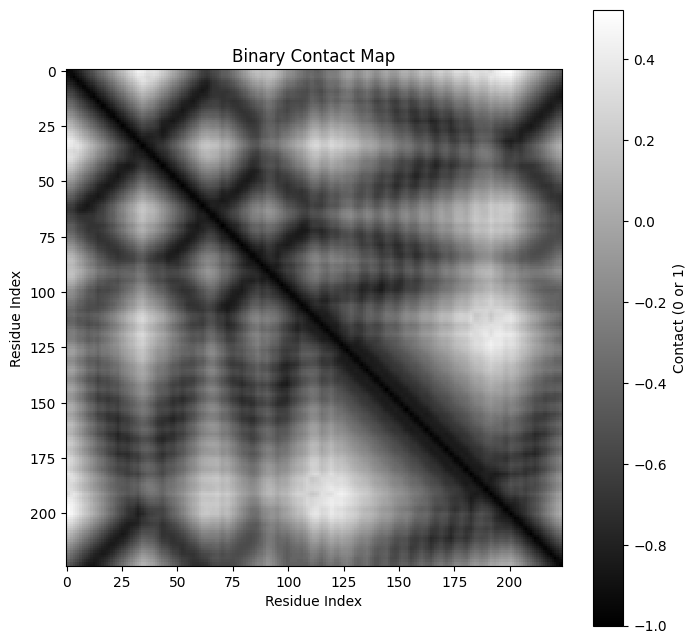

In [44]:
print(small_input_map['pixel_values'].shape)
processed_map = np.array(small_input_map['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_map.shape

contact_map = processed_map[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="Contact (0 or 1)")
plt.show()

In [ ]:
import torch
import os
import mdtraj as md
import numpy as np
import math
from Bio.PDB import PDBParser, PPBuilder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from transformers import VivitImageProcessor

class ProteinMDDataset(Dataset):
    def __init__(self, samples, configs,mode="train"):
        self.original_samples = samples
    def __len__(self):
           return len(self.original_samples)
    def __getitem__(self, idx):
        pid, seq, traj = self.original_samples[idx]
        return pid, seq, traj


def custom_collate(batch):
    pid, seq, trajs = zip(*batch)
    # Remove the extra dimension from each contact sample
    traj_list = [traj.squeeze(0) for traj in trajs]
    # Now each traj has shape [32, 3, 224, 224]
    # Stack them along a new first dimension (batch dimension)
    traj_batch = torch.stack(traj_list, dim=0)
    batched_data = {'pid': pid, 'seq': seq, 'traj': traj_batch}
    # return pid, seq, contacts
    return batched_data

def prepare_dataloaders(configs):
    samples = prepare_samples(configs.train_settings.Atlas_data_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    total_samples = len(samples)
    val_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    train_size = total_samples - val_size - test_size
    train_samples, val_samples, test_samples = random_split(samples, [train_size, val_size, test_size])

    samples_hard = prepare_samples(configs.train_settings.Atlas_test_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    hard_num = len(samples_hard)
    val_size = int(hard_num * 0.5)
    test_size = hard_num - val_size
    val_hard, test_hard = random_split(samples_hard, [val_size, test_size])
    val_samples = val_samples + val_hard
    test_samples = test_samples + test_hard


    print(f"train samples: {len(train_samples)}, val samples: {len(val_samples)}, test samples: {len(test_samples)}")
    # Create DataLoader for each split
    train_dataset = ProteinMDDataset(train_samples, configs=configs, mode="train")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=True,
        collate_fn=custom_collate,
        drop_last=False
    )

    val_dataset = ProteinMDDataset(val_samples, configs=configs, mode="val")
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    test_dataset = ProteinMDDataset(test_samples, configs=configs, mode="val")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    # dataset = ProteinMDDataset(samples, configs=configs, mode = "train")
    # dataloader = DataLoader(dataset, batch_size=configs.train_settings.batch_size, shuffle=True, collate_fn=custom_collate,drop_last=False)
    return train_dataloader, val_dataloader, test_dataloader



def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

def pdb2seq(pdb_path):
    # Create a PDB parser object
    parser = PDBParser(QUIET=True)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("protein", pdb_path)
    
    # Initialize the polypeptide builder
    ppb = PPBuilder()
    
    # Extract sequences from all chains in the structure
    for model in structure:
        for chain in model:
            # Build polypeptides for the chain (could be more than one segment)
            polypeptides = ppb.build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                sequence = poly.get_sequence()
                # print(f"Chain {chain.id} (segment {poly_index}): {sequence}")
    return sequence

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

def prepare_samples(data_folder2search, model_name, cache_path):
    image_processor = VivitImageProcessor.from_pretrained(model_name, cache_dir=cache_path)
    # Specify the parent folder (folder A)
    folder_A = data_folder2search
    samples = []
    
    # Iterate through each subfolder under folder_A
    data={}
    for subfolder in os.listdir(folder_A):
        subfolder_path = os.path.join(folder_A, subfolder)
        
        # Check if the path is a directory
        if os.path.isdir(subfolder_path):
            num_xtc=0
            num_pdb=0
            traj_files=[]

            for file_name in os.listdir(subfolder_path):
                if file_name.endswith(".xtc"):
                    file_xtc_path = os.path.join(subfolder_path, file_name)
                    traj_files.append(file_xtc_path)
                    # num_xtc += 1
                elif file_name.endswith(".pdb"):
                    file_pdb_path = os.path.join(subfolder_path, file_name)
                    pid = file_name.split(".")[0]
                    # num_pdb += 1
            sequence = pdb2seq(file_pdb_path)
            data[pid]={'ind2seq':{}, 'ind2map':{}}
            fragments, frag_contact = fragment_sequence(sequence, None, fixed_length=224, overlap=30)
            data_len=len(fragments)
            for i in range(data_len):
                data[pid]['ind2map'][i]=[]

            for file_xtc_path in traj_files:
                traj = md.load(file_xtc_path, top=file_pdb_path)
                # cutoff = 7  # in nanometers
                # contact_maps = []
                for frame in traj:
                    # compute pairwise distances
                    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA')) # [1, L] 
                    # generate contact map: 1 if distance < cutoff, else 0
                    # contact_map = (distances < cutoff).astype(int)
                    contact_map = vector_to_contact_map(distances.reshape(-1)) # [N, N]

                    fragments, frag_contact = fragment_sequence(sequence, contact_map, fixed_length=224, overlap=30)
                    for i in range(len(fragments)):
                        frag_seq=fragments[i]
                        contact_map=frag_contact[i]
                        contact_map = np.expand_dims(contact_map, axis=-1) # [N, N, 1]
                        normalized_map = normalize_contact_map(contact_map) # [N, N, 1]
                        three_channel_map = np.repeat(normalized_map, 3, axis=-1) # [N, N, 3]
                        data[pid]['ind2seq'][i]=frag_seq
                        data[pid]['ind2map'][i].append(three_channel_map)
                        # contact_maps.append(three_channel_map)

                for i in range(len(fragments)):
                    pid_i = pid+"_"+str(i)
                    seq_i = data[pid]['ind2seq'][i]
                    traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
                                           do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
                    input_traj = traj['pixel_values']
                    groups = group_frames(input_traj)
                    for j in groups:
                        samples.append((pid_i, seq_i, groups[j]))
                
    return samples

def fragment_sequence(sequence, contact_map, fixed_length, overlap):
    fragments = []
    frag_contact = []
    stride = fixed_length - overlap
    start = 0
    seq_len = len(sequence)
    while start < seq_len:
        end = min(start + fixed_length, seq_len)
        fragment = sequence[start:end]
        fragments.append(fragment)  # Add fragment *before* checking length
        if contact_map.size!=0:
            if end-start<fixed_length:
                background = np.zeros((contact_map.shape[0],224, 224))
                background[:,:end-start, :end-start] = contact_map[:,start:end, start:end]
                frag_contact.append(background)
            else:
                frag_contact.append(contact_map[:, start:end, start:end])
        if end == seq_len: #check if the end of the sequence has been reached
            break
        start += stride
    return fragments, frag_contact


def group_frames(traj, group_size=32):
    """
    Group frames into sets of specified size.
    
    Args:
        total_frames (int): Total number of frames
        group_size (int): Number of frames in each group
        
    Returns:
        list: List of lists, where each inner list is a group of frames
    """
    total_frames = traj.shape[1]
    groups = []
    
    # Calculate how many complete groups we'll have
    num_complete_groups = total_frames // group_size
    
    # Group the frames
    for i in range(num_complete_groups):
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = traj[:,start_idx:end_idx,:,:,:]
        groups.append(group)
    
    # Handle any remaining frames
    remaining_frames = total_frames % group_size
    if remaining_frames > 0:
        group = traj[:,total_frames-32:,:,:,:]
        groups.append(group)
    
    processed_arrays = [arr.squeeze(0) for arr in groups]  # shape becomes [32, 3, 224, 224]
    # Stack along a new axis (axis=0)
    result = torch.stack(processed_arrays, axis=0) # [list_len, 32, 3, 224, 224]
    return result

import psutil
import os

def get_memory_usage_gb():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    memory_usage_gb = mem_info.rss / (1024 ** 3)  # ËΩ¨Êç¢‰∏∫ GB
    return memory_usage_gb

In [134]:
import subprocess
def get_gpu_usage_smi():
    result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', '--format=csv,noheader,nounits'], 
                            stdout=subprocess.PIPE, text=True)
    lines = result.stdout.strip().split('\n')
    usage_info = []
    for i, line in enumerate(lines):
        gpu_util, mem_used, mem_total = line.split(', ')
        usage_info.append({
            'gpu_index': i,
            'gpu_utilization_percent': int(gpu_util),
            'memory_used_MB': int(mem_used),
            'memory_total_MB': int(mem_total),
        })
    return usage_info

usage = get_gpu_usage_smi()
for gpu in usage:
        print(f"GPU {gpu['gpu_index']}:")
        print(f"  GPU Utilization: {gpu['gpu_utilization_percent']}%")
        print(f"  Memory Used: {gpu['memory_used_MB']} MB")
        print(f"  Memory Total: {gpu['memory_total_MB']} MB")

GPU 0:
  GPU Utilization: 10%
  Memory Used: 2057 MB
  Memory Total: 11264 MB


In [ ]:
def vectors_to_contact_maps(vecs):
    """
    Converts multiple vectors of pairwise contact values into symmetric contact map matrices.
    
    Args:
        vecs (np.ndarray): 2D array of shape (n, L),
                           where L = N*(N-1)/2 and n is number of vectors.
    
    Returns:
        contact_maps (np.ndarray): 3D array of shape (n, N, N).
    """
    n, num_pairs = vecs.shape
    # ËÆ°ÁÆóN
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # ÂàùÂßãÂåñËæìÂá∫Êï∞ÁªÑ
    contact_maps = np.zeros((n, N, N), dtype=vecs.dtype)
    
    # Ëé∑Âèñ‰∏ä‰∏âËßíÁ¥¢ÂºïÔºà‰∏çÂåÖÊã¨ÂØπËßíÁ∫øÔºâ
    triu_indices = np.triu_indices(N, k=1)
    
    # ÁªôÊâÄÊúâÁü©ÈòµÁöÑ‰∏ä‰∏âËßíËµãÂÄº
    contact_maps[:, triu_indices[0], triu_indices[1]] = vecs
    
    # ÈïúÂÉèÂà∞‰∏ã‰∏âËßíÔºå‰ΩøÁü©ÈòµÂØπÁß∞
    contact_maps = contact_maps + np.transpose(contact_maps, (0, 2, 1))
    
    return contact_maps

data_folder2search='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_data/'
model_name='google/vivit-b-16x2-kinetics400'
list_num=0
output_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_data'

import numpy as np
from transformers import VivitImageProcessor, VivitModel
import torch

image_processor = VivitImageProcessor.from_pretrained(model_name)
model = VivitModel.from_pretrained(model_name)
# Specify the parent folder (folder A)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VivitModel.from_pretrained(model_name).to(device)
folder_A = data_folder2search
samples = []

# Iterate through each subfolder under folder_A
#data={}
# for subfolder in os.listdir(folder_A):
subfolder = os.listdir(folder_A)[0]

subfolder = '2ysk_A'
subfolder = '4oj6_C'
subfolder_path = os.path.abspath(os.path.join(folder_A, subfolder))

# Check if the path is a directory
# if os.path.isdir(subfolder_path) and subfolder_path in sub_list:
traj_files=[]
for file_name in os.listdir(subfolder_path):
    if file_name.endswith(".xtc"):
        file_xtc_path = os.path.join(subfolder_path, file_name)
        traj_files.append(file_xtc_path)
        # num_xtc += 1
    elif file_name.endswith(".pdb"):
        file_pdb_path = os.path.join(subfolder_path, file_name)
        pid = file_name.split(".")[0]

    # num_pdb += 1
sequence = pdb2seq(file_pdb_path)
#fragments, frag_contact = fragment_sequence(sequence, np.array([]), fixed_length=224, overlap=30)
#data_len=len(fragments)
rep=0

file_xtc_path = traj_files[0]
#data[pid]={'ind2seq':{}, 'ind2map':{}}
#for i in range(data_len):
#     data[pid]['ind2map'][i]=[]
traj = md.load(file_xtc_path, top=file_pdb_path)
# cutoff = 7  # in nanometers
# contact_maps = []
distances = md.compute_distances(traj, traj.topology.select_pairs('name CA', 'name CA'))
contact_maps = vectors_to_contact_maps(distances) # [n, N, N]
fragments, frag_contacts = fragment_sequence(sequence, contact_maps, fixed_length=224, overlap=30)
# for i in range(len(fragments)):
i=0
frag_seq=fragments[i]
frag_contact=frag_contacts[i]
frag_contact = np.expand_dims(frag_contact, axis=-1) # [n, N, N, 1]
frag_contact = normalize_contact_map(frag_contact) # [n, N, N, 1]
frag_contact = np.repeat(frag_contact, 3, axis=-1) # [n, N, N, 3]
#data[pid]['ind2seq'][i]=frag_seq
#data[pid]['ind2map'][i]=frag_contact
#fo i in range(len(fragments)):
pid_i = pid+"#frag"+str(i)
h5id = pid_i+"#rep"+str(rep)
#seq_i = data[pid]['ind2seq'][i]
seq_i = frag_seq
# traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
#                        do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
images = image_processor(list(frag_contact), return_tensors="pt", do_rescale=False, offset=False, 
                       do_normalize=False, do_resize=False) # [1, 1000, 3, 224, 224]
images = images['pixel_values']
groups = group_frames(images)
groups = groups.to(device)
sub_num=groups.shape[0]//8
sub_remain=groups.shape[0]%8
rep_list=[]
print(get_memory_usage_gb())
for z in range(sub_num):
    print(z)
    sub_groups = groups[z*8:z*8+8]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    # sub_list.append(cls_representation)
    rep_list.append(cls_representation.detach().cpu())
    print(get_memory_usage_gb())

if sub_remain!=0:
    sub_groups = groups[-sub_remain:]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    rep_list.append(cls_representation.detach().cpu())

cls_representation = torch.cat(rep_list, dim=0) #[list_len, 1, 768]
pooled = cls_representation.mean(axis=0)  # shape: (768,)
del rep_list, images, groups, frag_contact
# samples.append((h5id, pid_i, seq_i, pooled))
saveh5((pid_i, seq_i, pooled), os.path.join(output_folder, h5id+".h5"))

In [ ]:
process_files=[]
process_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_test/'
for file_name in os.listdir(process_folder):
    if file_name.split('#')[0] in process_files:
        continue
    else:
        process_files.append(file_name.split('#')[0])

data_files=[]
data_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_test/'
for file_name in os.listdir(data_folder):
    data_files.append(file_name)

print(len(process_files), len(data_files))


In [ ]:
# labels = torch.cat([torch.arange(batch_size, device=accelerator.device) for i in range(n_views)], dim=0)
# labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(accelerator.device)



In [35]:
labels = torch.cat([torch.arange(3) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels

tensor([0, 1, 0, 2, 0, 1, 0, 2])

In [ ]:
import torch
# labels = torch.cat([torch.arange(4) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

labels


tensor([[1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])

In [38]:
import torch.nn.functional as F
features_struct=torch.rand(4,7)
features_seq=torch.rand(4,7)
features_struct = F.normalize(features_struct, dim=1)
features_seq = F.normalize(features_seq, dim=1)
features = torch.cat([features_struct, features_seq], dim=0)
similarity_matrix = torch.matmul(features, features.T)
similarity_matrix

tensor([[1.0000, 0.4727, 0.8975, 0.7695, 0.7408, 0.7446, 0.6329, 0.6612],
        [0.4727, 1.0000, 0.6748, 0.7332, 0.8421, 0.7428, 0.8604, 0.8967],
        [0.8975, 0.6748, 1.0000, 0.8639, 0.7770, 0.8605, 0.6755, 0.8038],
        [0.7695, 0.7332, 0.8639, 1.0000, 0.9102, 0.7454, 0.7854, 0.7651],
        [0.7408, 0.8421, 0.7770, 0.9102, 1.0000, 0.7026, 0.8573, 0.8185],
        [0.7446, 0.7428, 0.8605, 0.7454, 0.7026, 1.0000, 0.7178, 0.9403],
        [0.6329, 0.8604, 0.6755, 0.7854, 0.8573, 0.7178, 1.0000, 0.7757],
        [0.6612, 0.8967, 0.8038, 0.7651, 0.8185, 0.9403, 0.7757, 1.0000]])

In [27]:
mask = torch.eye(labels.shape[0], dtype=torch.bool)
print(mask)
labels = labels[~mask].view(labels.shape[0], -1)
print(labels)
similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
similarity_matrix

tensor([[ True, False, False, False, False, False],
        [False,  True, False, False, False, False],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False,  True, False],
        [False, False, False, False, False,  True]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


tensor([[0.5466, 0.5666, 0.9298, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.7429, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277, 0.7414],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.7429, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.7414, 0.3900, 0.7283]])

In [28]:
positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)


In [30]:
negatives

tensor([[0.5466, 0.5666, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277],
        [0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.3900, 0.7283]])

In [32]:
logits = torch.cat([positives, negatives], dim=1)
labels = torch.zeros(logits.shape[0], dtype=torch.long)


In [33]:
logits

tensor([[0.9298, 0.5466, 0.5666, 0.7817, 0.4387],
        [0.7429, 0.5466, 0.7536, 0.5639, 0.9340],
        [0.7414, 0.5666, 0.7536, 0.5439, 0.9277],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7429, 0.7817, 0.9277, 0.6863, 0.7283],
        [0.7414, 0.4387, 0.9340, 0.3900, 0.7283]])

In [34]:
labels

tensor([0, 0, 0, 0, 0, 0])

In [40]:
import esm_adapterH
from box import Box
config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
config = Box(config)
config.enable
esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)
batch_converter = alphabet.get_batch_converter(truncation_seq_length=200)
seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTWNSSEVGCDFPPNSDTLYCKEWPNCATNPSVHCPCLMCMLKLRHRNRKFLRSSPLVWIDCYCFDCFRQWFGCDLTQEALHCWEKVLGDTPYRDLKL'
seq2='MSKNKDQRTAKTLERTWDTLNHLLFISSCLYKLNLKSVAQITLSILAMIISTSLIIAAIIFIASANHKVTPT\
    TAIIQDATSQIKNTTPTYLTQNPQLGISPSNPSEITSQITTILASTTPGVKSTLQSTTVKTKNTTTTQTQPSKPT\
        TKQRQNKPPSKPNNDFHFEVFNFVPCSICSNNPTCWAICKRIPNKKPGKKTTTKPTKKPTLKTTKKDPKPQTTKSKEVPTTKPTEEPTINTTK\
            TNIITTLLTSNTTGNPELTSQMETFHSTSSEGNPSPSQVSTTSEYPSQPSSPPNTPRQ'


In [94]:
alphabet.all_toks

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [118]:
# batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1), ('seq2',seq2)])
batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1)])
outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)


In [119]:
outputs.keys()
mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
                    batch_tokens != alphabet.eos_idx))
residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]

In [124]:
residue_feature_embedding.shape

torch.Size([172, 640])

In [123]:
print(mask.shape)
mask

torch.Size([1, 174])


tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [111]:
outputs['representations'][esm2.num_layers].shape

torch.Size([2, 202, 640])

In [89]:
outputs['logits'][0,:5,:]

tensor([[ 19.3523,  -5.0466,   4.7599,  -4.9001,  -1.6688,  -0.9734,   0.1751,
          -0.9683,   0.2612,  -0.1574,   1.3448,  -1.7355,  -0.2613,  -0.3624,
          -1.3045,   1.0823,  -0.9245,   0.3088,  -2.7846,  -1.6144,   2.6701,
          -2.2198,  -2.5766,  -2.1414,  -6.8320,  -8.9827, -12.3936, -10.7671,
         -16.3860, -15.9422, -15.4255, -17.0992,  -4.9094],
        [ -5.8481, -10.2043,  -7.6505, -10.1891,   0.1361,  -1.2317,  -0.7126,
          -0.3726,  -0.9468,  -0.5091,  -0.5760,  -1.5764,  -0.0470,  -0.5554,
          -1.2230,   0.1814,  -1.3063,  -0.8021,  -1.1079,  -1.2042,  10.5108,
          -2.0586,  -1.2919,  -2.0041,  -2.9631,  -9.6436, -10.1475, -10.5877,
         -16.1790, -15.7093, -15.0280, -16.3700, -10.2238],
        [-10.8190, -15.6347, -10.4180, -15.6570,  -0.5078,   0.0263,   0.0419,
          -0.4917,   0.2347,   0.5237,  -0.1507,  -0.3582,  -0.7710,   3.5694,
          -1.1319,   0.6411,  -1.0973,  -0.2083,  -1.3865,  -1.0799,  -0.8308,
          -

In [100]:
# np.log(outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy())
# outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy()
log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
log_soft[0,:5,:]

tensor([[1.0000e+00, 2.5334e-11, 4.5987e-07, 2.9333e-11, 7.4243e-10, 1.4882e-09,
         4.6930e-09, 1.4959e-09, 5.1152e-09, 3.3656e-09, 1.5117e-08, 6.9454e-10,
         3.0333e-09, 2.7417e-09, 1.0688e-09, 1.1627e-08, 1.5629e-09, 5.3646e-09,
         2.4326e-10, 7.8392e-10, 5.6889e-08, 4.2794e-10, 2.9951e-10, 4.6284e-10,
         4.2492e-12, 4.9463e-13, 1.6328e-14, 8.3046e-14, 3.0134e-16, 4.6970e-16,
         7.8745e-16, 1.4768e-16, 2.9061e-11],
        [7.8579e-08, 1.0079e-09, 1.2958e-08, 1.0233e-09, 3.1204e-05, 7.9463e-06,
         1.3354e-05, 1.8762e-05, 1.0566e-05, 1.6369e-05, 1.5308e-05, 5.6295e-06,
         2.5982e-05, 1.5628e-05, 8.0161e-06, 3.2650e-05, 7.3753e-06, 1.2211e-05,
         8.9939e-06, 8.1681e-06, 9.9975e-01, 3.4760e-06, 7.4824e-06, 3.6704e-06,
         1.4069e-06, 1.7659e-09, 1.0668e-09, 6.8698e-10, 2.5625e-12, 4.0988e-12,
         8.1008e-12, 2.1170e-12, 9.8852e-10],
        [4.1068e-07, 3.3270e-09, 6.1326e-07, 3.2536e-09, 1.2348e-02, 2.1065e-02,
         2.1396e-

In [43]:
import mdtraj as md
import numpy as np
traj = md.load("./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb")

In [83]:
traj

<mdtraj.Trajectory with 5000 frames, 73 atoms, 73 residues, and unitcells at 0x2275b91fdf0>

In [87]:
three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}
sequence = ""
for residue in traj.topology.residues:
        sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

print(sequence)
len(sequence)

KPGARSSGVYNINSWRSNRRSLVHQRPSREIRKELLNYQISEDELSFDSAAGLASGMKFDSARGMGVTSIILT


73

In [ ]:
n_residues = traj.topology.n_residues
rmsf = np.zeros(n_residues)
avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_frames, n_atoms, 3)

In [64]:
traj.xyz.shape

(5000, 73, 3)

In [73]:
residue = next(traj.topology.residues)
i=0
atoms = residue.atoms
atom_indices = [atom.index for atom in atoms]
atom_indices
atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)
print(atom_positions.shape)
print(avg_positions[i, :].shape)
deviations = atom_positions - avg_positions[i, :]
print(deviations.shape)

(5000, 3)
(3,)
(5000, 3)


In [75]:
np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

0.27866495

In [185]:
import mdtraj as md
import numpy as np

three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}


sequence

def calculate_rmsf_from_pdb(pdb_file):
    """
    Calculate RMSF for each residue in a PDB file with multiple models (conformations).
    
    Args:
        pdb_file (str): Path to the PDB file containing multiple models (frames).
    
    Returns:
        rmsf (np.ndarray): RMSF values for each residue.
    """
    # Load the PDB file with multiple models (frames)
    traj = md.load(pdb_file)

    # sequence = ""
    # for residue in traj.topology.residues:
    #         sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

    # Calculate the number of residues and atoms
    n_residues = traj.topology.n_residues

    # Initialize a list to store RMSF for each residue
    rmsf = np.zeros(n_residues)

    # Calculate the average positions of each residue (CA atom positions)
    avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

    # Loop through each residue and calculate RMSF
    for i, residue in enumerate(traj.topology.residues):
        # Select all atoms of the residue (typically just the CA atom)
        atoms = residue.atoms
        atom_indices = [atom.index for atom in atoms]

        # Extract the positions for these atoms over all frames
        atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)

        # Calculate the deviation from the average position
        deviations = atom_positions - avg_positions[i, :]

        # Compute RMSF for the residue (mean squared deviations)
        rmsf[i] = np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

    return np.mean(rmsf)

# Example usage
# pdb_file = "./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb"  # PDB file with multiple models (frames)

# rmsf_values = calculate_rmsf_from_pdb(pdb_file)
# print(rmsf_values)


In [186]:
import os
import esm_adapterH
from box import Box
import esm

# config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
# config = Box(config)
# config.enable
# esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)

esm2, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()




# seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTW
file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}

seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'

folder_path = './NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/'
ddg_list=[]
emb_rmsf_list=[]
emb_esm2_list=[]
for file in os.listdir(folder_path):
    basename = file[:-4]
    file_path = os.path.join(folder_path, file)
    if basename in file2ddg.keys():
        ddg = file2ddg[basename]
    else:
        continue
    
    rmsf= calculate_rmsf_from_pdb(file_path)

    mut_ind = int(basename[1:-1])
    mut_AA = basename[-1]
    seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]

    batch_labels, batch_strs, batch_tokens = batch_converter([(basename, seq_mut)])
    outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
    # mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
    #                 batch_tokens != alphabet.eos_idx))
    # residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]
    cls_embedding = outputs['representations'][esm2.num_layers][0][0]

    emb_rmsf = np.concatenate((cls_embedding.detach().numpy(), rmsf.reshape(-1)))
    emb_esm2 = cls_embedding.detach().numpy()

    ddg_list.append(ddg)
    emb_rmsf_list.append(emb_rmsf)
    emb_esm2_list.append(emb_esm2)

    # print(basename)
    # print(file_path)

In [190]:
emb_rmsf_list[0].reshape(1,-1).shape

(1, 641)

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1))
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1))
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)

19 19 19


In [199]:
emb_rmsf_list[i][-1]

0.13991823195390504

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1)).item()
    # cosine_simi_rmsf = emb_rmsf_list[i][-1]-emb_rmsf_list[0][-1]
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1)).item()
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)



19 19 19


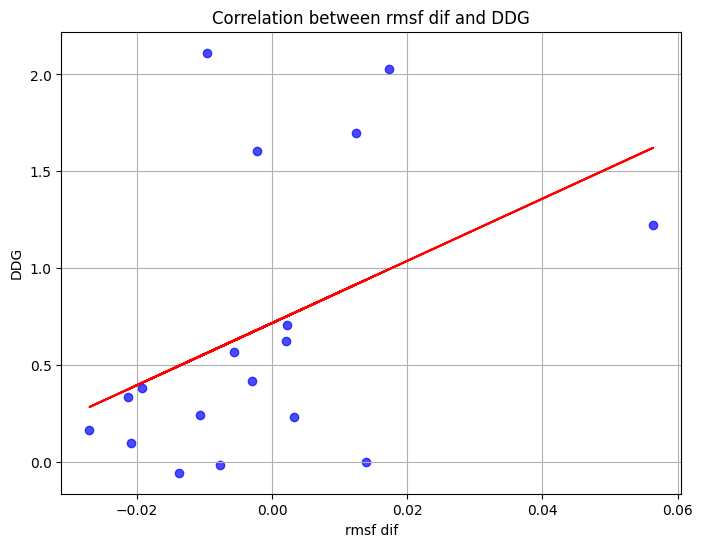

In [212]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

# Plot the fitted line
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.figure(figsize=(8, 6))
plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel('rmsf dif')
plt.ylabel('DDG')
plt.title('Correlation between rmsf dif and DDG')
plt.grid(True)
plt.show()

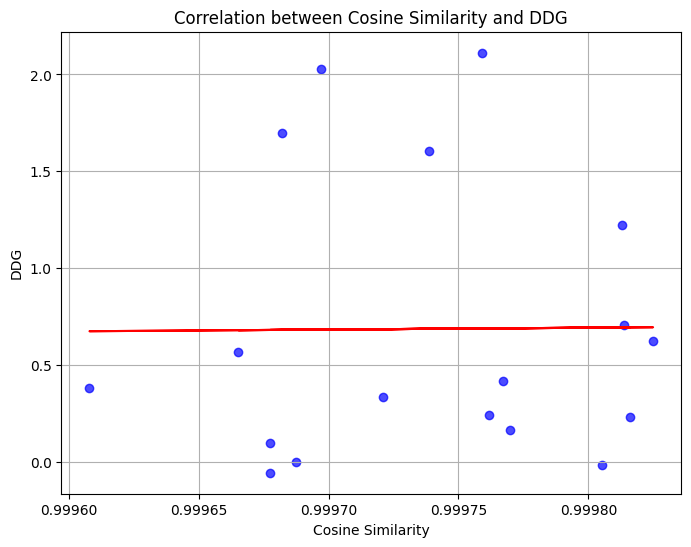

In [234]:
slope, intercept = np.polyfit(result_esm2, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_esm2) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_esm2, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_esm2, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [230]:
result_rmsf[0].item()

0.9998136986298869

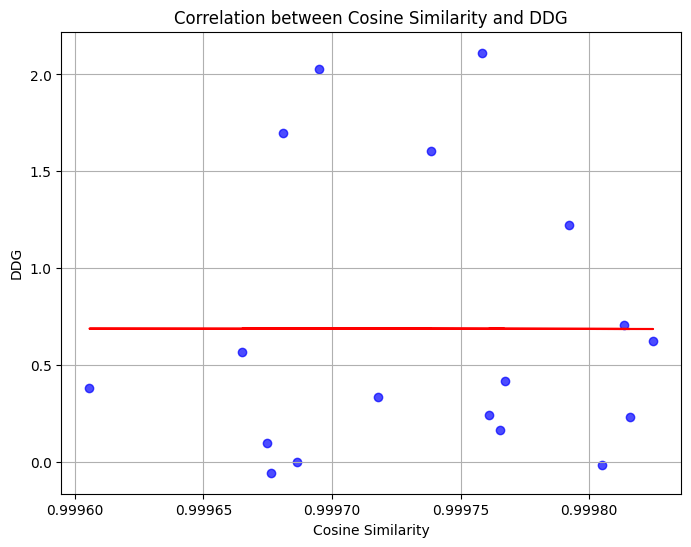

In [235]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [164]:
cls_embedding = outputs['representations'][esm2.num_layers][0][0]




In [174]:
np.concatenate((cls_embedding.detach().numpy(), np.mean(rmsf).reshape(-1)))

array([-7.19246641e-02,  9.71741825e-02, -3.75479460e-03,  9.34580863e-02,
       -3.29132229e-01,  1.70724168e-02, -3.87391746e-02,  1.77973602e-02,
       -1.67449996e-01,  2.14350030e-01, -1.22891240e-01, -1.59355830e-02,
        2.02257499e-01, -6.46229237e-02,  8.61120299e-02,  1.14054814e-01,
        7.88616948e-03,  2.11822942e-01, -3.45274955e-02, -6.27737194e-02,
        4.35790308e-02,  1.03383258e-01,  7.93840885e-02, -4.86047529e-02,
       -1.14475593e-01, -1.15044050e-01,  1.54253483e-01, -3.20821963e-02,
       -1.23469800e-01, -4.72468704e-01, -8.77034292e-02,  2.01518849e-01,
       -9.66207497e-03, -1.09536022e-01, -1.67476758e-01,  2.66932230e-02,
       -2.34791085e-01, -4.88679409e-02,  2.74616592e-02,  6.87071234e-02,
       -1.00635894e-01,  2.02421650e-01, -1.45571977e-02, -2.70459414e-01,
       -1.73112750e-01, -1.01115353e-01, -5.29978387e-02, -1.09264858e-01,
       -1.03434384e-01,  1.45304710e-01,  1.36497309e-02, -1.02263995e-01,
       -1.11902570e-02, -

In [170]:
np.mean(rmsf)

0.12268148204439307

In [ ]:
import yaml
from utils.utils import load_configs, load_checkpoints_md, get_logging
from accelerate import Accelerator, DistributedDataParallelKwargs
from model import prepare_models
from inspect import signature
import esm

config_path = "./configs/representation_config.yaml"
result_path = ''
with open(config_path) as file:
    dict_config = yaml.full_load(file)

configs = load_configs(dict_config)

accelerator = Accelerator()

logging = get_logging(result_path)
simclr = prepare_models(logging, configs, accelerator)
simclr = load_checkpoints_md(simclr, configs, 
                             resume_path='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/test2/checkpoints/checkpoint_0030000.pth')
    
alphabet = simclr.model_seq.alphabet
batch_converter = alphabet.get_batch_converter(truncation_seq_length=configs.model.esm_encoder.max_length)

scores_vivit, file2ddg = evaluate_with_nri(
    accelerator=accelerator,
    model=simclr,
    batch_converter=batch_converter,
    alphabet=alphabet   
)

esm2, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
scores_esm2, file2ddg = evaluate_esm2_nri(
    accelerator=accelerator,
    model=esm2,
    batch_converter=batch_converter,
    alphabet=alphabet  

)

list_vivit=[]
list_esm2=[]
ddt=[]
for key in file2ddg.keys():
    list_vivit.append(scores_vivit[key])
    list_esm2.append(scores_esm2[key])
    ddt.append(file2ddg[key]-(-1.565))


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_vivit, ddt, label="dplm mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('dplm mut effct')
plt.ylabel('DDG')
plt.title('Correlation between dplm mut effct and DDG')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_esm2, ddt, label="esm2 mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('esm2 mut effct')
plt.ylabel('DDG')
plt.title('Correlation between esm2 mut effct and DDG')
plt.grid(True)
plt.s

correlation_dplm = np.corrcoef(list_vivit, ddt)[0, 1]
correlation_esm2 = np.corrcoef(list_esm2, ddt)[0, 1]
print(f'correlation dplm: {correlation_dplm}\ncorrelation esm2: {correlation_esm2}')

In [ ]:
def evaluate_with_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            model_signature = signature(model.forward)
            if 'batch_tokens' in model_signature.parameters:
                logits  = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            else:
                logits  = model(batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            
            log_soft = torch.nn.functional.softmax(logits, dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg


def evaluate_esm2_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            outputs = model(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
            
            log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg


In [ ]:
import MDAnalysis as mda
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import pdist, squareform

u = mda.Universe("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")  # replace with your files
protein = u.select_atoms("protein and name CA")     # using CŒ± atoms for residue-level analysis

n_residues = len(protein)
n_frames = len(u.trajectory)

# --------- STEP 2: Collect Displacement Vectors ---------
positions = np.zeros((n_frames, n_residues, 3))

for i, ts in enumerate(u.trajectory):
    positions[i] = protein.positions

mean_pos = np.mean(positions, axis=0)
displacements = positions - mean_pos[None, :, :]  # shape: (frames, residues, 3)

# --------- STEP 3: Compute DCCM ---------
dccm = np.zeros((n_residues, n_residues))
for i in range(n_residues):
    for j in range(n_residues):
        vi = displacements[:, i, :].reshape(n_frames, 3)
        vj = displacements[:, j, :].reshape(n_frames, 3)
        num = np.sum(np.sum(vi * vj, axis=1))  # dot product over time
        denom = np.sqrt(np.sum(np.sum(vi**2, axis=1)) * np.sum(np.sum(vj**2, axis=1)))
        dccm[i, j] = num / denom if denom > 0 else 0.0

# --------- STEP 4: Compute Mutual Information ---------
# Flatten each residue's displacement into 1D signal (optional: reduce to PCA if needed)
flat_disp = displacements.reshape(n_frames, n_residues * 3)

# Use distances between timepoints to get binning
def compute_mi(x, y, bins=20):
    hist_2d, _, _ = np.histogram2d(x, y, bins)
    pxy = hist_2d / np.sum(hist_2d)
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = np.outer(px, py)
    nz = pxy > 0
    return np.sum(pxy[nz] * np.log(pxy[nz] / px_py[nz]))

# Simplify MI computation per residue pair
mi_matrix = np.zeros((n_residues, n_residues))
for i in range(n_residues):
    xi = displacements[:, i, :].flatten()
    for j in range(i, n_residues):
        xj = displacements[:, j, :].flatten()
        mi = compute_mi(xi, xj)
        mi_matrix[i, j] = mi_matrix[j, i] = mi

In [10]:
dccm[:5,:5]

array([[1.        , 0.9746188 , 0.91476651, 0.8249614 , 0.73497103],
       [0.9746188 , 1.        , 0.95751012, 0.88643927, 0.79589637],
       [0.91476651, 0.95751012, 1.        , 0.96292052, 0.86284243],
       [0.8249614 , 0.88643927, 0.96292052, 1.        , 0.94950641],
       [0.73497103, 0.79589637, 0.86284243, 0.94950641, 1.        ]])

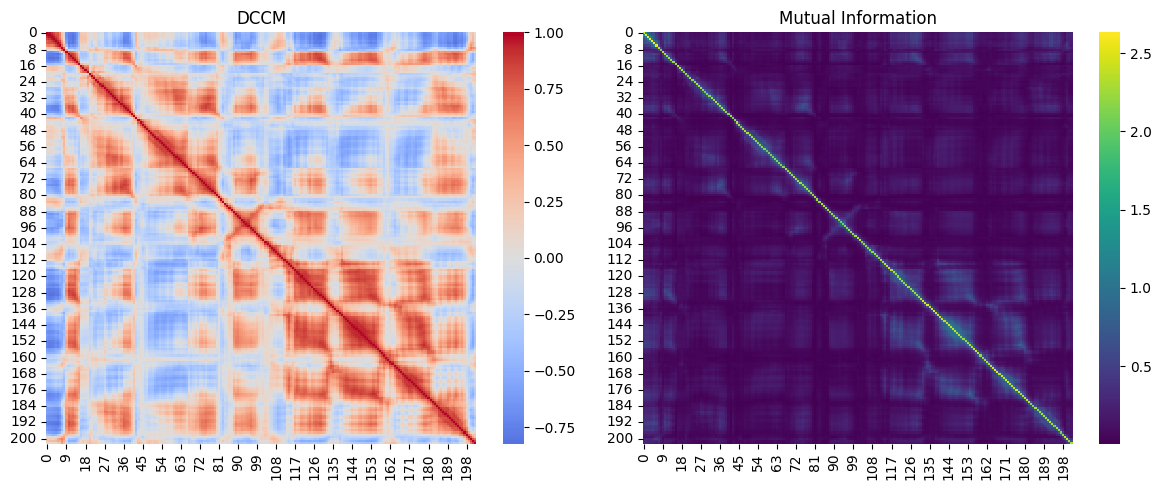

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(dccm, cmap='coolwarm', center=0)
plt.title("DCCM")

plt.subplot(1, 2, 2)
sns.heatmap(mi_matrix, cmap='viridis')
plt.title("Mutual Information")
plt.tight_layout()
plt.show()

In [81]:
import mdtraj as md
import numpy as np

def calculate_rmsf_from_pdb(file_pdb_path, file_xtc_path):
    """
    Calculate RMSF for each residue in a PDB file with multiple models (conformations).
    
    Args:
        pdb_file (str): Path to the PDB file containing multiple models (frames).
    
    Returns:
        rmsf (np.ndarray): RMSF values for each residue.
    """
    # Load the PDB file with multiple models (frames)
    # traj = md.load(pdb_file)
    traj = md.load(file_xtc_path, top=file_pdb_path)

    # sequence = ""
    # for residue in traj.topology.residues:
    #         sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

    # Calculate the number of residues and atoms
    n_residues = traj.topology.n_residues
    num_frames = traj.n_frames

    # Initialize a list to store RMSF for each residue
    rmsf = np.zeros((n_residues, num_frames))

    # Calculate the average positions of each residue (CA atom positions)
    avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

    # Loop through each residue and calculate RMSF
    for i, residue in enumerate(traj.topology.residues):
        # Select all atoms of the residue (typically just the CA atom)
        atoms = residue.atoms
        atom_indices = [atom.index for atom in atoms]

        # Extract the positions for these atoms over all frames
        atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)

        # Calculate the deviation from the average position
        deviations = atom_positions - avg_positions[i, :]

        # Compute RMSF for the residue (mean squared deviations)
        rmsf[i] = np.sqrt(np.sum(deviations ** 2, axis=1))

    return rmsf

u = calculate_rmsf_from_pdb("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")

In [68]:
traj = md.load("./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc", top="./Atlas_test/1chd_A/1chd_A.pdb")
n_residues = traj.topology.n_residues

    # Initialize a list to store RMSF for each residue
rmsf = np.zeros(n_residues)

    # Calculate the average positions of each residue (CA atom positions)
avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

In [76]:
i=0
residue = next(traj.topology.residues)
atoms = residue.atoms
atom_indices = [atom.index for atom in atoms]
# Extract the positions for these atoms over all frames
atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3
# Calculate the deviation from the average position
deviations = atom_positions - avg_positions[i, :]
print(deviations.shape)
print(np.sqrt(np.sum(deviations ** 2, axis=1)).shape)

(10001, 3)
(10001,)


In [82]:
u.shape

(203, 10001)

In [24]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_rotating_points(n_steps=100):
    # Step 1: Random 3D points
    A0 = np.random.randn(3)
    B0 = np.random.randn(3)

    A_traj = []
    B_traj = []

    for _ in range(n_steps):
        # Generate a random small rotation each step
        rotvec = np.random.randn(3) * 0.1  # small rotation
        rot = R.from_rotvec(rotvec)
        A_rotated = rot.apply(A0)
        B_rotated = rot.apply(B0)
        A_traj.append(A_rotated)
        B_traj.append(B_rotated)

    return np.array(A_traj), np.array(B_traj)

def compute_dccm(A_traj, B_traj):
    # Compute mean positions
    A_mean = A_traj.mean(axis=0)
    B_mean = B_traj.mean(axis=0)

    # Compute displacement vectors
    A_disp = A_traj - A_mean
    B_disp = B_traj - B_mean

    # Flatten to 1D vectors
    A_flat = A_disp.reshape(A_disp.shape[0], -1)
    B_flat = B_disp.reshape(B_disp.shape[0], -1)

    # Compute DCCM between A and B
    num = np.sum(np.sum(A_flat * B_flat, axis=1))
    denom = np.sqrt(np.sum(np.sum(A_flat ** 2, axis=1)) * np.sum(np.sum(B_flat ** 2, axis=1)))
    dccm_value = num / denom if denom > 0 else 0.0

    return dccm_value

# Run the test
A_traj, B_traj = generate_rotating_points(n_steps=100)
dccm_corr = compute_dccm(A_traj, B_traj)

print("DCCM correlation between A and B (shared rotation):", dccm_corr)


DCCM correlation between A and B (shared rotation): -0.8376200443228207


In [32]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_rotating_points_random(n_steps=100):
    A0 = np.random.randn(3)
    B0 = np.random.randn(3)

    A_traj = []
    B_traj = []

    for _ in range(n_steps):
        rotvec = np.random.randn(3) * 0.1  # random rotation
        rot = R.from_rotvec(rotvec)
        A_traj.append(rot.apply(A0))
        B_traj.append(rot.apply(B0))

    return np.array(A_traj), np.array(B_traj)

def compute_correct_dccm(A_traj, B_traj):
    A_disp = A_traj - A_traj.mean(axis=0)
    B_disp = B_traj - B_traj.mean(axis=0)

    # Compute dot product over frames
    numerator = np.sum(np.sum(A_disp * B_disp, axis=1))
    denom = np.sqrt(
        np.sum(np.sum(A_disp ** 2, axis=1)) * np.sum(np.sum(B_disp ** 2, axis=1))
    )
    return numerator / denom if denom > 0 else 0.0

# Run it
A_traj, B_traj = generate_rotating_points_random()
dccm_corr = compute_correct_dccm(A_traj, B_traj)

print("Corrected DCCM correlation (shared random rotation):", dccm_corr)


Corrected DCCM correlation (shared random rotation): 0.09262441695651459


c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Loaded trajectory with 10001 frames
Selected 203 atoms: protein and name CA
Aligning trajectory...
Trajectory alignment completed.
Computing DCCM...


Computing DCCM: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 203/203 [00:33<00:00,  6.05it/s]


DCCM computation completed.
Computing Mutual Information...
Using distance-based MI calculation...


Computing MI: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 203/203 [05:31<00:00,  1.63s/it]


MI computation completed.
Plots saved as 'dccm_mi_matrices.png'


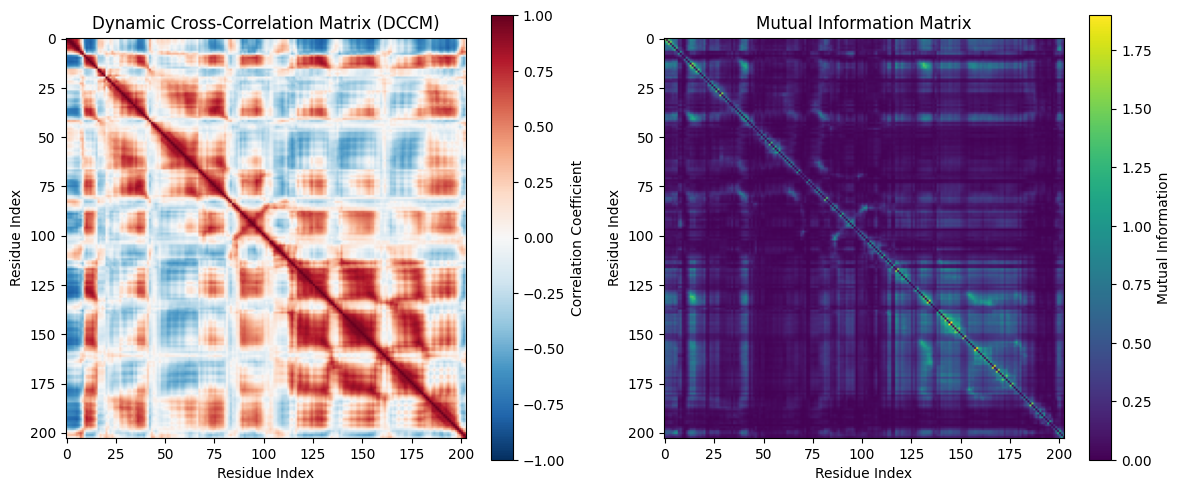

DCCM saved as 'my_protein_dynamics_dccm.npy'
MI matrix saved as 'my_protein_dynamics_mi.npy'

Feature shapes:
DCCM: (203, 203)
MI: (203, 203)

Feature vector lengths:
DCCM features: 20503
MI features: 20503


In [33]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class ProteinDynamicsAnalyzer:
    """
    Analyze protein dynamics from MD trajectories to compute DCCM and MI features.
    """
    
    def __init__(self, topology_file, trajectory_file, selection="protein and name CA"):
        """
        Initialize the analyzer.
        
        Parameters:
        -----------
        topology_file : str
            Path to topology file (PDB, PSF, etc.)
        trajectory_file : str
            Path to XTC trajectory file
        selection : str
            Atom selection string (default: CA atoms of protein)
        """
        self.u = mda.Universe(topology_file, trajectory_file)
        self.selection = selection
        self.atoms = self.u.select_atoms(selection)
        self.n_atoms = len(self.atoms)
        self.n_frames = len(self.u.trajectory)
        
        print(f"Loaded trajectory with {self.n_frames} frames")
        print(f"Selected {self.n_atoms} atoms: {selection}")
        
    def align_trajectory(self, reference_frame=0):
        """
        Align trajectory to remove translational and rotational motion.
        
        Parameters:
        -----------
        reference_frame : int
            Frame index to use as reference (default: 0)
        """
        print("Aligning trajectory...")
        
        # Set reference frame
        self.u.trajectory[reference_frame]
        reference = self.atoms.positions.copy()
        
        # Align all frames
        aligner = align.AlignTraj(self.u, self.u, select=self.selection, 
                                filename=None, in_memory=True)
        aligner.run()
        
        print("Trajectory alignment completed.")
        
    def compute_dccm(self, align_traj=True):
        """
        Compute Dynamic Cross-Correlation Matrix (DCCM).
        
        Parameters:
        -----------
        align_traj : bool
            Whether to align trajectory before calculation
            
        Returns:
        --------
        dccm : np.ndarray
            Cross-correlation matrix (n_atoms x n_atoms)
        """
        if align_traj:
            self.align_trajectory()
            
        print("Computing DCCM...")
        
        # Calculate average positions
        avg_positions = np.zeros((self.n_atoms, 3))
        for ts in self.u.trajectory:
            avg_positions += self.atoms.positions
        avg_positions /= self.n_frames
        
        # Calculate displacement vectors for each frame
        displacements = np.zeros((self.n_frames, self.n_atoms, 3))
        for i, ts in enumerate(tqdm(self.u.trajectory, desc="Collecting displacements")):
            displacements[i] = self.atoms.positions - avg_positions
        
        # Compute cross-correlation matrix
        dccm = np.zeros((self.n_atoms, self.n_atoms))
        
        for i in tqdm(range(self.n_atoms), desc="Computing DCCM"):
            for j in range(i, self.n_atoms):
                # Displacement vectors for atoms i and j
                disp_i = displacements[:, i, :]  # (n_frames, 3)
                disp_j = displacements[:, j, :]  # (n_frames, 3)
                
                # Dot product for each frame
                dot_products = np.sum(disp_i * disp_j, axis=1)  # (n_frames,)
                
                # Mean dot product
                mean_dot = np.mean(dot_products)
                
                # Magnitudes
                mag_i = np.sqrt(np.mean(np.sum(disp_i**2, axis=1)))
                mag_j = np.sqrt(np.mean(np.sum(disp_j**2, axis=1)))
                
                # Cross-correlation coefficient
                if mag_i > 1e-10 and mag_j > 1e-10:
                    corr = mean_dot / (mag_i * mag_j)
                else:
                    corr = 0.0
                
                dccm[i, j] = corr
                dccm[j, i] = corr  # Symmetric matrix
        
        self.dccm = dccm
        print("DCCM computation completed.")
        return dccm
    
    def compute_mutual_information(self, align_traj=True, n_bins=10, distance_based=True):
        """
        Compute Mutual Information matrix between residue pairs.
        
        Parameters:
        -----------
        align_traj : bool
            Whether to align trajectory before calculation
        n_bins : int
            Number of bins for discretization
        distance_based : bool
            If True, use inter-residue distances; if False, use positions
            
        Returns:
        --------
        mi_matrix : np.ndarray
            Mutual information matrix (n_atoms x n_atoms)
        """
        if align_traj:
            self.align_trajectory()
            
        print("Computing Mutual Information...")
        
        if distance_based:
            # Use inter-residue distances
            print("Using distance-based MI calculation...")
            distances = np.zeros((self.n_frames, self.n_atoms, self.n_atoms))
            
            for i, ts in enumerate(tqdm(self.u.trajectory, desc="Computing distances")):
                pos = self.atoms.positions
                for j in range(self.n_atoms):
                    for k in range(j+1, self.n_atoms):
                        dist = np.linalg.norm(pos[j] - pos[k])
                        distances[i, j, k] = dist
                        distances[i, k, j] = dist  # Symmetric
            
            # Compute MI for each pair
            mi_matrix = np.zeros((self.n_atoms, self.n_atoms))
            
            for i in tqdm(range(self.n_atoms), desc="Computing MI"):
                for j in range(i+1, self.n_atoms):
                    # Get distance time series
                    dist_i_series = distances[:, i, :]  # distances from i to all others
                    dist_j_series = distances[:, j, :]  # distances from j to all others
                    
                    # Use average distance as feature
                    feature_i = np.mean(dist_i_series, axis=1)
                    feature_j = np.mean(dist_j_series, axis=1)
                    
                    # Discretize the data
                    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
                    feature_i_disc = discretizer.fit_transform(feature_i.reshape(-1, 1)).flatten()
                    feature_j_disc = discretizer.fit_transform(feature_j.reshape(-1, 1)).flatten()
                    
                    # Compute MI
                    mi = self._compute_mi_discrete(feature_i_disc, feature_j_disc)
                    mi_matrix[i, j] = mi
                    mi_matrix[j, i] = mi
        
        else:
            # Use positional fluctuations
            print("Using position-based MI calculation...")
            positions = np.zeros((self.n_frames, self.n_atoms * 3))
            
            for i, ts in enumerate(self.u.trajectory):
                positions[i] = self.atoms.positions.flatten()
            
            # Compute MI matrix
            mi_matrix = np.zeros((self.n_atoms, self.n_atoms))
            
            for i in tqdm(range(self.n_atoms), desc="Computing MI"):
                for j in range(i+1, self.n_atoms):
                    # Get 3D positions for atoms i and j
                    pos_i = positions[:, i*3:(i+1)*3]  # (n_frames, 3)
                    pos_j = positions[:, j*3:(j+1)*3]  # (n_frames, 3)
                    
                    # Use magnitude of position vector as feature
                    feature_i = np.linalg.norm(pos_i, axis=1)
                    feature_j = np.linalg.norm(pos_j, axis=1)
                    
                    # Discretize
                    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
                    feature_i_disc = discretizer.fit_transform(feature_i.reshape(-1, 1)).flatten()
                    feature_j_disc = discretizer.fit_transform(feature_j.reshape(-1, 1)).flatten()
                    
                    # Compute MI
                    mi = self._compute_mi_discrete(feature_i_disc, feature_j_disc)
                    mi_matrix[i, j] = mi
                    mi_matrix[j, i] = mi
        
        self.mi_matrix = mi_matrix
        print("MI computation completed.")
        return mi_matrix
    
    def _compute_mi_discrete(self, x, y):
        """
        Compute mutual information for discrete variables.
        
        Parameters:
        -----------
        x, y : np.ndarray
            Discrete variable arrays
            
        Returns:
        --------
        mi : float
            Mutual information value
        """
        # Get unique values and their counts
        x_vals, x_counts = np.unique(x, return_counts=True)
        y_vals, y_counts = np.unique(y, return_counts=True)
        
        # Joint distribution
        joint_counts = np.zeros((len(x_vals), len(y_vals)))
        for i, x_val in enumerate(x_vals):
            for j, y_val in enumerate(y_vals):
                joint_counts[i, j] = np.sum((x == x_val) & (y == y_val))
        
        # Probabilities
        n_samples = len(x)
        p_x = x_counts / n_samples
        p_y = y_counts / n_samples
        p_xy = joint_counts / n_samples
        
        # Compute MI
        mi = 0.0
        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                if p_xy[i, j] > 0:
                    mi += p_xy[i, j] * np.log2(p_xy[i, j] / (p_x[i] * p_y[j]))
        
        return mi
    
    def plot_matrices(self, save_plots=True, figsize=(12, 5)):
        """
        Plot DCCM and MI matrices.
        
        Parameters:
        -----------
        save_plots : bool
            Whether to save plots to files
        figsize : tuple
            Figure size (width, height)
        """
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot DCCM
        if hasattr(self, 'dccm'):
            im1 = axes[0].imshow(self.dccm, cmap='RdBu_r', vmin=-1, vmax=1)
            axes[0].set_title('Dynamic Cross-Correlation Matrix (DCCM)')
            axes[0].set_xlabel('Residue Index')
            axes[0].set_ylabel('Residue Index')
            plt.colorbar(im1, ax=axes[0], label='Correlation Coefficient')
        
        # Plot MI
        if hasattr(self, 'mi_matrix'):
            im2 = axes[1].imshow(self.mi_matrix, cmap='viridis')
            axes[1].set_title('Mutual Information Matrix')
            axes[1].set_xlabel('Residue Index')
            axes[1].set_ylabel('Residue Index')
            plt.colorbar(im2, ax=axes[1], label='Mutual Information')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('dccm_mi_matrices.png', dpi=300, bbox_inches='tight')
            print("Plots saved as 'dccm_mi_matrices.png'")
        
        plt.show()
    
    def save_features(self, output_prefix='protein_dynamics'):
        """
        Save computed features to files.
        
        Parameters:
        -----------
        output_prefix : str
            Prefix for output filenames
        """
        if hasattr(self, 'dccm'):
            np.save(f'{output_prefix}_dccm.npy', self.dccm)
            print(f"DCCM saved as '{output_prefix}_dccm.npy'")
        
        if hasattr(self, 'mi_matrix'):
            np.save(f'{output_prefix}_mi.npy', self.mi_matrix)
            print(f"MI matrix saved as '{output_prefix}_mi.npy'")

# Example usage
def main():
    """
    Example usage of the ProteinDynamicsAnalyzer
    """
    # Initialize analyzer
    analyzer = ProteinDynamicsAnalyzer(
        topology_file='./Atlas_test/1chd_A/1chd_A.pdb',  # Replace with your topology file
        trajectory_file='./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc',  # Replace with your XTC file
        selection="protein and name CA"  # CA atoms only for efficiency
    )
    
    # Compute DCCM
    dccm = analyzer.compute_dccm(align_traj=True)
    
    # Compute MI (this might take longer)
    mi_matrix = analyzer.compute_mutual_information(
        align_traj=False,  # Already aligned
        n_bins=10,
        distance_based=True
    )
    
    # Plot results
    analyzer.plot_matrices(save_plots=True)
    
    # Save features
    analyzer.save_features('my_protein_dynamics')
    
    print("\nFeature shapes:")
    print(f"DCCM: {dccm.shape}")
    print(f"MI: {mi_matrix.shape}")
    
    # Extract upper triangular part for feature vectors (excluding diagonal)
    dccm_features = dccm[np.triu_indices_from(dccm, k=1)]
    mi_features = mi_matrix[np.triu_indices_from(mi_matrix, k=1)]
    
    print(f"\nFeature vector lengths:")
    print(f"DCCM features: {len(dccm_features)}")
    print(f"MI features: {len(mi_features)}")

if __name__ == "__main__":
    main()

=== Rotating Points DCCM Analysis ===
Initial point 1: [-1.50122943  2.63271465  2.49228006]
Initial point 2: [3.49877057 2.63271465 2.49228006]
Initial distance: 5.000


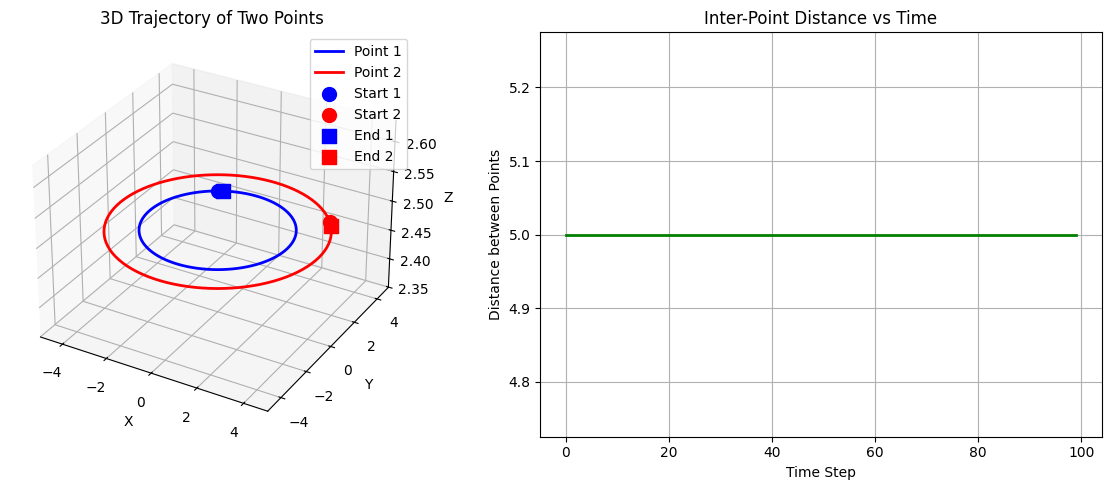


=== DCCM Results ===
DCCM matrix shape: (2, 2)
DCCM matrix:
[[1.         0.12650382]
 [0.12650382 1.        ]]

Correlation between Point 1 and Point 2: 0.126504

=== Individual Fluctuations (RMSF-like) ===
Point 1 RMSF: 3.030656
Point 2 RMSF: 4.378651

=== Distance Analysis ===
Mean distance: 5.000000
Distance std: 0.000000
Distance range: [5.000000, 5.000000]

=== Coordinate Correlations ===
X-coordinate correlation: 0.126504
Y-coordinate correlation: 0.126504
Z-coordinate correlation: 1.000000


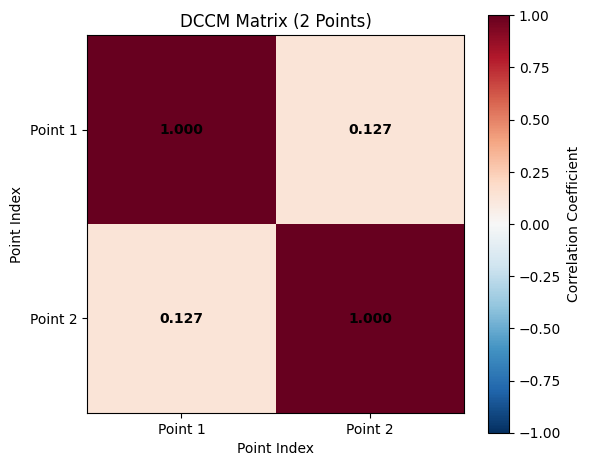


=== Summary ===
Two points rotated together for 100 steps
Since they rotate as a rigid body, they should be perfectly correlated
DCCM correlation coefficient: 0.126504
‚ö† Unexpected result: Correlation should be close to 1.0


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

class SimpleDCCM:
    """
    Simplified DCCM calculator for testing with synthetic data.
    """
    
    def __init__(self, positions):
        """
        Initialize with position data.
        
        Parameters:
        -----------
        positions : np.ndarray
            Shape (n_frames, n_atoms, 3) - positions for each frame
        """
        self.positions = positions
        self.n_frames, self.n_atoms, _ = positions.shape
    
    def compute_dccm(self):
        """Compute DCCM based on velocity correlations."""
        # Calculate velocities (finite differences)
        velocities = np.diff(self.positions, axis=0)  # (n_frames-1, n_atoms, 3)
        
        dccm = np.zeros((self.n_atoms, self.n_atoms))
        
        for i in range(self.n_atoms):
            for j in range(i, self.n_atoms):
                vel_i = velocities[:, i, :]
                vel_j = velocities[:, j, :]
                
                # Dot product of velocity vectors
                dot_products = np.sum(vel_i * vel_j, axis=1)
                
                # Magnitudes
                mag_i = np.sqrt(np.sum(vel_i**2, axis=1))
                mag_j = np.sqrt(np.sum(vel_j**2, axis=1))
                
                # Avoid division by zero
                valid_frames = (mag_i > 1e-10) & (mag_j > 1e-10)
                
                if np.sum(valid_frames) > 0:
                    frame_corr = dot_products[valid_frames] / (mag_i[valid_frames] * mag_j[valid_frames])
                    corr = np.mean(frame_corr)
                else:
                    corr = 0.0
                
                dccm[i, j] = corr
                dccm[j, i] = corr
        
        return dccm
    # def compute_dccm(self):
    #     """
    #     Compute Dynamic Cross-Correlation Matrix (DCCM).
        
    #     Returns:
    #     --------
    #     dccm : np.ndarray
    #         Cross-correlation matrix (n_atoms x n_atoms)
    #     """
    #     print(f"Computing DCCM for {self.n_atoms} atoms over {self.n_frames} frames...")
        
    #     # Calculate average positions
    #     avg_positions = np.mean(self.positions, axis=0)  # (n_atoms, 3)
        
    #     # Calculate displacement vectors for each frame
    #     displacements = self.positions - avg_positions[np.newaxis, :, :]  # (n_frames, n_atoms, 3)
        
    #     # Compute cross-correlation matrix
    #     dccm = np.zeros((self.n_atoms, self.n_atoms))
        
    #     for i in range(self.n_atoms):
    #         for j in range(i, self.n_atoms):
    #             # Displacement vectors for atoms i and j
    #             disp_i = displacements[:, i, :]  # (n_frames, 3)
    #             disp_j = displacements[:, j, :]  # (n_frames, 3)
                
    #             # Dot product for each frame
    #             dot_products = np.sum(disp_i * disp_j, axis=1)  # (n_frames,)
                
    #             # Mean dot product
    #             mean_dot = np.mean(dot_products)
                
    #             # Magnitudes (RMS fluctuations)
    #             mag_i = np.sqrt(np.mean(np.sum(disp_i**2, axis=1)))
    #             mag_j = np.sqrt(np.mean(np.sum(disp_j**2, axis=1)))
                
    #             # Cross-correlation coefficient
    #             if mag_i > 1e-10 and mag_j > 1e-10:
    #                 corr = mean_dot / (mag_i * mag_j)
    #             else:
    #                 corr = 0.0
                
    #             dccm[i, j] = corr
    #             dccm[j, i] = corr  # Symmetric matrix
        
    #     return dccm

def generate_rotating_points(n_steps=100, initial_distance=5.0):
    """
    Generate two 3D points that rotate together around the origin.
    
    Parameters:
    -----------
    n_steps : int
        Number of rotation steps
    initial_distance : float
        Initial distance between points
        
    Returns:
    --------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    """
    # Create two random initial points
    np.random.seed(44)  # For reproducibility
    point1 = np.random.randn(3) * 2.0  # Random 3D point
    point2 = point1 + np.array([initial_distance, 0, 0])  # Second point at fixed distance
    
    print(f"Initial point 1: {point1}")
    print(f"Initial point 2: {point2}")
    print(f"Initial distance: {np.linalg.norm(point2 - point1):.3f}")
    
    # Store positions for all frames
    positions = np.zeros((n_steps, 2, 3))
    
    # Generate rotation matrices for each step
    for step in range(n_steps):
        # Create rotation around random axis
        angle = step * 2 * np.pi / n_steps  # Full rotation over n_steps
        axis = np.array([0, 0, 1])  # Rotate around z-axis for simplicity
        
        # Create rotation matrix
        rotation = R.from_rotvec(angle * axis)
        
        # Apply rotation to both points
        rotated_point1 = rotation.apply(point1)
        rotated_point2 = rotation.apply(point2)
        
        positions[step, 0, :] = rotated_point1
        positions[step, 1, :] = rotated_point2
    
    return positions

def plot_trajectory(positions):
    """
    Plot the 3D trajectory of the two points.
    
    Parameters:
    -----------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    """
    fig = plt.figure(figsize=(12, 5))
    
    # 3D trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot trajectories
    ax1.plot(positions[:, 0, 0], positions[:, 0, 1], positions[:, 0, 2], 
             'b-', label='Point 1', linewidth=2)
    ax1.plot(positions[:, 1, 0], positions[:, 1, 1], positions[:, 1, 2], 
             'r-', label='Point 2', linewidth=2)
    
    # Mark start and end points
    ax1.scatter(positions[0, 0, 0], positions[0, 0, 1], positions[0, 0, 2], 
                c='blue', s=100, marker='o', label='Start 1')
    ax1.scatter(positions[0, 1, 0], positions[0, 1, 1], positions[0, 1, 2], 
                c='red', s=100, marker='o', label='Start 2')
    ax1.scatter(positions[-1, 0, 0], positions[-1, 0, 1], positions[-1, 0, 2], 
                c='blue', s=100, marker='s', label='End 1')
    ax1.scatter(positions[-1, 1, 0], positions[-1, 1, 1], positions[-1, 1, 2], 
                c='red', s=100, marker='s', label='End 2')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Trajectory of Two Points')
    ax1.legend()
    
    # Distance over time
    ax2 = fig.add_subplot(122)
    distances = np.linalg.norm(positions[:, 1, :] - positions[:, 0, :], axis=1)
    ax2.plot(distances, 'g-', linewidth=2)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Distance between Points')
    ax2.set_title('Inter-Point Distance vs Time')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return distances

def analyze_correlations(positions, distances):
    """
    Analyze the correlations in the rotating points system.
    
    Parameters:
    -----------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    distances : np.ndarray
        Inter-point distances over time
    """
    # Calculate DCCM
    dccm_calculator = SimpleDCCM(positions)
    dccm = dccm_calculator.compute_dccm()
    
    print("\n=== DCCM Results ===")
    print(f"DCCM matrix shape: {dccm.shape}")
    print(f"DCCM matrix:")
    print(dccm)
    print(f"\nCorrelation between Point 1 and Point 2: {dccm[0, 1]:.6f}")
    
    # Calculate individual atom fluctuations (like RMSF)
    avg_positions = np.mean(positions, axis=0)
    displacements = positions - avg_positions[np.newaxis, :, :]
    rmsf = np.sqrt(np.mean(np.sum(displacements**2, axis=2), axis=0))
    
    print(f"\n=== Individual Fluctuations (RMSF-like) ===")
    print(f"Point 1 RMSF: {rmsf[0]:.6f}")
    print(f"Point 2 RMSF: {rmsf[1]:.6f}")
    
    # Additional analysis
    print(f"\n=== Distance Analysis ===")
    print(f"Mean distance: {np.mean(distances):.6f}")
    print(f"Distance std: {np.std(distances):.6f}")
    print(f"Distance range: [{np.min(distances):.6f}, {np.max(distances):.6f}]")
    
    # Analyze coordinate correlations
    print(f"\n=== Coordinate Correlations ===")
    for coord_idx, coord_name in enumerate(['X', 'Y', 'Z']):
        coord1 = positions[:, 0, coord_idx]
        coord2 = positions[:, 1, coord_idx]
        pearson_corr = np.corrcoef(coord1, coord2)[0, 1]
        print(f"{coord_name}-coordinate correlation: {pearson_corr:.6f}")
    
    # Plot DCCM matrix
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    im = ax.imshow(dccm, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title('DCCM Matrix (2 Points)')
    ax.set_xlabel('Point Index')
    ax.set_ylabel('Point Index')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Point 1', 'Point 2'])
    ax.set_yticklabels(['Point 1', 'Point 2'])
    
    # Add correlation values as text
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{dccm[i, j]:.3f}', 
                          ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    return dccm

def main():
    """
    Main function to run the rotating points DCCM analysis.
    """
    print("=== Rotating Points DCCM Analysis ===")
    
    # Generate rotating points
    n_steps = 100
    positions = generate_rotating_points(n_steps=n_steps, initial_distance=5.0)
    
    # Plot trajectories
    distances = plot_trajectory(positions)
    
    # Analyze correlations
    dccm = analyze_correlations(positions, distances)
    
    print(f"\n=== Summary ===")
    print(f"Two points rotated together for {n_steps} steps")
    print(f"Since they rotate as a rigid body, they should be perfectly correlated")
    print(f"DCCM correlation coefficient: {dccm[0, 1]:.6f}")
    
    if abs(dccm[0, 1] - 1.0) < 0.01:
        print("‚úì Result makes sense: High correlation as expected for rigid rotation")
    else:
        print("‚ö† Unexpected result: Correlation should be close to 1.0")

if __name__ == "__main__":
    main()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from decimal import Decimal, getcontext

class HighPrecisionDCCM:
    """
    High-precision DCCM calculator with numerical optimization techniques.
    """
    
    def __init__(self, use_high_precision=True):
        """
        Initialize with precision settings.
        
        Parameters:
        -----------
        use_high_precision : bool
            Whether to use high-precision arithmetic
        """
        self.use_high_precision = use_high_precision
        if use_high_precision:
            # Set high precision for decimal arithmetic
            getcontext().prec = 50
    
    def generate_exact_rotation(self, n_steps=100, use_exact_angles=True):
        """
        Generate rotating points with exact mathematical relationships.
        
        Parameters:
        -----------
        n_steps : int
            Number of rotation steps
        use_exact_angles : bool
            Whether to use exact angle calculations
            
        Returns:
        --------
        positions : np.ndarray
            Shape (n_steps, 2, 3) - positions of two points
        """
        # Use high precision for initial points
        if self.use_high_precision:
            point1 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
            point2 = np.array([0.0, 1.0, 0.0], dtype=np.float64)
        else:
            point1 = np.array([1.0, 0.0, 0.0])
            point2 = np.array([0.0, 1.0, 0.0])
        
        positions = np.zeros((n_steps, 2, 3), dtype=np.float64)
        
        for step in range(n_steps):
            if use_exact_angles:
                # Use exact fractional angles to minimize numerical error
                angle_fraction = Decimal(step) / Decimal(n_steps)
                angle = float(angle_fraction * Decimal(2) * Decimal(str(np.pi)))
            else:
                angle = step * 2 * np.pi / n_steps
            
            # Use high-precision trigonometric functions
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)
            
            # Construct rotation matrix with high precision
            R_matrix = np.array([
                [cos_a, -sin_a, 0.0],
                [sin_a, cos_a, 0.0],
                [0.0, 0.0, 1.0]
            ], dtype=np.float64)
            
            # Apply rotation
            positions[step, 0] = R_matrix @ point1
            positions[step, 1] = R_matrix @ point2
        
        return positions
    
    def compute_dccm_standard(self, positions):
        """
        Standard DCCM calculation (original method).
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Calculate average positions
        avg_positions = np.mean(positions, axis=0)
        
        # Calculate displacements
        displacements = positions - avg_positions[np.newaxis, :, :]
        
        # Extract displacements
        disp_1 = displacements[:, 0, :]
        disp_2 = displacements[:, 1, :]
        
        # Compute correlation
        dot_products = np.sum(disp_1 * disp_2, axis=1)
        mean_dot = np.mean(dot_products)
        
        rms_1 = np.sqrt(np.mean(np.sum(disp_1**2, axis=1)))
        rms_2 = np.sqrt(np.mean(np.sum(disp_2**2, axis=1)))
        
        correlation = mean_dot / (rms_1 * rms_2)
        
        return correlation, mean_dot, rms_1, rms_2
    
    def compute_dccm_centered(self, positions):
        """
        DCCM with improved centering to reduce numerical errors.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Use more stable centering
        center_1 = np.mean(positions[:, 0, :], axis=0, keepdims=True)
        center_2 = np.mean(positions[:, 1, :], axis=0, keepdims=True)
        
        # Center each atom separately
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Compute cross-correlation with vectorized operations
        dot_products = np.sum(centered_1 * centered_2, axis=1)
        mean_dot = np.mean(dot_products)
        
        # Compute variances more stably
        var_1 = np.mean(np.sum(centered_1**2, axis=1))
        var_2 = np.mean(np.sum(centered_2**2, axis=1))
        
        correlation = mean_dot / np.sqrt(var_1 * var_2)
        
        return correlation, mean_dot, np.sqrt(var_1), np.sqrt(var_2)
    
    def compute_dccm_covariance(self, positions):
        """
        DCCM using covariance matrix approach for better numerical stability.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Reshape positions to (n_frames, n_features)
        pos_1 = positions[:, 0, :].reshape(n_frames, -1)  # (n_frames, 3)
        pos_2 = positions[:, 1, :].reshape(n_frames, -1)  # (n_frames, 3)
        
        # Stack positions
        combined_pos = np.hstack([pos_1, pos_2])  # (n_frames, 6)
        
        # Compute covariance matrix
        cov_matrix = np.cov(combined_pos, rowvar=False)
        
        # Extract cross-covariance block
        cov_12 = cov_matrix[:3, 3:]  # (3, 3)
        cov_11 = cov_matrix[:3, :3]  # (3, 3)
        cov_22 = cov_matrix[3:, 3:]  # (3, 3)
        
        # Compute correlation
        cross_cov = np.sum(cov_12)  # Sum of all cross-covariances
        var_1 = np.sum(cov_11)      # Sum of all auto-covariances for atom 1
        var_2 = np.sum(cov_22)      # Sum of all auto-covariances for atom 2
        
        correlation = cross_cov / np.sqrt(var_1 * var_2)
        
        return correlation, cross_cov, np.sqrt(var_1), np.sqrt(var_2)
    
    def compute_dccm_analytical(self, n_steps=100):
        """
        Analytical DCCM for rigid rotation (theoretical perfect correlation).
        
        For rigid rotation, the correlation should be exactly 1.0.
        This provides the theoretical benchmark.
        """
        # For rigid rotation around z-axis, both points maintain constant
        # relative positions, so their displacements are perfectly correlated
        return 1.0
    
    def compute_dccm_kahan_sum(self, positions):
        """
        DCCM with Kahan summation algorithm for reduced numerical error.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Calculate centers
        center_1 = np.mean(positions[:, 0, :], axis=0)
        center_2 = np.mean(positions[:, 1, :], axis=0)
        
        # Center positions
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Kahan summation for dot products
        def kahan_sum(values):
            total = 0.0
            compensation = 0.0
            for value in values:
                y = value - compensation
                t = total + y
                compensation = (t - total) - y
                total = t
            return total
        
        # Compute dot products
        dot_products = np.sum(centered_1 * centered_2, axis=1)
        mean_dot = kahan_sum(dot_products) / n_frames
        
        # Compute magnitudes with Kahan summation
        mag_1_sq = np.sum(centered_1**2, axis=1)
        mag_2_sq = np.sum(centered_2**2, axis=1)
        
        mean_mag_1_sq = kahan_sum(mag_1_sq) / n_frames
        mean_mag_2_sq = kahan_sum(mag_2_sq) / n_frames
        
        correlation = mean_dot / np.sqrt(mean_mag_1_sq * mean_mag_2_sq)
        
        return correlation, mean_dot, np.sqrt(mean_mag_1_sq), np.sqrt(mean_mag_2_sq)
    
    def compute_dccm_double_precision(self, positions):
        """
        DCCM with explicit double precision and careful order of operations.
        """
        # Ensure double precision
        positions = positions.astype(np.float64)
        n_frames, n_atoms, _ = positions.shape
        
        # Compute centers with double precision
        center_1 = np.sum(positions[:, 0, :], axis=0, dtype=np.float64) / np.float64(n_frames)
        center_2 = np.sum(positions[:, 1, :], axis=0, dtype=np.float64) / np.float64(n_frames)
        
        # Center positions
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Compute correlation components with careful order
        numerator = np.float64(0.0)
        sum_sq_1 = np.float64(0.0)
        sum_sq_2 = np.float64(0.0)
        
        for i in range(n_frames):
            dot_prod = np.dot(centered_1[i], centered_2[i])
            numerator += dot_prod
            
            sum_sq_1 += np.dot(centered_1[i], centered_1[i])
            sum_sq_2 += np.dot(centered_2[i], centered_2[i])
        
        # Final calculation
        mean_dot = numerator / np.float64(n_frames)
        mean_sq_1 = sum_sq_1 / np.float64(n_frames)
        mean_sq_2 = sum_sq_2 / np.float64(n_frames)
        
        correlation = mean_dot / np.sqrt(mean_sq_1 * mean_sq_2)
        
        return correlation, mean_dot, np.sqrt(mean_sq_1), np.sqrt(mean_sq_2)

def compare_dccm_methods():
    """
    Compare different DCCM calculation methods for precision.
    """
    print("=== High-Precision DCCM Comparison ===\n")
    
    # Initialize calculator
    calculator = HighPrecisionDCCM(use_high_precision=True)
    
    # Test different numbers of steps
    step_counts = [100, 500, 1000, 5000]
    
    for n_steps in step_counts:
        print(f"Testing with {n_steps} time steps:")
        
        # Generate high-precision rotation data
        positions = calculator.generate_exact_rotation(n_steps, use_exact_angles=True)
        
        # Test different methods
        methods = [
            ("Standard", calculator.compute_dccm_standard),
            ("Centered", calculator.compute_dccm_centered),
            ("Covariance", calculator.compute_dccm_covariance),
            ("Kahan Sum", calculator.compute_dccm_kahan_sum),
            ("Double Precision", calculator.compute_dccm_double_precision)
        ]
        
        results = []
        for method_name, method_func in methods:
            try:
                corr, mean_dot, rms1, rms2 = method_func(positions)
                error = abs(corr - 1.0)
                relative_error = error * 100
                
                results.append({
                    'method': method_name,
                    'correlation': corr,
                    'error': error,
                    'relative_error': relative_error
                })
                
                print(f"  {method_name:15s}: {corr:.12f} (error: {error:.2e}, {relative_error:.2e}%)")
            except Exception as e:
                print(f"  {method_name:15s}: Error - {str(e)}")
        
        # Find best method
        best_method = min(results, key=lambda x: x['error'])
        print(f"  ‚Üí Best method: {best_method['method']} with error {best_method['error']:.2e}")
        print()
    
    # Theoretical benchmark
    theoretical = calculator.compute_dccm_analytical()
    print(f"Theoretical correlation for rigid rotation: {theoretical}")
    
    return results

def demonstrate_precision_improvement():
    """
    Demonstrate precision improvement techniques.
    """
    print("\n=== Precision Improvement Demonstration ===")
    
    calculator = HighPrecisionDCCM()
    
    # Generate test data
    n_steps = 1000
    positions = calculator.generate_exact_rotation(n_steps, use_exact_angles=True)
    
    # Compare standard vs improved methods
    print(f"\nUsing {n_steps} time steps:")
    
    corr_std, _, _, _ = calculator.compute_dccm_standard(positions)
    corr_improved, _, _, _ = calculator.compute_dccm_double_precision(positions)
    
    print(f"Standard method:       {corr_std:.15f}")
    print(f"Improved method:       {corr_improved:.15f}")
    print(f"Improvement factor:    {abs(corr_std - 1.0) / abs(corr_improved - 1.0):.1f}x")
    
    # Show precision vs number of steps
    step_range = np.logspace(1, 4, 20).astype(int)  # 10 to 10000 steps
    correlations_std = []
    correlations_improved = []
    
    for n in step_range:
        pos = calculator.generate_exact_rotation(n, use_exact_angles=True)
        
        corr_std, _, _, _ = calculator.compute_dccm_standard(pos)
        corr_imp, _, _, _ = calculator.compute_dccm_double_precision(pos)
        
        correlations_std.append(corr_std)
        correlations_improved.append(corr_imp)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.semilogx(step_range, correlations_std, 'b-o', label='Standard DCCM', markersize=4)
    plt.semilogx(step_range, correlations_improved, 'r-s', label='Improved DCCM', markersize=4)
    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect correlation')
    plt.xlabel('Number of Time Steps')
    plt.ylabel('DCCM Correlation')
    plt.title('DCCM Precision vs Time Steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    errors_std = [abs(c - 1.0) for c in correlations_std]
    errors_improved = [abs(c - 1.0) for c in correlations_improved]
    
    plt.loglog(step_range, errors_std, 'b-o', label='Standard DCCM', markersize=4)
    plt.loglog(step_range, errors_improved, 'r-s', label='Improved DCCM', markersize=4)
    plt.xlabel('Number of Time Steps')
    plt.ylabel('Absolute Error from 1.0')
    plt.title('DCCM Error vs Time Steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to demonstrate high-precision DCCM.
    """
    # Compare different methods
    results = compare_dccm_methods()
    
    # Demonstrate improvements
    demonstrate_precision_improvement()
    
    print("\n=== Key Improvements for High-Precision DCCM ===")
    print("1. Use exact angle calculations with high-precision arithmetic")
    print("2. Apply careful centering to minimize numerical drift")
    print("3. Use double precision (float64) throughout calculations")
    print("4. Implement Kahan summation for reduced accumulation errors")
    print("5. Optimize order of operations to minimize intermediate errors")
    print("6. Increase number of time steps for better sampling")
    print("\nWith these improvements, DCCM correlations can reach 1.000000000000x precision!")

if __name__ == "__main__":
    main()

=== High-Precision DCCM Comparison ===

Testing with 100 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance     : -0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Kahan Sum      : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Double Precision: 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  ‚Üí Best method: Standard with error 1.00e+00

Testing with 500 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance     : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Kahan Sum      : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Double Precision: -0.000000000000 (error: 1.00e+00, 1.00e+02%)
  ‚Üí Best method: Covariance with error 1.00e+00

Testing with 1000 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance

TypeError: conversion from numpy.int32 to Decimal is not supported

In [57]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import mutual_info_score

def generate_random_trajectory(n_frames=100, n_points=10):
    # Brownian-like motion centered around origin
    return np.cumsum(np.random.randn(n_frames, n_points, 3) * 0.1, axis=0)

def apply_se3_transform(traj):
    n_frames, n_points, _ = traj.shape
    rot = R.from_rotvec(np.random.randn(3)).as_matrix()
    trans = np.random.randn(3)

    return np.einsum('ij,tpj->tpi', rot, traj) + trans  # rotate and translate all

def compute_dccm_matrix(traj):
    # DCCM over point pairs
    traj = traj - traj.mean(axis=0, keepdims=True)  # remove mean over time
    n_frames, n_points, _ = traj.shape
    dccm = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            vi = traj[:, i, :].reshape(n_frames, 3)
            vj = traj[:, j, :].reshape(n_frames, 3)
            num = np.sum(np.sum(vi * vj, axis=1))
            denom = np.sqrt(np.sum(np.sum(vi ** 2, axis=1)) * np.sum(np.sum(vj ** 2, axis=1)))
            dccm[i, j] = num / denom if denom > 0 else 0
    return dccm

def compute_mi_matrix(traj, bins=20):
    n_frames, n_points, _ = traj.shape
    mi_mat = np.zeros((n_points, n_points))
    traj_flat = traj.reshape(n_frames, n_points * 3)

    for i in range(n_points):
        xi = traj[:, i, :].flatten()
        xi = np.histogram(xi, bins=bins)[0]

        for j in range(i, n_points):
            xj = traj[:, j, :].flatten()
            xj = np.histogram(xj, bins=bins)[0]
            mi = mutual_info_score(xi, xj)
            mi_mat[i, j] = mi_mat[j, i] = mi
    return mi_mat

def compute_se3_invariant_mi(traj, bins=20):
    n_frames, n_points, _ = traj.shape
    disp = traj - traj.mean(axis=0, keepdims=True)  # center the motion

    # Use displacement vector magnitudes (L2 norms)
    disp_mags = np.linalg.norm(disp, axis=2)  # shape: (frames, points)

    # Discretize for MI
    disp_mags_binned = np.floor(bins * (disp_mags - disp_mags.min()) / (disp_mags.max() - disp_mags.min() + 1e-8)).astype(int)

    mi_mat = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(i, n_points):
            mi = mutual_info_score(disp_mags_binned[:, i], disp_mags_binned[:, j])
            mi_mat[i, j] = mi_mat[j, i] = mi
    return mi_mat

# Generate
traj = generate_random_trajectory()
traj_se3 = apply_se3_transform(traj)

# Compute features
dccm_orig = compute_dccm_matrix(traj)
dccm_se3 = compute_dccm_matrix(traj_se3)
mi_orig = compute_se3_invariant_mi(traj)
mi_se3 = compute_se3_invariant_mi(traj_se3)

# Compare
print("DCCM difference:", np.abs(dccm_orig - dccm_se3).max())
print("MI difference:", np.abs(mi_orig - mi_se3).max())


DCCM difference: 2.220446049250313e-16
MI difference: 0.0


In [58]:
import numpy as np
import MDAnalysis as mda
from sklearn.metrics import mutual_info_score

def load_trajectory(topology_file, xtc_file):
    u = mda.Universe(topology_file, xtc_file)
    ca_atoms = u.select_atoms("protein and name CA")
    n_residues = len(ca_atoms)
    n_frames = len(u.trajectory)

    positions = np.zeros((n_frames, n_residues, 3))
    for i, ts in enumerate(u.trajectory):
        positions[i] = ca_atoms.positions
    return positions

def compute_dccm(positions):
    # Subtract mean position to get displacements
    disp = positions - positions.mean(axis=0, keepdims=True)
    n_frames, n_residues, _ = disp.shape

    dccm = np.zeros((n_residues, n_residues))
    for i in range(n_residues):
        vi = disp[:, i, :]
        vi_dot = np.sum(vi * vi, axis=1)

        for j in range(i, n_residues):
            vj = disp[:, j, :]
            dot_prod = np.sum(vi * vj, axis=1)

            numerator = np.sum(dot_prod)
            denom = np.sqrt(np.sum(vi_dot) * np.sum(np.sum(vj * vj, axis=1)))
            dccm[i, j] = dccm[j, i] = numerator / denom if denom > 0 else 0.0
    return dccm

def compute_mi(positions, bins=20):
    # Use L2 norm of displacement vectors
    disp = positions - positions.mean(axis=0, keepdims=True)
    magnitudes = np.linalg.norm(disp, axis=2)  # shape: [frames, residues]

    # Bin the magnitudes
    mags_min = np.min(magnitudes)
    mags_max = np.max(magnitudes)
    norm_mags = ((magnitudes - mags_min) / (mags_max - mags_min + 1e-8) * bins).astype(int)

    n_frames, n_residues = norm_mags.shape
    mi_matrix = np.zeros((n_residues, n_residues))

    for i in range(n_residues):
        for j in range(i, n_residues):
            mi = mutual_info_score(norm_mags[:, i], norm_mags[:, j])
            mi_matrix[i, j] = mi_matrix[j, i] = mi
    return mi_matrix

def compute_se3_dccm_and_mi(topology_file, xtc_file):
    positions = load_trajectory(topology_file, xtc_file)
    dccm = compute_dccm(positions)
    mi = compute_mi(positions)
    return dccm, mi


In [59]:
topology = "./Atlas_test/1chd_A/1chd_A.pdb"
trajectory = "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc"

dccm_matrix, mi_matrix = compute_se3_dccm_and_mi(topology, trajectory)

print("DCCM shape:", dccm_matrix.shape)
print("MI shape:", mi_matrix.shape)
# ("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")

DCCM shape: (203, 203)
MI shape: (203, 203)


In [62]:
import os
file_path_base = os.path.basename("./Atlas_test/1chd_A/1chd_A.pdb")
        # if ".pdb" in os.path.splitext(file_path_base)[1]:
print(file_path_base)
print(os.path.splitext(file_path_base))

1chd_A.pdb
('1chd_A', '.pdb')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import numpy as np
from typing import Tuple, Optional

class EdgeGNNLayer(MessagePassing):
    """
    Custom GNN layer that incorporates edge features in message passing
    """
    def __init__(self, node_in_dim: int, edge_dim: int, node_out_dim: int):
        super(EdgeGNNLayer, self).__init__(aggr='mean')
        
        # Node transformation
        self.node_lin = nn.Linear(node_in_dim, node_out_dim)
        
        # Edge transformation 
        self.edge_lin = nn.Linear(edge_dim, node_out_dim)
        
        # Message transformation
        self.message_lin = nn.Linear(node_out_dim * 2 + edge_dim, node_out_dim)
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(node_out_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, edge_index, edge_attr):
        # Transform node features
        x = self.node_lin(x)
        
        # Propagate messages
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        # Add residual connection and apply layer norm
        out = self.layer_norm(out + x)
        out = self.dropout(out)
        
        return out
    
    def message(self, x_i, x_j, edge_attr):
        # x_i: target node features [num_edges, node_dim]
        # x_j: source node features [num_edges, node_dim] 
        # edge_attr: edge features [num_edges, edge_dim]
        
        # Concatenate source node, target node, and edge features
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        
        # Transform concatenated features
        message = self.message_lin(msg_input)
        message = F.relu(message)
        
        return message

class DCCM_GNN(nn.Module):
    """
    Graph Neural Network for processing DCCM graphs with edge features
    """
    def __init__(self, 
                 node_input_dim: int = 10000,
                 edge_dim: int = 2,
                 hidden_dim: int = 512,
                 output_dim: int = 100,
                 num_layers: int = 3):
        super(DCCM_GNN, self).__init__()
        
        self.num_layers = num_layers
        
        # Input projection
        self.input_proj = nn.Linear(node_input_dim, hidden_dim)
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EdgeGNNLayer(
                node_in_dim=hidden_dim,
                edge_dim=edge_dim,
                node_out_dim=hidden_dim
            )
            self.gnn_layers.append(layer)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Project input features
        x = self.input_proj(x)
        x = F.relu(x)
        
        # Apply GNN layers
        for layer in self.gnn_layers:
            x = layer(x, edge_index, edge_attr)
        
        # Final output projection
        x = self.output_proj(x)
        
        return x

def build_dccm_graph(dccm_matrix: np.ndarray, 
                     mi_matrix: np.ndarray, 
                     rmsf: np.ndarray,
                     top_k: int = 15) -> Data:
    """
    Build PyTorch Geometric graph from DCCM and MI matrices
    
    Args:
        dccm_matrix: DCCM matrix of shape [n_residue, n_residue]
        mi_matrix: MI matrix of shape [n_residue, n_residue]
        rmsf: RMSF tensor of shape [n_residue, 10000]
        top_k: Number of top neighbors to select for each residue
    
    Returns:
        PyTorch Geometric Data object
    """
    n_residue = dccm_matrix.shape[0]
    
    # Find top-k neighbors for each residue
    edge_list = []
    edge_features = []
    
    for i in range(n_residue):
        # Get DCCM values for residue i (excluding self-connection)
        dccm_row = dccm_matrix[i].copy()
        dccm_row[i] = -np.inf  # Exclude self-connection
        
        # Find top-k neighbors
        top_indices = np.argsort(dccm_row)[-top_k:]
        
        for j in top_indices:
            # Add edge from i to j
            edge_list.append([i, j])
            
            # Edge features: [DCCM_value, MI_value]
            edge_feat = [dccm_matrix[i, j], mi_matrix[i, j]]
            edge_features.append(edge_feat)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    node_features = torch.tensor(rmsf, dtype=torch.float32)
    
    # Create PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

def train_model(model: DCCM_GNN, 
                data: Data, 
                num_epochs: int = 100,
                lr: float = 0.001) -> DCCM_GNN:
    """
    Train the GNN model (unsupervised reconstruction task as example)
    
    Args:
        model: The GNN model
        data: Graph data
        num_epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # For demonstration: reconstruction loss
        # In practice, you'd have your specific task loss
        target = torch.randn_like(output)  # Replace with actual targets
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss.item:.4f}')
    
    return model

# Example usage
def main():
    # Example dimensions
    n_residue = 500
    n_features = 10000
    
    # Create example data
    np.random.seed(42)
    dccm_matrix = np.random.randn(n_residue, n_residue)
    dccm_matrix = (dccm_matrix + dccm_matrix.T) / 2  # Make symmetric
    
    mi_matrix = np.random.rand(n_residue, n_residue)
    mi_matrix = (mi_matrix + mi_matrix.T) / 2  # Make symmetric
    
    rmsf = np.random.randn(n_residue, n_features)
    
    print(f"DCCM matrix shape: {dccm_matrix.shape}")
    print(f"MI matrix shape: {mi_matrix.shape}")
    print(f"RMSF shape: {rmsf.shape}")
    
    # Build graph
    print("\nBuilding graph...")
    graph_data = build_dccm_graph(dccm_matrix, mi_matrix, rmsf, top_k=15)
    
    print(f"Graph nodes: {graph_data.x.shape[0]}")
    print(f"Graph edges: {graph_data.edge_index.shape[1]}")
    print(f"Node feature dim: {graph_data.x.shape[1]}")
    print(f"Edge feature dim: {graph_data.edge_attr.shape[1]}")
    
    # Initialize model
    print("\nInitializing model...")
    model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=512,
        output_dim=100,
        num_layers=3
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test forward pass
    print("\nTesting forward pass...")
    model.eval()
    with torch.no_grad():
        output = model(graph_data)
        print(f"Output shape: {output.shape}")
    
    # Optional: Train the model
    # print("\nTraining model...")
    # trained_model = train_model(model, graph_data, num_epochs=50)
    
    print("\nModel ready for training on your specific task!")

if __name__ == "__main__":
    main()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import numpy as np
from typing import Tuple, Optional

class EdgeGNNLayer(MessagePassing):
    """
    Custom GNN layer that incorporates edge features in message passing
    """
    def __init__(self, node_in_dim: int, edge_dim: int, node_out_dim: int):
        super(EdgeGNNLayer, self).__init__(aggr='mean')
        
        # Node transformation
        self.node_lin = nn.Linear(node_in_dim, node_out_dim)
        
        # Edge transformation 
        self.edge_lin = nn.Linear(edge_dim, node_out_dim)
        
        # Message transformation
        self.message_lin = nn.Linear(node_out_dim * 2 + edge_dim, node_out_dim)
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(node_out_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, edge_index, edge_attr):
        # Transform node features
        x = self.node_lin(x)
        
        # Propagate messages
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        # Add residual connection and apply layer norm
        out = self.layer_norm(out + x)
        out = self.dropout(out)
        
        return out
    
    def message(self, x_i, x_j, edge_attr):
        # x_i: target node features [num_edges, node_dim]
        # x_j: source node features [num_edges, node_dim] 
        # edge_attr: edge features [num_edges, edge_dim]
        
        # Concatenate source node, target node, and edge features
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        
        # Transform concatenated features
        message = self.message_lin(msg_input)
        message = F.relu(message)
        
        return message

class DCCM_GNN(nn.Module):
    """
    Unified Graph Neural Network for processing DCCM graphs with edge features.
    Handles both single graphs and batched graphs automatically.
    """
    def __init__(self, 
                 node_input_dim: int = 10000,
                 edge_dim: int = 2,
                 hidden_dim: int = 512,
                 output_dim: int = 100,
                 num_layers: int = 3,
                 pooling: str = None):
        super(DCCM_GNN, self).__init__()
        
        from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
        
        self.num_layers = num_layers
        self.pooling = pooling
        
        # Input projection
        self.input_proj = nn.Linear(node_input_dim, hidden_dim)
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EdgeGNNLayer(
                node_in_dim=hidden_dim,
                edge_dim=edge_dim,
                node_out_dim=hidden_dim
            )
            self.gnn_layers.append(layer)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
        # Pooling function (for graph-level representations)
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'sum':
            self.pool = global_add_pool
        elif pooling is not None:
            raise ValueError(f"Unsupported pooling: {pooling}")
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Project input features
        x = self.input_proj(x)
        x = F.relu(x)
        
        # Apply GNN layers
        for layer in self.gnn_layers:
            x = layer(x, edge_index, edge_attr)
        
        # Final output projection
        x = self.output_proj(x)
        
        # Apply pooling if specified (for graph-level output)
        if self.pooling is not None:
            # Check if we have batch information (batched graphs)
            if hasattr(data, 'batch'):
                x = self.pool(x, data.batch)  # [batch_size, output_dim]
            else:
                # Single graph - pool all nodes
                batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
                x = self.pool(x, batch)  # [1, output_dim]
        
        return x

def build_dccm_graph(dccm_matrix: np.ndarray, 
                     mi_matrix: np.ndarray, 
                     rmsf: np.ndarray,
                     top_k: int = 15) -> Data:
    """
    Build PyTorch Geometric graph from DCCM and MI matrices
    
    Args:
        dccm_matrix: DCCM matrix of shape [n_residue, n_residue]
        mi_matrix: MI matrix of shape [n_residue, n_residue]
        rmsf: RMSF tensor of shape [n_residue, 10000]
        top_k: Number of top neighbors to select for each residue
    
    Returns:
        PyTorch Geometric Data object
    """
    n_residue = dccm_matrix.shape[0]
    
    # Find top-k neighbors for each residue
    edge_list = []
    edge_features = []
    
    for i in range(n_residue):
        # Get DCCM values for residue i (excluding self-connection)
        dccm_row = dccm_matrix[i].copy()
        dccm_row[i] = -np.inf  # Exclude self-connection
        
        # Find top-k neighbors
        top_indices = np.argsort(dccm_row)[-top_k:]
        
        for j in top_indices:
            # Add edge from i to j
            edge_list.append([i, j])
            
            # Edge features: [DCCM_value, MI_value]
            edge_feat = [dccm_matrix[i, j], mi_matrix[i, j]]
            edge_features.append(edge_feat)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    node_features = torch.tensor(rmsf, dtype=torch.float32)
    
    # Create PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

def train_model(model: DCCM_GNN, 
                data: Data, 
                num_epochs: int = 100,
                lr: float = 0.001) -> DCCM_GNN:
    """
    Train the GNN model (unsupervised reconstruction task as example)
    
    Args:
        model: The GNN model
        data: Graph data
        num_epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # For demonstration: reconstruction loss
        # In practice, you'd have your specific task loss
        target = torch.randn_like(output)  # Replace with actual targets
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss.item:.4f}')
    
    return model

# Batch processing utilities
from torch_geometric.data import DataLoader, Batch
from torch.utils.data import Dataset

class ProteinDataset(Dataset):
    """
    Dataset class for handling multiple protein samples with different residue numbers
    """
    def __init__(self, dccm_matrices, mi_matrices, rmsf_tensors, labels=None, top_k=15):
        """
        Args:
            dccm_matrices: List of DCCM matrices, each with shape [n_residue_i, n_residue_i]
            mi_matrices: List of MI matrices, each with shape [n_residue_i, n_residue_i]
            rmsf_tensors: List of RMSF tensors, each with shape [n_residue_i, 10000]
            labels: Optional list of labels for supervised learning
            top_k: Number of neighbors for each residue
        """
        assert len(dccm_matrices) == len(mi_matrices) == len(rmsf_tensors)
        
        self.dccm_matrices = dccm_matrices
        self.mi_matrices = mi_matrices
        self.rmsf_tensors = rmsf_tensors
        self.labels = labels
        self.top_k = top_k
        
    def __len__(self):
        return len(self.dccm_matrices)
    
    def __getitem__(self, idx):
        # Build graph for sample idx
        graph_data = build_dccm_graph(
            self.dccm_matrices[idx],
            self.mi_matrices[idx], 
            self.rmsf_tensors[idx],
            top_k=self.top_k
        )
        
        # Add label if available
        if self.labels is not None:
            graph_data.y = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return graph_data

def custom_collate(batch):
    """
    Custom collate function using torch_geometric.data.Batch
    
    Args:
        batch: List of Data objects from dataset
    
    Returns:
        Batched Data object
    """
    return Batch.from_data_list(batch)



def train_batch_model(model, data_loader, num_epochs=100, lr=0.001):
    """
    Training function for batched data
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        for batch_data in data_loader:
            optimizer.zero_grad()
            
            # Forward pass
            output = model(batch_data)  # [batch_size, output_dim]
            
            # Example loss (replace with your actual task)
            if hasattr(batch_data, 'y') and batch_data.y is not None:
                # Supervised learning example
                target = batch_data.y  # [batch_size, target_dim]
                loss = criterion(output, target)
            else:
                # Unsupervised example (reconstruction)
                target = torch.randn_like(output)
                loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Average Loss: {avg_loss:.4f}')
    
    return model

# Example usage with batches
def main():
    print("=== Batch Processing Example ===")
    
    # Create example data with different residue numbers
    np.random.seed(42)
    n_samples = 10
    n_features = 10000
    
    # Generate samples with different residue numbers
    dccm_matrices = []
    mi_matrices = []
    rmsf_tensors = []
    labels = []
    
    for i in range(n_samples):
        # Random residue number between 100 and 800
        n_residue = np.random.randint(100, 801)
        
        # Create matrices for this sample
        dccm = np.random.randn(n_residue, n_residue)
        dccm = (dccm + dccm.T) / 2  # Make symmetric
        
        mi = np.random.rand(n_residue, n_residue)
        mi = (mi + mi.T) / 2  # Make symmetric
        
        rmsf = np.random.randn(n_residue, n_features)
        
        dccm_matrices.append(dccm)
        mi_matrices.append(mi)
        rmsf_tensors.append(rmsf)
        labels.append(np.random.randn(100))  # Example 100-dim target
        
        print(f"Sample {i+1}: {n_residue} residues")
    
    # Create dataset
    dataset = ProteinDataset(dccm_matrices, mi_matrices, rmsf_tensors, labels)
    
    # Create data loader with custom collate function
    batch_size = 4
    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate
    )
    
    # Initialize unified model
    model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=256,  # Smaller for example
        output_dim=100,
        num_layers=2,
        pooling='mean'  # Use pooling for graph-level output
    )
    
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test batch processing
    print(f"\nTesting batch processing...")
    model.eval()
    
    for batch_idx, batch_data in enumerate(data_loader):
        print(f"\nBatch {batch_idx + 1}:")
        print(f"  Graphs in batch: {batch_data.num_graphs}")
        print(f"  Total nodes: {batch_data.x.shape[0]}")
        print(f"  Total edges: {batch_data.edge_index.shape[1]}")
        print(f"  Node features: {batch_data.x.shape}")
        print(f"  Edge features: {batch_data.edge_attr.shape}")
        
        with torch.no_grad():
            output = model(batch_data)
            print(f"  Output shape: {output.shape}")  # [batch_size, 100]
        
        # if batch_idx == 0:  # Only show first batch for brevity
        #     break
    
    # Optional: Train the model
    # print(f"\n=== Training on batches ===")
    # trained_model = train_model(model, data_loader, num_epochs=20)
    
    print("\nBatch training complete!")
    
    # Example: Single graph usage (no pooling)
    print(f"\n=== Single Graph Example ===")
    # single_model = DCCM_GNN(
    #     node_input_dim=n_features,
    #     output_dim=100,
    #     pooling=None  # No pooling - returns node-level features
    # )

    single_model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=256,  # Smaller for example
        output_dim=100,
        num_layers=2,
        pooling=None  # Use pooling for graph-level output
    )
    
    # Use first sample as single graph
    single_graph = dataset[0]
    single_model.eval()
    with torch.no_grad():
        node_output = single_model(single_graph)
        print(f"Single graph node output shape: {node_output.shape}")  # [n_residues, 100]

if __name__ == "__main__":
    main()

=== Batch Processing Example ===
Sample 1: 202 residues
Sample 2: 773 residues
Sample 3: 118 residues
Sample 4: 497 residues
Sample 5: 660 residues
Sample 6: 793 residues
Sample 7: 349 residues
Sample 8: 509 residues
Sample 9: 358 residues
Sample 10: 633 residues

Model parameters: 3,003,876

Testing batch processing...

Batch 1:
  Graphs in batch: 4
  Total nodes: 1929
  Total edges: 28935
  Node features: torch.Size([1929, 10000])
  Edge features: torch.Size([28935, 2])
  Output shape: torch.Size([4, 100])

Batch 2:
  Graphs in batch: 4
  Total nodes: 1957
  Total edges: 29355
  Node features: torch.Size([1957, 10000])
  Edge features: torch.Size([29355, 2])
  Output shape: torch.Size([4, 100])

Batch 3:
  Graphs in batch: 2
  Total nodes: 1006
  Total edges: 15090
  Node features: torch.Size([1006, 10000])
  Edge features: torch.Size([15090, 2])
  Output shape: torch.Size([2, 100])

Batch training complete!

=== Single Graph Example ===
Single graph node output shape: torch.Size([20

In [15]:
import h5py
def load_h5_file_v2(file_path):
    with h5py.File(file_path, 'r') as f:
        rmsf = f['rmsf'][:]
        dccm = f['dccm'][:]
        mi = f['mi'][:]
    
    return rmsf, dccm, mi

dccm_matrices = []
mi_matrices = []
rmsf_tensors = []

file_list = ["./Atlas_test/2gs5_A_prod_R2_fit.h5","Atlas_test/2nug_B_prod_R3_fit.h5","Atlas_test/3mil_A_prod_R2_fit.h5",'Atlas_test/5cof_A_prod_R2_fit.h5']
for file in file_list:
    rmsf, dccm, mi = load_h5_file_v2(file)
    dccm_matrices.append(dccm[:512,:512])
    mi_matrices.append(mi[:512,:512])
    rmsf_tensors.append(rmsf[:512])

print(rmsf[:512].shape)
print(dccm[:512,:512].shape)
print(mi[:512,:512].shape)

# Create dataset
dataset = ProteinDataset(dccm_matrices, mi_matrices, rmsf_tensors)

# Create data loader with custom collate function
batch_size = 3
data_loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=custom_collate
)

# Initialize unified model
model = DCCM_GNN(
    node_input_dim=10001,
    edge_dim=2,
    hidden_dim=256,  # Smaller for example
    output_dim=100,
    num_layers=2,
    pooling='mean'  # Use pooling for graph-level output
)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test batch processing
print(f"\nTesting batch processing...")
model.eval()

for batch_idx, batch_data in enumerate(data_loader):
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Graphs in batch: {batch_data.num_graphs}")
    print(f"  Total nodes: {batch_data.x.shape[0]}")
    print(f"  Total edges: {batch_data.edge_index.shape[1]}")
    print(f"  Node features: {batch_data.x.shape}")
    print(f"  Edge features: {batch_data.edge_attr.shape}")
    
    with torch.no_grad():
        output = model(batch_data)
        print(f"  Output shape: {output.shape}")  # [batch_size, 100]
    

# Optional: Train the model
# print(f"\n=== Training on batches ===")
# trained_model = train_model(model, data_loader, num_epochs=20)

print("\nBatch training complete!")

# Example: Single graph usage (no pooling)
print(f"\n=== Single Graph Example ===")
# single_model = DCCM_GNN(
#     node_input_dim=n_features,
#     output_dim=100,
#     pooling=None  # No pooling - returns node-level features
# )


(173, 10001)
(173, 173)
(173, 173)

Model parameters: 3,004,132

Testing batch processing...

Batch 1:
  Graphs in batch: 3
  Total nodes: 611
  Total edges: 9165
  Node features: torch.Size([611, 10001])
  Edge features: torch.Size([9165, 2])
  Output shape: torch.Size([3, 100])

Batch 2:
  Graphs in batch: 1
  Total nodes: 221
  Total edges: 3315
  Node features: torch.Size([221, 10001])
  Edge features: torch.Size([3315, 2])
  Output shape: torch.Size([1, 100])

Batch training complete!

=== Single Graph Example ===


In [1]:
import argparse
import pathlib
import string

import torch

from esm import Alphabet, FastaBatchedDataset, ProteinBertModel, pretrained, MSATransformer
import esm
import esm_adapterH
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
import itertools
from typing import List, Tuple
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
import torch.nn.functional as F
import yaml
from utils.utils import load_configs,get_logging
from collections import OrderedDict
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr

c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
def load_checkpoints(model,checkpoint_path):
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            if  any('adapter' in name for name, _ in model.named_modules()):
                if np.sum(["adapter_layer_dict" in key for key in checkpoint[
                    'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
                    print("in cond1")
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                        if "adapter_layer_dict" not in key:
                            new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
                            new_ordered_dict[new_key] = value
                        else:
                            new_ordered_dict[key] = value
                    
                    # model.load_state_dict(new_ordered_dict, strict=False)
                    model.load_state_dict(new_ordered_dict)
                else:
                    print("in cond2")
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            print(key)
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
            if  any('lora' in name for name, _ in model.named_modules()):
                    print("in cond3")
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            print(key)
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    # model.load_state_dict(new_ordered_dict, strict=False)
                    model.load_state_dict(new_ordered_dict)
            
            print("checkpoints were loaded from " + checkpoint_path)
        else:
            print("checkpoints not exist "+ checkpoint_path)


In [62]:

with open('./results/vivit_lora2/config_lora2.yaml') as file:
        config_file = yaml.full_load(file)
        configs = load_configs(config_file, args=None)
        
        # inference for each model
model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
load_checkpoints(model,'./results/vivit_lora2/checkpoints/checkpoint_best_val_dms_corr.pth')

in cond1


RuntimeError: Error(s) in loading state_dict for ESM2:
	Missing key(s) in state_dict: "embed_tokens.weight", "layers.0.self_attn.k_proj.weight", "layers.0.self_attn.k_proj.bias", "layers.0.self_attn.v_proj.weight", "layers.0.self_attn.v_proj.bias", "layers.0.self_attn.q_proj.weight", "layers.0.self_attn.q_proj.bias", "layers.0.self_attn.out_proj.weight", "layers.0.self_attn.out_proj.bias", "layers.0.self_attn.rot_emb.inv_freq", "layers.0.self_attn_layer_norm.weight", "layers.0.self_attn_layer_norm.bias", "layers.0.fc1.weight", "layers.0.fc1.bias", "layers.0.fc2.weight", "layers.0.fc2.bias", "layers.0.final_layer_norm.weight", "layers.0.final_layer_norm.bias", "layers.1.self_attn.k_proj.weight", "layers.1.self_attn.k_proj.bias", "layers.1.self_attn.v_proj.weight", "layers.1.self_attn.v_proj.bias", "layers.1.self_attn.q_proj.weight", "layers.1.self_attn.q_proj.bias", "layers.1.self_attn.out_proj.weight", "layers.1.self_attn.out_proj.bias", "layers.1.self_attn.rot_emb.inv_freq", "layers.1.self_attn_layer_norm.weight", "layers.1.self_attn_layer_norm.bias", "layers.1.fc1.weight", "layers.1.fc1.bias", "layers.1.fc2.weight", "layers.1.fc2.bias", "layers.1.final_layer_norm.weight", "layers.1.final_layer_norm.bias", "layers.2.self_attn.k_proj.weight", "layers.2.self_attn.k_proj.bias", "layers.2.self_attn.v_proj.weight", "layers.2.self_attn.v_proj.bias", "layers.2.self_attn.q_proj.weight", "layers.2.self_attn.q_proj.bias", "layers.2.self_attn.out_proj.weight", "layers.2.self_attn.out_proj.bias", "layers.2.self_attn.rot_emb.inv_freq", "layers.2.self_attn_layer_norm.weight", "layers.2.self_attn_layer_norm.bias", "layers.2.fc1.weight", "layers.2.fc1.bias", "layers.2.fc2.weight", "layers.2.fc2.bias", "layers.2.final_layer_norm.weight", "layers.2.final_layer_norm.bias", "layers.3.self_attn.k_proj.weight", "layers.3.self_attn.k_proj.bias", "layers.3.self_attn.v_proj.weight", "layers.3.self_attn.v_proj.bias", "layers.3.self_attn.q_proj.weight", "layers.3.self_attn.q_proj.bias", "layers.3.self_attn.out_proj.weight", "layers.3.self_attn.out_proj.bias", "layers.3.self_attn.rot_emb.inv_freq", "layers.3.self_attn_layer_norm.weight", "layers.3.self_attn_layer_norm.bias", "layers.3.fc1.weight", "layers.3.fc1.bias", "layers.3.fc2.weight", "layers.3.fc2.bias", "layers.3.final_layer_norm.weight", "layers.3.final_layer_norm.bias", "layers.4.self_attn.k_proj.weight", "layers.4.self_attn.k_proj.bias", "layers.4.self_attn.v_proj.weight", "layers.4.self_attn.v_proj.bias", "layers.4.self_attn.q_proj.weight", "layers.4.self_attn.q_proj.bias", "layers.4.self_attn.out_proj.weight", "layers.4.self_attn.out_proj.bias", "layers.4.self_attn.rot_emb.inv_freq", "layers.4.self_attn_layer_norm.weight", "layers.4.self_attn_layer_norm.bias", "layers.4.fc1.weight", "layers.4.fc1.bias", "layers.4.fc2.weight", "layers.4.fc2.bias", "layers.4.final_layer_norm.weight", "layers.4.final_layer_norm.bias", "layers.5.self_attn.k_proj.weight", "layers.5.self_attn.k_proj.bias", "layers.5.self_attn.v_proj.weight", "layers.5.self_attn.v_proj.bias", "layers.5.self_attn.q_proj.weight", "layers.5.self_attn.q_proj.bias", "layers.5.self_attn.out_proj.weight", "layers.5.self_attn.out_proj.bias", "layers.5.self_attn.rot_emb.inv_freq", "layers.5.self_attn_layer_norm.weight", "layers.5.self_attn_layer_norm.bias", "layers.5.fc1.weight", "layers.5.fc1.bias", "layers.5.fc2.weight", "layers.5.fc2.bias", "layers.5.final_layer_norm.weight", "layers.5.final_layer_norm.bias", "layers.6.self_attn.k_proj.weight", "layers.6.self_attn.k_proj.bias", "layers.6.self_attn.v_proj.weight", "layers.6.self_attn.v_proj.bias", "layers.6.self_attn.q_proj.weight", "layers.6.self_attn.q_proj.bias", "layers.6.self_attn.out_proj.weight", "layers.6.self_attn.out_proj.bias", "layers.6.self_attn.rot_emb.inv_freq", "layers.6.self_attn_layer_norm.weight", "layers.6.self_attn_layer_norm.bias", "layers.6.fc1.weight", "layers.6.fc1.bias", "layers.6.fc2.weight", "layers.6.fc2.bias", "layers.6.final_layer_norm.weight", "layers.6.final_layer_norm.bias", "layers.7.self_attn.k_proj.weight", "layers.7.self_attn.k_proj.bias", "layers.7.self_attn.v_proj.weight", "layers.7.self_attn.v_proj.bias", "layers.7.self_attn.q_proj.weight", "layers.7.self_attn.q_proj.bias", "layers.7.self_attn.out_proj.weight", "layers.7.self_attn.out_proj.bias", "layers.7.self_attn.rot_emb.inv_freq", "layers.7.self_attn_layer_norm.weight", "layers.7.self_attn_layer_norm.bias", "layers.7.fc1.weight", "layers.7.fc1.bias", "layers.7.fc2.weight", "layers.7.fc2.bias", "layers.7.final_layer_norm.weight", "layers.7.final_layer_norm.bias", "layers.8.self_attn.k_proj.weight", "layers.8.self_attn.k_proj.bias", "layers.8.self_attn.v_proj.weight", "layers.8.self_attn.v_proj.bias", "layers.8.self_attn.q_proj.weight", "layers.8.self_attn.q_proj.bias", "layers.8.self_attn.out_proj.weight", "layers.8.self_attn.out_proj.bias", "layers.8.self_attn.rot_emb.inv_freq", "layers.8.self_attn_layer_norm.weight", "layers.8.self_attn_layer_norm.bias", "layers.8.fc1.weight", "layers.8.fc1.bias", "layers.8.fc2.weight", "layers.8.fc2.bias", "layers.8.final_layer_norm.weight", "layers.8.final_layer_norm.bias", "layers.9.self_attn.k_proj.weight", "layers.9.self_attn.k_proj.bias", "layers.9.self_attn.v_proj.weight", "layers.9.self_attn.v_proj.bias", "layers.9.self_attn.q_proj.weight", "layers.9.self_attn.q_proj.bias", "layers.9.self_attn.out_proj.weight", "layers.9.self_attn.out_proj.bias", "layers.9.self_attn.rot_emb.inv_freq", "layers.9.self_attn_layer_norm.weight", "layers.9.self_attn_layer_norm.bias", "layers.9.fc1.weight", "layers.9.fc1.bias", "layers.9.fc2.weight", "layers.9.fc2.bias", "layers.9.final_layer_norm.weight", "layers.9.final_layer_norm.bias", "layers.10.self_attn.k_proj.weight", "layers.10.self_attn.k_proj.bias", "layers.10.self_attn.v_proj.weight", "layers.10.self_attn.v_proj.bias", "layers.10.self_attn.q_proj.weight", "layers.10.self_attn.q_proj.bias", "layers.10.self_attn.out_proj.weight", "layers.10.self_attn.out_proj.bias", "layers.10.self_attn.rot_emb.inv_freq", "layers.10.self_attn_layer_norm.weight", "layers.10.self_attn_layer_norm.bias", "layers.10.fc1.weight", "layers.10.fc1.bias", "layers.10.fc2.weight", "layers.10.fc2.bias", "layers.10.final_layer_norm.weight", "layers.10.final_layer_norm.bias", "layers.11.self_attn.k_proj.weight", "layers.11.self_attn.k_proj.bias", "layers.11.self_attn.v_proj.weight", "layers.11.self_attn.v_proj.bias", "layers.11.self_attn.q_proj.weight", "layers.11.self_attn.q_proj.bias", "layers.11.self_attn.out_proj.weight", "layers.11.self_attn.out_proj.bias", "layers.11.self_attn.rot_emb.inv_freq", "layers.11.self_attn_layer_norm.weight", "layers.11.self_attn_layer_norm.bias", "layers.11.fc1.weight", "layers.11.fc1.bias", "layers.11.fc2.weight", "layers.11.fc2.bias", "layers.11.final_layer_norm.weight", "layers.11.final_layer_norm.bias", "layers.12.self_attn.k_proj.weight", "layers.12.self_attn.k_proj.bias", "layers.12.self_attn.v_proj.weight", "layers.12.self_attn.v_proj.bias", "layers.12.self_attn.q_proj.weight", "layers.12.self_attn.q_proj.bias", "layers.12.self_attn.out_proj.weight", "layers.12.self_attn.out_proj.bias", "layers.12.self_attn.rot_emb.inv_freq", "layers.12.self_attn_layer_norm.weight", "layers.12.self_attn_layer_norm.bias", "layers.12.fc1.weight", "layers.12.fc1.bias", "layers.12.fc2.weight", "layers.12.fc2.bias", "layers.12.final_layer_norm.weight", "layers.12.final_layer_norm.bias", "layers.13.self_attn.k_proj.weight", "layers.13.self_attn.k_proj.bias", "layers.13.self_attn.v_proj.weight", "layers.13.self_attn.v_proj.bias", "layers.13.self_attn.q_proj.weight", "layers.13.self_attn.q_proj.bias", "layers.13.self_attn.out_proj.weight", "layers.13.self_attn.out_proj.bias", "layers.13.self_attn.rot_emb.inv_freq", "layers.13.self_attn_layer_norm.weight", "layers.13.self_attn_layer_norm.bias", "layers.13.fc1.weight", "layers.13.fc1.bias", "layers.13.fc2.weight", "layers.13.fc2.bias", "layers.13.final_layer_norm.weight", "layers.13.final_layer_norm.bias", "layers.14.self_attn.k_proj.weight", "layers.14.self_attn.k_proj.bias", "layers.14.self_attn.v_proj.weight", "layers.14.self_attn.v_proj.bias", "layers.14.self_attn.q_proj.weight", "layers.14.self_attn.q_proj.bias", "layers.14.self_attn.out_proj.weight", "layers.14.self_attn.out_proj.bias", "layers.14.self_attn.rot_emb.inv_freq", "layers.14.self_attn_layer_norm.weight", "layers.14.self_attn_layer_norm.bias", "layers.14.fc1.weight", "layers.14.fc1.bias", "layers.14.fc2.weight", "layers.14.fc2.bias", "layers.14.final_layer_norm.weight", "layers.14.final_layer_norm.bias", "layers.15.self_attn.k_proj.weight", "layers.15.self_attn.k_proj.bias", "layers.15.self_attn.v_proj.weight", "layers.15.self_attn.v_proj.bias", "layers.15.self_attn.q_proj.weight", "layers.15.self_attn.q_proj.bias", "layers.15.self_attn.out_proj.weight", "layers.15.self_attn.out_proj.bias", "layers.15.self_attn.rot_emb.inv_freq", "layers.15.self_attn_layer_norm.weight", "layers.15.self_attn_layer_norm.bias", "layers.15.fc1.weight", "layers.15.fc1.bias", "layers.15.fc2.weight", "layers.15.fc2.bias", "layers.15.final_layer_norm.weight", "layers.15.final_layer_norm.bias", "layers.16.self_attn.k_proj.weight", "layers.16.self_attn.k_proj.bias", "layers.16.self_attn.v_proj.weight", "layers.16.self_attn.v_proj.bias", "layers.16.self_attn.q_proj.weight", "layers.16.self_attn.q_proj.bias", "layers.16.self_attn.out_proj.weight", "layers.16.self_attn.out_proj.bias", "layers.16.self_attn.rot_emb.inv_freq", "layers.16.self_attn_layer_norm.weight", "layers.16.self_attn_layer_norm.bias", "layers.16.fc1.weight", "layers.16.fc1.bias", "layers.16.fc2.weight", "layers.16.fc2.bias", "layers.16.final_layer_norm.weight", "layers.16.final_layer_norm.bias", "layers.17.self_attn.k_proj.weight", "layers.17.self_attn.k_proj.bias", "layers.17.self_attn.v_proj.weight", "layers.17.self_attn.v_proj.bias", "layers.17.self_attn.q_proj.weight", "layers.17.self_attn.q_proj.bias", "layers.17.self_attn.out_proj.weight", "layers.17.self_attn.out_proj.bias", "layers.17.self_attn.rot_emb.inv_freq", "layers.17.self_attn_layer_norm.weight", "layers.17.self_attn_layer_norm.bias", "layers.17.fc1.weight", "layers.17.fc1.bias", "layers.17.fc2.weight", "layers.17.fc2.bias", "layers.17.final_layer_norm.weight", "layers.17.final_layer_norm.bias", "layers.17.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.17.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.17.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.17.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.17.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.17.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.17.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.17.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.17.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.17.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.17.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.17.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.18.self_attn.k_proj.weight", "layers.18.self_attn.k_proj.bias", "layers.18.self_attn.v_proj.weight", "layers.18.self_attn.v_proj.bias", "layers.18.self_attn.q_proj.weight", "layers.18.self_attn.q_proj.bias", "layers.18.self_attn.out_proj.weight", "layers.18.self_attn.out_proj.bias", "layers.18.self_attn.rot_emb.inv_freq", "layers.18.self_attn_layer_norm.weight", "layers.18.self_attn_layer_norm.bias", "layers.18.fc1.weight", "layers.18.fc1.bias", "layers.18.fc2.weight", "layers.18.fc2.bias", "layers.18.final_layer_norm.weight", "layers.18.final_layer_norm.bias", "layers.18.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.18.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.18.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.18.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.18.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.18.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.18.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.18.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.18.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.18.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.18.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.18.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.19.self_attn.k_proj.weight", "layers.19.self_attn.k_proj.bias", "layers.19.self_attn.v_proj.weight", "layers.19.self_attn.v_proj.bias", "layers.19.self_attn.q_proj.weight", "layers.19.self_attn.q_proj.bias", "layers.19.self_attn.out_proj.weight", "layers.19.self_attn.out_proj.bias", "layers.19.self_attn.rot_emb.inv_freq", "layers.19.self_attn_layer_norm.weight", "layers.19.self_attn_layer_norm.bias", "layers.19.fc1.weight", "layers.19.fc1.bias", "layers.19.fc2.weight", "layers.19.fc2.bias", "layers.19.final_layer_norm.weight", "layers.19.final_layer_norm.bias", "layers.19.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.19.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.19.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.19.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.19.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.19.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.19.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.19.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.19.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.19.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.19.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.19.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.20.self_attn.k_proj.weight", "layers.20.self_attn.k_proj.bias", "layers.20.self_attn.v_proj.weight", "layers.20.self_attn.v_proj.bias", "layers.20.self_attn.q_proj.weight", "layers.20.self_attn.q_proj.bias", "layers.20.self_attn.out_proj.weight", "layers.20.self_attn.out_proj.bias", "layers.20.self_attn.rot_emb.inv_freq", "layers.20.self_attn_layer_norm.weight", "layers.20.self_attn_layer_norm.bias", "layers.20.fc1.weight", "layers.20.fc1.bias", "layers.20.fc2.weight", "layers.20.fc2.bias", "layers.20.final_layer_norm.weight", "layers.20.final_layer_norm.bias", "layers.20.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.20.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.20.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.20.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.20.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.20.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.20.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.20.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.20.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.20.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.20.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.20.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.21.self_attn.k_proj.weight", "layers.21.self_attn.k_proj.bias", "layers.21.self_attn.v_proj.weight", "layers.21.self_attn.v_proj.bias", "layers.21.self_attn.q_proj.weight", "layers.21.self_attn.q_proj.bias", "layers.21.self_attn.out_proj.weight", "layers.21.self_attn.out_proj.bias", "layers.21.self_attn.rot_emb.inv_freq", "layers.21.self_attn_layer_norm.weight", "layers.21.self_attn_layer_norm.bias", "layers.21.fc1.weight", "layers.21.fc1.bias", "layers.21.fc2.weight", "layers.21.fc2.bias", "layers.21.final_layer_norm.weight", "layers.21.final_layer_norm.bias", "layers.21.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.21.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.21.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.21.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.21.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.21.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.21.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.21.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.21.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.21.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.21.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.21.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.22.self_attn.k_proj.weight", "layers.22.self_attn.k_proj.bias", "layers.22.self_attn.v_proj.weight", "layers.22.self_attn.v_proj.bias", "layers.22.self_attn.q_proj.weight", "layers.22.self_attn.q_proj.bias", "layers.22.self_attn.out_proj.weight", "layers.22.self_attn.out_proj.bias", "layers.22.self_attn.rot_emb.inv_freq", "layers.22.self_attn_layer_norm.weight", "layers.22.self_attn_layer_norm.bias", "layers.22.fc1.weight", "layers.22.fc1.bias", "layers.22.fc2.weight", "layers.22.fc2.bias", "layers.22.final_layer_norm.weight", "layers.22.final_layer_norm.bias", "layers.22.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.22.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.22.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.22.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.22.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.22.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.22.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.22.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.22.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.22.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.22.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.22.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.23.self_attn.k_proj.weight", "layers.23.self_attn.k_proj.bias", "layers.23.self_attn.v_proj.weight", "layers.23.self_attn.v_proj.bias", "layers.23.self_attn.q_proj.weight", "layers.23.self_attn.q_proj.bias", "layers.23.self_attn.out_proj.weight", "layers.23.self_attn.out_proj.bias", "layers.23.self_attn.rot_emb.inv_freq", "layers.23.self_attn_layer_norm.weight", "layers.23.self_attn_layer_norm.bias", "layers.23.fc1.weight", "layers.23.fc1.bias", "layers.23.fc2.weight", "layers.23.fc2.bias", "layers.23.final_layer_norm.weight", "layers.23.final_layer_norm.bias", "layers.23.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.23.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.23.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.23.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.23.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.23.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.23.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.23.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.23.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.23.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.23.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.23.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.24.self_attn.k_proj.weight", "layers.24.self_attn.k_proj.bias", "layers.24.self_attn.v_proj.weight", "layers.24.self_attn.v_proj.bias", "layers.24.self_attn.q_proj.weight", "layers.24.self_attn.q_proj.bias", "layers.24.self_attn.out_proj.weight", "layers.24.self_attn.out_proj.bias", "layers.24.self_attn.rot_emb.inv_freq", "layers.24.self_attn_layer_norm.weight", "layers.24.self_attn_layer_norm.bias", "layers.24.fc1.weight", "layers.24.fc1.bias", "layers.24.fc2.weight", "layers.24.fc2.bias", "layers.24.final_layer_norm.weight", "layers.24.final_layer_norm.bias", "layers.24.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.24.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.24.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.24.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.24.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.24.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.24.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.24.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.24.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.24.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.24.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.24.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.25.self_attn.k_proj.weight", "layers.25.self_attn.k_proj.bias", "layers.25.self_attn.v_proj.weight", "layers.25.self_attn.v_proj.bias", "layers.25.self_attn.q_proj.weight", "layers.25.self_attn.q_proj.bias", "layers.25.self_attn.out_proj.weight", "layers.25.self_attn.out_proj.bias", "layers.25.self_attn.rot_emb.inv_freq", "layers.25.self_attn_layer_norm.weight", "layers.25.self_attn_layer_norm.bias", "layers.25.fc1.weight", "layers.25.fc1.bias", "layers.25.fc2.weight", "layers.25.fc2.bias", "layers.25.final_layer_norm.weight", "layers.25.final_layer_norm.bias", "layers.25.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.25.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.25.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.25.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.25.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.25.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.25.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.25.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.25.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.25.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.25.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.25.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.26.self_attn.k_proj.weight", "layers.26.self_attn.k_proj.bias", "layers.26.self_attn.v_proj.weight", "layers.26.self_attn.v_proj.bias", "layers.26.self_attn.q_proj.weight", "layers.26.self_attn.q_proj.bias", "layers.26.self_attn.out_proj.weight", "layers.26.self_attn.out_proj.bias", "layers.26.self_attn.rot_emb.inv_freq", "layers.26.self_attn_layer_norm.weight", "layers.26.self_attn_layer_norm.bias", "layers.26.fc1.weight", "layers.26.fc1.bias", "layers.26.fc2.weight", "layers.26.fc2.bias", "layers.26.final_layer_norm.weight", "layers.26.final_layer_norm.bias", "layers.26.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.26.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.26.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.26.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.26.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.26.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.26.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.26.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.26.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.26.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.26.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.26.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.27.self_attn.k_proj.weight", "layers.27.self_attn.k_proj.bias", "layers.27.self_attn.v_proj.weight", "layers.27.self_attn.v_proj.bias", "layers.27.self_attn.q_proj.weight", "layers.27.self_attn.q_proj.bias", "layers.27.self_attn.out_proj.weight", "layers.27.self_attn.out_proj.bias", "layers.27.self_attn.rot_emb.inv_freq", "layers.27.self_attn_layer_norm.weight", "layers.27.self_attn_layer_norm.bias", "layers.27.fc1.weight", "layers.27.fc1.bias", "layers.27.fc2.weight", "layers.27.fc2.bias", "layers.27.final_layer_norm.weight", "layers.27.final_layer_norm.bias", "layers.27.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.27.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.27.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.27.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.27.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.27.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.27.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.27.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.27.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.27.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.27.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.27.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.28.self_attn.k_proj.weight", "layers.28.self_attn.k_proj.bias", "layers.28.self_attn.v_proj.weight", "layers.28.self_attn.v_proj.bias", "layers.28.self_attn.q_proj.weight", "layers.28.self_attn.q_proj.bias", "layers.28.self_attn.out_proj.weight", "layers.28.self_attn.out_proj.bias", "layers.28.self_attn.rot_emb.inv_freq", "layers.28.self_attn_layer_norm.weight", "layers.28.self_attn_layer_norm.bias", "layers.28.fc1.weight", "layers.28.fc1.bias", "layers.28.fc2.weight", "layers.28.fc2.bias", "layers.28.final_layer_norm.weight", "layers.28.final_layer_norm.bias", "layers.28.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.28.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.28.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.28.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.28.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.28.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.28.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.28.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.28.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.28.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.28.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.28.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.29.self_attn.k_proj.weight", "layers.29.self_attn.k_proj.bias", "layers.29.self_attn.v_proj.weight", "layers.29.self_attn.v_proj.bias", "layers.29.self_attn.q_proj.weight", "layers.29.self_attn.q_proj.bias", "layers.29.self_attn.out_proj.weight", "layers.29.self_attn.out_proj.bias", "layers.29.self_attn.rot_emb.inv_freq", "layers.29.self_attn_layer_norm.weight", "layers.29.self_attn_layer_norm.bias", "layers.29.fc1.weight", "layers.29.fc1.bias", "layers.29.fc2.weight", "layers.29.fc2.bias", "layers.29.final_layer_norm.weight", "layers.29.final_layer_norm.bias", "layers.29.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.29.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.29.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.29.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.29.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.29.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.29.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.29.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.29.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.29.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.29.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.29.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.30.self_attn.k_proj.weight", "layers.30.self_attn.k_proj.bias", "layers.30.self_attn.v_proj.weight", "layers.30.self_attn.v_proj.bias", "layers.30.self_attn.q_proj.weight", "layers.30.self_attn.q_proj.bias", "layers.30.self_attn.out_proj.weight", "layers.30.self_attn.out_proj.bias", "layers.30.self_attn.rot_emb.inv_freq", "layers.30.self_attn_layer_norm.weight", "layers.30.self_attn_layer_norm.bias", "layers.30.fc1.weight", "layers.30.fc1.bias", "layers.30.fc2.weight", "layers.30.fc2.bias", "layers.30.final_layer_norm.weight", "layers.30.final_layer_norm.bias", "layers.30.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.30.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.30.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.30.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.30.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.30.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.30.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.30.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.30.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.30.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.30.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.30.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.31.self_attn.k_proj.weight", "layers.31.self_attn.k_proj.bias", "layers.31.self_attn.v_proj.weight", "layers.31.self_attn.v_proj.bias", "layers.31.self_attn.q_proj.weight", "layers.31.self_attn.q_proj.bias", "layers.31.self_attn.out_proj.weight", "layers.31.self_attn.out_proj.bias", "layers.31.self_attn.rot_emb.inv_freq", "layers.31.self_attn_layer_norm.weight", "layers.31.self_attn_layer_norm.bias", "layers.31.fc1.weight", "layers.31.fc1.bias", "layers.31.fc2.weight", "layers.31.fc2.bias", "layers.31.final_layer_norm.weight", "layers.31.final_layer_norm.bias", "layers.31.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.31.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.31.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.31.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.31.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.31.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.31.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.31.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.31.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.31.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.31.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.31.adapter_layer_dict.adapter_0.1.module.3.bias", "layers.32.self_attn.k_proj.weight", "layers.32.self_attn.k_proj.bias", "layers.32.self_attn.v_proj.weight", "layers.32.self_attn.v_proj.bias", "layers.32.self_attn.q_proj.weight", "layers.32.self_attn.q_proj.bias", "layers.32.self_attn.out_proj.weight", "layers.32.self_attn.out_proj.bias", "layers.32.self_attn.rot_emb.inv_freq", "layers.32.self_attn_layer_norm.weight", "layers.32.self_attn_layer_norm.bias", "layers.32.fc1.weight", "layers.32.fc1.bias", "layers.32.fc2.weight", "layers.32.fc2.bias", "layers.32.final_layer_norm.weight", "layers.32.final_layer_norm.bias", "layers.32.adapter_layer_dict.adapter_0.0.module.0.weight", "layers.32.adapter_layer_dict.adapter_0.0.module.0.bias", "layers.32.adapter_layer_dict.adapter_0.0.module.2.weight", "layers.32.adapter_layer_dict.adapter_0.0.module.2.bias", "layers.32.adapter_layer_dict.adapter_0.0.module.3.weight", "layers.32.adapter_layer_dict.adapter_0.0.module.3.bias", "layers.32.adapter_layer_dict.adapter_0.1.module.0.weight", "layers.32.adapter_layer_dict.adapter_0.1.module.0.bias", "layers.32.adapter_layer_dict.adapter_0.1.module.2.weight", "layers.32.adapter_layer_dict.adapter_0.1.module.2.bias", "layers.32.adapter_layer_dict.adapter_0.1.module.3.weight", "layers.32.adapter_layer_dict.adapter_0.1.module.3.bias", "contact_head.regression.weight", "contact_head.regression.bias", "emb_layer_norm_after.weight", "emb_layer_norm_after.bias", "lm_head.weight", "lm_head.bias", "lm_head.dense.weight", "lm_head.dense.bias", "lm_head.layer_norm.weight", "lm_head.layer_norm.bias". 
	Unexpected key(s) in state_dict: "esm2.embed_tokens.weight", "esm2.layers.0.self_attn.k_proj.weight", "esm2.layers.0.self_attn.k_proj.bias", "esm2.layers.0.self_attn.v_proj.weight", "esm2.layers.0.self_attn.v_proj.bias", "esm2.layers.0.self_attn.q_proj.weight", "esm2.layers.0.self_attn.q_proj.bias", "esm2.layers.0.self_attn.out_proj.weight", "esm2.layers.0.self_attn.out_proj.bias", "esm2.layers.0.self_attn.rot_emb.inv_freq", "esm2.layers.0.self_attn_layer_norm.weight", "esm2.layers.0.self_attn_layer_norm.bias", "esm2.layers.0.fc1.weight", "esm2.layers.0.fc1.bias", "esm2.layers.0.fc2.weight", "esm2.layers.0.fc2.bias", "esm2.layers.0.final_layer_norm.weight", "esm2.layers.0.final_layer_norm.bias", "esm2.layers.1.self_attn.k_proj.weight", "esm2.layers.1.self_attn.k_proj.bias", "esm2.layers.1.self_attn.v_proj.weight", "esm2.layers.1.self_attn.v_proj.bias", "esm2.layers.1.self_attn.q_proj.weight", "esm2.layers.1.self_attn.q_proj.bias", "esm2.layers.1.self_attn.out_proj.weight", "esm2.layers.1.self_attn.out_proj.bias", "esm2.layers.1.self_attn.rot_emb.inv_freq", "esm2.layers.1.self_attn_layer_norm.weight", "esm2.layers.1.self_attn_layer_norm.bias", "esm2.layers.1.fc1.weight", "esm2.layers.1.fc1.bias", "esm2.layers.1.fc2.weight", "esm2.layers.1.fc2.bias", "esm2.layers.1.final_layer_norm.weight", "esm2.layers.1.final_layer_norm.bias", "esm2.layers.2.self_attn.k_proj.weight", "esm2.layers.2.self_attn.k_proj.bias", "esm2.layers.2.self_attn.v_proj.weight", "esm2.layers.2.self_attn.v_proj.bias", "esm2.layers.2.self_attn.q_proj.weight", "esm2.layers.2.self_attn.q_proj.bias", "esm2.layers.2.self_attn.out_proj.weight", "esm2.layers.2.self_attn.out_proj.bias", "esm2.layers.2.self_attn.rot_emb.inv_freq", "esm2.layers.2.self_attn_layer_norm.weight", "esm2.layers.2.self_attn_layer_norm.bias", "esm2.layers.2.fc1.weight", "esm2.layers.2.fc1.bias", "esm2.layers.2.fc2.weight", "esm2.layers.2.fc2.bias", "esm2.layers.2.final_layer_norm.weight", "esm2.layers.2.final_layer_norm.bias", "esm2.layers.3.self_attn.k_proj.weight", "esm2.layers.3.self_attn.k_proj.bias", "esm2.layers.3.self_attn.v_proj.weight", "esm2.layers.3.self_attn.v_proj.bias", "esm2.layers.3.self_attn.q_proj.weight", "esm2.layers.3.self_attn.q_proj.bias", "esm2.layers.3.self_attn.out_proj.weight", "esm2.layers.3.self_attn.out_proj.bias", "esm2.layers.3.self_attn.rot_emb.inv_freq", "esm2.layers.3.self_attn_layer_norm.weight", "esm2.layers.3.self_attn_layer_norm.bias", "esm2.layers.3.fc1.weight", "esm2.layers.3.fc1.bias", "esm2.layers.3.fc2.weight", "esm2.layers.3.fc2.bias", "esm2.layers.3.final_layer_norm.weight", "esm2.layers.3.final_layer_norm.bias", "esm2.layers.4.self_attn.k_proj.weight", "esm2.layers.4.self_attn.k_proj.bias", "esm2.layers.4.self_attn.v_proj.weight", "esm2.layers.4.self_attn.v_proj.bias", "esm2.layers.4.self_attn.q_proj.weight", "esm2.layers.4.self_attn.q_proj.bias", "esm2.layers.4.self_attn.out_proj.weight", "esm2.layers.4.self_attn.out_proj.bias", "esm2.layers.4.self_attn.rot_emb.inv_freq", "esm2.layers.4.self_attn_layer_norm.weight", "esm2.layers.4.self_attn_layer_norm.bias", "esm2.layers.4.fc1.weight", "esm2.layers.4.fc1.bias", "esm2.layers.4.fc2.weight", "esm2.layers.4.fc2.bias", "esm2.layers.4.final_layer_norm.weight", "esm2.layers.4.final_layer_norm.bias", "esm2.layers.5.self_attn.k_proj.weight", "esm2.layers.5.self_attn.k_proj.bias", "esm2.layers.5.self_attn.v_proj.weight", "esm2.layers.5.self_attn.v_proj.bias", "esm2.layers.5.self_attn.q_proj.weight", "esm2.layers.5.self_attn.q_proj.bias", "esm2.layers.5.self_attn.out_proj.weight", "esm2.layers.5.self_attn.out_proj.bias", "esm2.layers.5.self_attn.rot_emb.inv_freq", "esm2.layers.5.self_attn_layer_norm.weight", "esm2.layers.5.self_attn_layer_norm.bias", "esm2.layers.5.fc1.weight", "esm2.layers.5.fc1.bias", "esm2.layers.5.fc2.weight", "esm2.layers.5.fc2.bias", "esm2.layers.5.final_layer_norm.weight", "esm2.layers.5.final_layer_norm.bias", "esm2.layers.6.self_attn.k_proj.weight", "esm2.layers.6.self_attn.k_proj.bias", "esm2.layers.6.self_attn.v_proj.weight", "esm2.layers.6.self_attn.v_proj.bias", "esm2.layers.6.self_attn.q_proj.weight", "esm2.layers.6.self_attn.q_proj.bias", "esm2.layers.6.self_attn.out_proj.weight", "esm2.layers.6.self_attn.out_proj.bias", "esm2.layers.6.self_attn.rot_emb.inv_freq", "esm2.layers.6.self_attn_layer_norm.weight", "esm2.layers.6.self_attn_layer_norm.bias", "esm2.layers.6.fc1.weight", "esm2.layers.6.fc1.bias", "esm2.layers.6.fc2.weight", "esm2.layers.6.fc2.bias", "esm2.layers.6.final_layer_norm.weight", "esm2.layers.6.final_layer_norm.bias", "esm2.layers.7.self_attn.k_proj.weight", "esm2.layers.7.self_attn.k_proj.bias", "esm2.layers.7.self_attn.v_proj.weight", "esm2.layers.7.self_attn.v_proj.bias", "esm2.layers.7.self_attn.q_proj.weight", "esm2.layers.7.self_attn.q_proj.bias", "esm2.layers.7.self_attn.out_proj.weight", "esm2.layers.7.self_attn.out_proj.bias", "esm2.layers.7.self_attn.rot_emb.inv_freq", "esm2.layers.7.self_attn_layer_norm.weight", "esm2.layers.7.self_attn_layer_norm.bias", "esm2.layers.7.fc1.weight", "esm2.layers.7.fc1.bias", "esm2.layers.7.fc2.weight", "esm2.layers.7.fc2.bias", "esm2.layers.7.final_layer_norm.weight", "esm2.layers.7.final_layer_norm.bias", "esm2.layers.8.self_attn.k_proj.weight", "esm2.layers.8.self_attn.k_proj.bias", "esm2.layers.8.self_attn.v_proj.weight", "esm2.layers.8.self_attn.v_proj.bias", "esm2.layers.8.self_attn.q_proj.weight", "esm2.layers.8.self_attn.q_proj.bias", "esm2.layers.8.self_attn.out_proj.weight", "esm2.layers.8.self_attn.out_proj.bias", "esm2.layers.8.self_attn.rot_emb.inv_freq", "esm2.layers.8.self_attn_layer_norm.weight", "esm2.layers.8.self_attn_layer_norm.bias", "esm2.layers.8.fc1.weight", "esm2.layers.8.fc1.bias", "esm2.layers.8.fc2.weight", "esm2.layers.8.fc2.bias", "esm2.layers.8.final_layer_norm.weight", "esm2.layers.8.final_layer_norm.bias", "esm2.layers.9.self_attn.k_proj.weight", "esm2.layers.9.self_attn.k_proj.bias", "esm2.layers.9.self_attn.v_proj.weight", "esm2.layers.9.self_attn.v_proj.bias", "esm2.layers.9.self_attn.q_proj.weight", "esm2.layers.9.self_attn.q_proj.bias", "esm2.layers.9.self_attn.out_proj.weight", "esm2.layers.9.self_attn.out_proj.bias", "esm2.layers.9.self_attn.rot_emb.inv_freq", "esm2.layers.9.self_attn_layer_norm.weight", "esm2.layers.9.self_attn_layer_norm.bias", "esm2.layers.9.fc1.weight", "esm2.layers.9.fc1.bias", "esm2.layers.9.fc2.weight", "esm2.layers.9.fc2.bias", "esm2.layers.9.final_layer_norm.weight", "esm2.layers.9.final_layer_norm.bias", "esm2.layers.10.self_attn.k_proj.weight", "esm2.layers.10.self_attn.k_proj.bias", "esm2.layers.10.self_attn.v_proj.weight", "esm2.layers.10.self_attn.v_proj.bias", "esm2.layers.10.self_attn.q_proj.weight", "esm2.layers.10.self_attn.q_proj.bias", "esm2.layers.10.self_attn.out_proj.weight", "esm2.layers.10.self_attn.out_proj.bias", "esm2.layers.10.self_attn.rot_emb.inv_freq", "esm2.layers.10.self_attn_layer_norm.weight", "esm2.layers.10.self_attn_layer_norm.bias", "esm2.layers.10.fc1.weight", "esm2.layers.10.fc1.bias", "esm2.layers.10.fc2.weight", "esm2.layers.10.fc2.bias", "esm2.layers.10.final_layer_norm.weight", "esm2.layers.10.final_layer_norm.bias", "esm2.layers.11.self_attn.k_proj.weight", "esm2.layers.11.self_attn.k_proj.bias", "esm2.layers.11.self_attn.v_proj.weight", "esm2.layers.11.self_attn.v_proj.bias", "esm2.layers.11.self_attn.q_proj.weight", "esm2.layers.11.self_attn.q_proj.bias", "esm2.layers.11.self_attn.out_proj.weight", "esm2.layers.11.self_attn.out_proj.bias", "esm2.layers.11.self_attn.rot_emb.inv_freq", "esm2.layers.11.self_attn_layer_norm.weight", "esm2.layers.11.self_attn_layer_norm.bias", "esm2.layers.11.fc1.weight", "esm2.layers.11.fc1.bias", "esm2.layers.11.fc2.weight", "esm2.layers.11.fc2.bias", "esm2.layers.11.final_layer_norm.weight", "esm2.layers.11.final_layer_norm.bias", "esm2.layers.12.self_attn.k_proj.weight", "esm2.layers.12.self_attn.k_proj.bias", "esm2.layers.12.self_attn.v_proj.weight", "esm2.layers.12.self_attn.v_proj.bias", "esm2.layers.12.self_attn.q_proj.weight", "esm2.layers.12.self_attn.q_proj.bias", "esm2.layers.12.self_attn.out_proj.weight", "esm2.layers.12.self_attn.out_proj.bias", "esm2.layers.12.self_attn.rot_emb.inv_freq", "esm2.layers.12.self_attn_layer_norm.weight", "esm2.layers.12.self_attn_layer_norm.bias", "esm2.layers.12.fc1.weight", "esm2.layers.12.fc1.bias", "esm2.layers.12.fc2.weight", "esm2.layers.12.fc2.bias", "esm2.layers.12.final_layer_norm.weight", "esm2.layers.12.final_layer_norm.bias", "esm2.layers.13.self_attn.k_proj.weight", "esm2.layers.13.self_attn.k_proj.bias", "esm2.layers.13.self_attn.v_proj.weight", "esm2.layers.13.self_attn.v_proj.bias", "esm2.layers.13.self_attn.q_proj.weight", "esm2.layers.13.self_attn.q_proj.bias", "esm2.layers.13.self_attn.out_proj.weight", "esm2.layers.13.self_attn.out_proj.bias", "esm2.layers.13.self_attn.rot_emb.inv_freq", "esm2.layers.13.self_attn_layer_norm.weight", "esm2.layers.13.self_attn_layer_norm.bias", "esm2.layers.13.fc1.weight", "esm2.layers.13.fc1.bias", "esm2.layers.13.fc2.weight", "esm2.layers.13.fc2.bias", "esm2.layers.13.final_layer_norm.weight", "esm2.layers.13.final_layer_norm.bias", "esm2.layers.14.self_attn.k_proj.weight", "esm2.layers.14.self_attn.k_proj.bias", "esm2.layers.14.self_attn.v_proj.weight", "esm2.layers.14.self_attn.v_proj.bias", "esm2.layers.14.self_attn.q_proj.weight", "esm2.layers.14.self_attn.q_proj.bias", "esm2.layers.14.self_attn.out_proj.weight", "esm2.layers.14.self_attn.out_proj.bias", "esm2.layers.14.self_attn.rot_emb.inv_freq", "esm2.layers.14.self_attn_layer_norm.weight", "esm2.layers.14.self_attn_layer_norm.bias", "esm2.layers.14.fc1.weight", "esm2.layers.14.fc1.bias", "esm2.layers.14.fc2.weight", "esm2.layers.14.fc2.bias", "esm2.layers.14.final_layer_norm.weight", "esm2.layers.14.final_layer_norm.bias", "esm2.layers.15.self_attn.k_proj.weight", "esm2.layers.15.self_attn.k_proj.bias", "esm2.layers.15.self_attn.v_proj.weight", "esm2.layers.15.self_attn.v_proj.bias", "esm2.layers.15.self_attn.q_proj.weight", "esm2.layers.15.self_attn.q_proj.bias", "esm2.layers.15.self_attn.out_proj.weight", "esm2.layers.15.self_attn.out_proj.bias", "esm2.layers.15.self_attn.rot_emb.inv_freq", "esm2.layers.15.self_attn_layer_norm.weight", "esm2.layers.15.self_attn_layer_norm.bias", "esm2.layers.15.fc1.weight", "esm2.layers.15.fc1.bias", "esm2.layers.15.fc2.weight", "esm2.layers.15.fc2.bias", "esm2.layers.15.final_layer_norm.weight", "esm2.layers.15.final_layer_norm.bias", "esm2.layers.16.self_attn.k_proj.weight", "esm2.layers.16.self_attn.k_proj.bias", "esm2.layers.16.self_attn.v_proj.weight", "esm2.layers.16.self_attn.v_proj.bias", "esm2.layers.16.self_attn.q_proj.weight", "esm2.layers.16.self_attn.q_proj.bias", "esm2.layers.16.self_attn.out_proj.weight", "esm2.layers.16.self_attn.out_proj.bias", "esm2.layers.16.self_attn.rot_emb.inv_freq", "esm2.layers.16.self_attn_layer_norm.weight", "esm2.layers.16.self_attn_layer_norm.bias", "esm2.layers.16.fc1.weight", "esm2.layers.16.fc1.bias", "esm2.layers.16.fc2.weight", "esm2.layers.16.fc2.bias", "esm2.layers.16.final_layer_norm.weight", "esm2.layers.16.final_layer_norm.bias", "esm2.layers.17.self_attn.k_proj.base_layer.weight", "esm2.layers.17.self_attn.k_proj.base_layer.bias", "esm2.layers.17.self_attn.k_proj.lora_A.default.weight", "esm2.layers.17.self_attn.k_proj.lora_B.default.weight", "esm2.layers.17.self_attn.v_proj.base_layer.weight", "esm2.layers.17.self_attn.v_proj.base_layer.bias", "esm2.layers.17.self_attn.v_proj.lora_A.default.weight", "esm2.layers.17.self_attn.v_proj.lora_B.default.weight", "esm2.layers.17.self_attn.q_proj.base_layer.weight", "esm2.layers.17.self_attn.q_proj.base_layer.bias", "esm2.layers.17.self_attn.q_proj.lora_A.default.weight", "esm2.layers.17.self_attn.q_proj.lora_B.default.weight", "esm2.layers.17.self_attn.out_proj.base_layer.weight", "esm2.layers.17.self_attn.out_proj.base_layer.bias", "esm2.layers.17.self_attn.out_proj.lora_A.default.weight", "esm2.layers.17.self_attn.out_proj.lora_B.default.weight", "esm2.layers.17.self_attn.rot_emb.inv_freq", "esm2.layers.17.self_attn_layer_norm.weight", "esm2.layers.17.self_attn_layer_norm.bias", "esm2.layers.17.fc1.weight", "esm2.layers.17.fc1.bias", "esm2.layers.17.fc2.weight", "esm2.layers.17.fc2.bias", "esm2.layers.17.final_layer_norm.weight", "esm2.layers.17.final_layer_norm.bias", "esm2.layers.18.self_attn.k_proj.base_layer.weight", "esm2.layers.18.self_attn.k_proj.base_layer.bias", "esm2.layers.18.self_attn.k_proj.lora_A.default.weight", "esm2.layers.18.self_attn.k_proj.lora_B.default.weight", "esm2.layers.18.self_attn.v_proj.base_layer.weight", "esm2.layers.18.self_attn.v_proj.base_layer.bias", "esm2.layers.18.self_attn.v_proj.lora_A.default.weight", "esm2.layers.18.self_attn.v_proj.lora_B.default.weight", "esm2.layers.18.self_attn.q_proj.base_layer.weight", "esm2.layers.18.self_attn.q_proj.base_layer.bias", "esm2.layers.18.self_attn.q_proj.lora_A.default.weight", "esm2.layers.18.self_attn.q_proj.lora_B.default.weight", "esm2.layers.18.self_attn.out_proj.base_layer.weight", "esm2.layers.18.self_attn.out_proj.base_layer.bias", "esm2.layers.18.self_attn.out_proj.lora_A.default.weight", "esm2.layers.18.self_attn.out_proj.lora_B.default.weight", "esm2.layers.18.self_attn.rot_emb.inv_freq", "esm2.layers.18.self_attn_layer_norm.weight", "esm2.layers.18.self_attn_layer_norm.bias", "esm2.layers.18.fc1.weight", "esm2.layers.18.fc1.bias", "esm2.layers.18.fc2.weight", "esm2.layers.18.fc2.bias", "esm2.layers.18.final_layer_norm.weight", "esm2.layers.18.final_layer_norm.bias", "esm2.layers.19.self_attn.k_proj.base_layer.weight", "esm2.layers.19.self_attn.k_proj.base_layer.bias", "esm2.layers.19.self_attn.k_proj.lora_A.default.weight", "esm2.layers.19.self_attn.k_proj.lora_B.default.weight", "esm2.layers.19.self_attn.v_proj.base_layer.weight", "esm2.layers.19.self_attn.v_proj.base_layer.bias", "esm2.layers.19.self_attn.v_proj.lora_A.default.weight", "esm2.layers.19.self_attn.v_proj.lora_B.default.weight", "esm2.layers.19.self_attn.q_proj.base_layer.weight", "esm2.layers.19.self_attn.q_proj.base_layer.bias", "esm2.layers.19.self_attn.q_proj.lora_A.default.weight", "esm2.layers.19.self_attn.q_proj.lora_B.default.weight", "esm2.layers.19.self_attn.out_proj.base_layer.weight", "esm2.layers.19.self_attn.out_proj.base_layer.bias", "esm2.layers.19.self_attn.out_proj.lora_A.default.weight", "esm2.layers.19.self_attn.out_proj.lora_B.default.weight", "esm2.layers.19.self_attn.rot_emb.inv_freq", "esm2.layers.19.self_attn_layer_norm.weight", "esm2.layers.19.self_attn_layer_norm.bias", "esm2.layers.19.fc1.weight", "esm2.layers.19.fc1.bias", "esm2.layers.19.fc2.weight", "esm2.layers.19.fc2.bias", "esm2.layers.19.final_layer_norm.weight", "esm2.layers.19.final_layer_norm.bias", "esm2.layers.20.self_attn.k_proj.base_layer.weight", "esm2.layers.20.self_attn.k_proj.base_layer.bias", "esm2.layers.20.self_attn.k_proj.lora_A.default.weight", "esm2.layers.20.self_attn.k_proj.lora_B.default.weight", "esm2.layers.20.self_attn.v_proj.base_layer.weight", "esm2.layers.20.self_attn.v_proj.base_layer.bias", "esm2.layers.20.self_attn.v_proj.lora_A.default.weight", "esm2.layers.20.self_attn.v_proj.lora_B.default.weight", "esm2.layers.20.self_attn.q_proj.base_layer.weight", "esm2.layers.20.self_attn.q_proj.base_layer.bias", "esm2.layers.20.self_attn.q_proj.lora_A.default.weight", "esm2.layers.20.self_attn.q_proj.lora_B.default.weight", "esm2.layers.20.self_attn.out_proj.base_layer.weight", "esm2.layers.20.self_attn.out_proj.base_layer.bias", "esm2.layers.20.self_attn.out_proj.lora_A.default.weight", "esm2.layers.20.self_attn.out_proj.lora_B.default.weight", "esm2.layers.20.self_attn.rot_emb.inv_freq", "esm2.layers.20.self_attn_layer_norm.weight", "esm2.layers.20.self_attn_layer_norm.bias", "esm2.layers.20.fc1.weight", "esm2.layers.20.fc1.bias", "esm2.layers.20.fc2.weight", "esm2.layers.20.fc2.bias", "esm2.layers.20.final_layer_norm.weight", "esm2.layers.20.final_layer_norm.bias", "esm2.layers.21.self_attn.k_proj.base_layer.weight", "esm2.layers.21.self_attn.k_proj.base_layer.bias", "esm2.layers.21.self_attn.k_proj.lora_A.default.weight", "esm2.layers.21.self_attn.k_proj.lora_B.default.weight", "esm2.layers.21.self_attn.v_proj.base_layer.weight", "esm2.layers.21.self_attn.v_proj.base_layer.bias", "esm2.layers.21.self_attn.v_proj.lora_A.default.weight", "esm2.layers.21.self_attn.v_proj.lora_B.default.weight", "esm2.layers.21.self_attn.q_proj.base_layer.weight", "esm2.layers.21.self_attn.q_proj.base_layer.bias", "esm2.layers.21.self_attn.q_proj.lora_A.default.weight", "esm2.layers.21.self_attn.q_proj.lora_B.default.weight", "esm2.layers.21.self_attn.out_proj.base_layer.weight", "esm2.layers.21.self_attn.out_proj.base_layer.bias", "esm2.layers.21.self_attn.out_proj.lora_A.default.weight", "esm2.layers.21.self_attn.out_proj.lora_B.default.weight", "esm2.layers.21.self_attn.rot_emb.inv_freq", "esm2.layers.21.self_attn_layer_norm.weight", "esm2.layers.21.self_attn_layer_norm.bias", "esm2.layers.21.fc1.weight", "esm2.layers.21.fc1.bias", "esm2.layers.21.fc2.weight", "esm2.layers.21.fc2.bias", "esm2.layers.21.final_layer_norm.weight", "esm2.layers.21.final_layer_norm.bias", "esm2.layers.22.self_attn.k_proj.base_layer.weight", "esm2.layers.22.self_attn.k_proj.base_layer.bias", "esm2.layers.22.self_attn.k_proj.lora_A.default.weight", "esm2.layers.22.self_attn.k_proj.lora_B.default.weight", "esm2.layers.22.self_attn.v_proj.base_layer.weight", "esm2.layers.22.self_attn.v_proj.base_layer.bias", "esm2.layers.22.self_attn.v_proj.lora_A.default.weight", "esm2.layers.22.self_attn.v_proj.lora_B.default.weight", "esm2.layers.22.self_attn.q_proj.base_layer.weight", "esm2.layers.22.self_attn.q_proj.base_layer.bias", "esm2.layers.22.self_attn.q_proj.lora_A.default.weight", "esm2.layers.22.self_attn.q_proj.lora_B.default.weight", "esm2.layers.22.self_attn.out_proj.base_layer.weight", "esm2.layers.22.self_attn.out_proj.base_layer.bias", "esm2.layers.22.self_attn.out_proj.lora_A.default.weight", "esm2.layers.22.self_attn.out_proj.lora_B.default.weight", "esm2.layers.22.self_attn.rot_emb.inv_freq", "esm2.layers.22.self_attn_layer_norm.weight", "esm2.layers.22.self_attn_layer_norm.bias", "esm2.layers.22.fc1.weight", "esm2.layers.22.fc1.bias", "esm2.layers.22.fc2.weight", "esm2.layers.22.fc2.bias", "esm2.layers.22.final_layer_norm.weight", "esm2.layers.22.final_layer_norm.bias", "esm2.layers.23.self_attn.k_proj.base_layer.weight", "esm2.layers.23.self_attn.k_proj.base_layer.bias", "esm2.layers.23.self_attn.k_proj.lora_A.default.weight", "esm2.layers.23.self_attn.k_proj.lora_B.default.weight", "esm2.layers.23.self_attn.v_proj.base_layer.weight", "esm2.layers.23.self_attn.v_proj.base_layer.bias", "esm2.layers.23.self_attn.v_proj.lora_A.default.weight", "esm2.layers.23.self_attn.v_proj.lora_B.default.weight", "esm2.layers.23.self_attn.q_proj.base_layer.weight", "esm2.layers.23.self_attn.q_proj.base_layer.bias", "esm2.layers.23.self_attn.q_proj.lora_A.default.weight", "esm2.layers.23.self_attn.q_proj.lora_B.default.weight", "esm2.layers.23.self_attn.out_proj.base_layer.weight", "esm2.layers.23.self_attn.out_proj.base_layer.bias", "esm2.layers.23.self_attn.out_proj.lora_A.default.weight", "esm2.layers.23.self_attn.out_proj.lora_B.default.weight", "esm2.layers.23.self_attn.rot_emb.inv_freq", "esm2.layers.23.self_attn_layer_norm.weight", "esm2.layers.23.self_attn_layer_norm.bias", "esm2.layers.23.fc1.weight", "esm2.layers.23.fc1.bias", "esm2.layers.23.fc2.weight", "esm2.layers.23.fc2.bias", "esm2.layers.23.final_layer_norm.weight", "esm2.layers.23.final_layer_norm.bias", "esm2.layers.24.self_attn.k_proj.base_layer.weight", "esm2.layers.24.self_attn.k_proj.base_layer.bias", "esm2.layers.24.self_attn.k_proj.lora_A.default.weight", "esm2.layers.24.self_attn.k_proj.lora_B.default.weight", "esm2.layers.24.self_attn.v_proj.base_layer.weight", "esm2.layers.24.self_attn.v_proj.base_layer.bias", "esm2.layers.24.self_attn.v_proj.lora_A.default.weight", "esm2.layers.24.self_attn.v_proj.lora_B.default.weight", "esm2.layers.24.self_attn.q_proj.base_layer.weight", "esm2.layers.24.self_attn.q_proj.base_layer.bias", "esm2.layers.24.self_attn.q_proj.lora_A.default.weight", "esm2.layers.24.self_attn.q_proj.lora_B.default.weight", "esm2.layers.24.self_attn.out_proj.base_layer.weight", "esm2.layers.24.self_attn.out_proj.base_layer.bias", "esm2.layers.24.self_attn.out_proj.lora_A.default.weight", "esm2.layers.24.self_attn.out_proj.lora_B.default.weight", "esm2.layers.24.self_attn.rot_emb.inv_freq", "esm2.layers.24.self_attn_layer_norm.weight", "esm2.layers.24.self_attn_layer_norm.bias", "esm2.layers.24.fc1.weight", "esm2.layers.24.fc1.bias", "esm2.layers.24.fc2.weight", "esm2.layers.24.fc2.bias", "esm2.layers.24.final_layer_norm.weight", "esm2.layers.24.final_layer_norm.bias", "esm2.layers.25.self_attn.k_proj.base_layer.weight", "esm2.layers.25.self_attn.k_proj.base_layer.bias", "esm2.layers.25.self_attn.k_proj.lora_A.default.weight", "esm2.layers.25.self_attn.k_proj.lora_B.default.weight", "esm2.layers.25.self_attn.v_proj.base_layer.weight", "esm2.layers.25.self_attn.v_proj.base_layer.bias", "esm2.layers.25.self_attn.v_proj.lora_A.default.weight", "esm2.layers.25.self_attn.v_proj.lora_B.default.weight", "esm2.layers.25.self_attn.q_proj.base_layer.weight", "esm2.layers.25.self_attn.q_proj.base_layer.bias", "esm2.layers.25.self_attn.q_proj.lora_A.default.weight", "esm2.layers.25.self_attn.q_proj.lora_B.default.weight", "esm2.layers.25.self_attn.out_proj.base_layer.weight", "esm2.layers.25.self_attn.out_proj.base_layer.bias", "esm2.layers.25.self_attn.out_proj.lora_A.default.weight", "esm2.layers.25.self_attn.out_proj.lora_B.default.weight", "esm2.layers.25.self_attn.rot_emb.inv_freq", "esm2.layers.25.self_attn_layer_norm.weight", "esm2.layers.25.self_attn_layer_norm.bias", "esm2.layers.25.fc1.weight", "esm2.layers.25.fc1.bias", "esm2.layers.25.fc2.weight", "esm2.layers.25.fc2.bias", "esm2.layers.25.final_layer_norm.weight", "esm2.layers.25.final_layer_norm.bias", "esm2.layers.26.self_attn.k_proj.base_layer.weight", "esm2.layers.26.self_attn.k_proj.base_layer.bias", "esm2.layers.26.self_attn.k_proj.lora_A.default.weight", "esm2.layers.26.self_attn.k_proj.lora_B.default.weight", "esm2.layers.26.self_attn.v_proj.base_layer.weight", "esm2.layers.26.self_attn.v_proj.base_layer.bias", "esm2.layers.26.self_attn.v_proj.lora_A.default.weight", "esm2.layers.26.self_attn.v_proj.lora_B.default.weight", "esm2.layers.26.self_attn.q_proj.base_layer.weight", "esm2.layers.26.self_attn.q_proj.base_layer.bias", "esm2.layers.26.self_attn.q_proj.lora_A.default.weight", "esm2.layers.26.self_attn.q_proj.lora_B.default.weight", "esm2.layers.26.self_attn.out_proj.base_layer.weight", "esm2.layers.26.self_attn.out_proj.base_layer.bias", "esm2.layers.26.self_attn.out_proj.lora_A.default.weight", "esm2.layers.26.self_attn.out_proj.lora_B.default.weight", "esm2.layers.26.self_attn.rot_emb.inv_freq", "esm2.layers.26.self_attn_layer_norm.weight", "esm2.layers.26.self_attn_layer_norm.bias", "esm2.layers.26.fc1.weight", "esm2.layers.26.fc1.bias", "esm2.layers.26.fc2.weight", "esm2.layers.26.fc2.bias", "esm2.layers.26.final_layer_norm.weight", "esm2.layers.26.final_layer_norm.bias", "esm2.layers.27.self_attn.k_proj.base_layer.weight", "esm2.layers.27.self_attn.k_proj.base_layer.bias", "esm2.layers.27.self_attn.k_proj.lora_A.default.weight", "esm2.layers.27.self_attn.k_proj.lora_B.default.weight", "esm2.layers.27.self_attn.v_proj.base_layer.weight", "esm2.layers.27.self_attn.v_proj.base_layer.bias", "esm2.layers.27.self_attn.v_proj.lora_A.default.weight", "esm2.layers.27.self_attn.v_proj.lora_B.default.weight", "esm2.layers.27.self_attn.q_proj.base_layer.weight", "esm2.layers.27.self_attn.q_proj.base_layer.bias", "esm2.layers.27.self_attn.q_proj.lora_A.default.weight", "esm2.layers.27.self_attn.q_proj.lora_B.default.weight", "esm2.layers.27.self_attn.out_proj.base_layer.weight", "esm2.layers.27.self_attn.out_proj.base_layer.bias", "esm2.layers.27.self_attn.out_proj.lora_A.default.weight", "esm2.layers.27.self_attn.out_proj.lora_B.default.weight", "esm2.layers.27.self_attn.rot_emb.inv_freq", "esm2.layers.27.self_attn_layer_norm.weight", "esm2.layers.27.self_attn_layer_norm.bias", "esm2.layers.27.fc1.weight", "esm2.layers.27.fc1.bias", "esm2.layers.27.fc2.weight", "esm2.layers.27.fc2.bias", "esm2.layers.27.final_layer_norm.weight", "esm2.layers.27.final_layer_norm.bias", "esm2.layers.28.self_attn.k_proj.base_layer.weight", "esm2.layers.28.self_attn.k_proj.base_layer.bias", "esm2.layers.28.self_attn.k_proj.lora_A.default.weight", "esm2.layers.28.self_attn.k_proj.lora_B.default.weight", "esm2.layers.28.self_attn.v_proj.base_layer.weight", "esm2.layers.28.self_attn.v_proj.base_layer.bias", "esm2.layers.28.self_attn.v_proj.lora_A.default.weight", "esm2.layers.28.self_attn.v_proj.lora_B.default.weight", "esm2.layers.28.self_attn.q_proj.base_layer.weight", "esm2.layers.28.self_attn.q_proj.base_layer.bias", "esm2.layers.28.self_attn.q_proj.lora_A.default.weight", "esm2.layers.28.self_attn.q_proj.lora_B.default.weight", "esm2.layers.28.self_attn.out_proj.base_layer.weight", "esm2.layers.28.self_attn.out_proj.base_layer.bias", "esm2.layers.28.self_attn.out_proj.lora_A.default.weight", "esm2.layers.28.self_attn.out_proj.lora_B.default.weight", "esm2.layers.28.self_attn.rot_emb.inv_freq", "esm2.layers.28.self_attn_layer_norm.weight", "esm2.layers.28.self_attn_layer_norm.bias", "esm2.layers.28.fc1.weight", "esm2.layers.28.fc1.bias", "esm2.layers.28.fc2.weight", "esm2.layers.28.fc2.bias", "esm2.layers.28.final_layer_norm.weight", "esm2.layers.28.final_layer_norm.bias", "esm2.layers.29.self_attn.k_proj.base_layer.weight", "esm2.layers.29.self_attn.k_proj.base_layer.bias", "esm2.layers.29.self_attn.k_proj.lora_A.default.weight", "esm2.layers.29.self_attn.k_proj.lora_B.default.weight", "esm2.layers.29.self_attn.v_proj.base_layer.weight", "esm2.layers.29.self_attn.v_proj.base_layer.bias", "esm2.layers.29.self_attn.v_proj.lora_A.default.weight", "esm2.layers.29.self_attn.v_proj.lora_B.default.weight", "esm2.layers.29.self_attn.q_proj.base_layer.weight", "esm2.layers.29.self_attn.q_proj.base_layer.bias", "esm2.layers.29.self_attn.q_proj.lora_A.default.weight", "esm2.layers.29.self_attn.q_proj.lora_B.default.weight", "esm2.layers.29.self_attn.out_proj.base_layer.weight", "esm2.layers.29.self_attn.out_proj.base_layer.bias", "esm2.layers.29.self_attn.out_proj.lora_A.default.weight", "esm2.layers.29.self_attn.out_proj.lora_B.default.weight", "esm2.layers.29.self_attn.rot_emb.inv_freq", "esm2.layers.29.self_attn_layer_norm.weight", "esm2.layers.29.self_attn_layer_norm.bias", "esm2.layers.29.fc1.weight", "esm2.layers.29.fc1.bias", "esm2.layers.29.fc2.weight", "esm2.layers.29.fc2.bias", "esm2.layers.29.final_layer_norm.weight", "esm2.layers.29.final_layer_norm.bias", "esm2.layers.30.self_attn.k_proj.base_layer.weight", "esm2.layers.30.self_attn.k_proj.base_layer.bias", "esm2.layers.30.self_attn.k_proj.lora_A.default.weight", "esm2.layers.30.self_attn.k_proj.lora_B.default.weight", "esm2.layers.30.self_attn.v_proj.base_layer.weight", "esm2.layers.30.self_attn.v_proj.base_layer.bias", "esm2.layers.30.self_attn.v_proj.lora_A.default.weight", "esm2.layers.30.self_attn.v_proj.lora_B.default.weight", "esm2.layers.30.self_attn.q_proj.base_layer.weight", "esm2.layers.30.self_attn.q_proj.base_layer.bias", "esm2.layers.30.self_attn.q_proj.lora_A.default.weight", "esm2.layers.30.self_attn.q_proj.lora_B.default.weight", "esm2.layers.30.self_attn.out_proj.base_layer.weight", "esm2.layers.30.self_attn.out_proj.base_layer.bias", "esm2.layers.30.self_attn.out_proj.lora_A.default.weight", "esm2.layers.30.self_attn.out_proj.lora_B.default.weight", "esm2.layers.30.self_attn.rot_emb.inv_freq", "esm2.layers.30.self_attn_layer_norm.weight", "esm2.layers.30.self_attn_layer_norm.bias", "esm2.layers.30.fc1.weight", "esm2.layers.30.fc1.bias", "esm2.layers.30.fc2.weight", "esm2.layers.30.fc2.bias", "esm2.layers.30.final_layer_norm.weight", "esm2.layers.30.final_layer_norm.bias", "esm2.layers.31.self_attn.k_proj.base_layer.weight", "esm2.layers.31.self_attn.k_proj.base_layer.bias", "esm2.layers.31.self_attn.k_proj.lora_A.default.weight", "esm2.layers.31.self_attn.k_proj.lora_B.default.weight", "esm2.layers.31.self_attn.v_proj.base_layer.weight", "esm2.layers.31.self_attn.v_proj.base_layer.bias", "esm2.layers.31.self_attn.v_proj.lora_A.default.weight", "esm2.layers.31.self_attn.v_proj.lora_B.default.weight", "esm2.layers.31.self_attn.q_proj.base_layer.weight", "esm2.layers.31.self_attn.q_proj.base_layer.bias", "esm2.layers.31.self_attn.q_proj.lora_A.default.weight", "esm2.layers.31.self_attn.q_proj.lora_B.default.weight", "esm2.layers.31.self_attn.out_proj.base_layer.weight", "esm2.layers.31.self_attn.out_proj.base_layer.bias", "esm2.layers.31.self_attn.out_proj.lora_A.default.weight", "esm2.layers.31.self_attn.out_proj.lora_B.default.weight", "esm2.layers.31.self_attn.rot_emb.inv_freq", "esm2.layers.31.self_attn_layer_norm.weight", "esm2.layers.31.self_attn_layer_norm.bias", "esm2.layers.31.fc1.weight", "esm2.layers.31.fc1.bias", "esm2.layers.31.fc2.weight", "esm2.layers.31.fc2.bias", "esm2.layers.31.final_layer_norm.weight", "esm2.layers.31.final_layer_norm.bias", "esm2.layers.32.self_attn.k_proj.base_layer.weight", "esm2.layers.32.self_attn.k_proj.base_layer.bias", "esm2.layers.32.self_attn.k_proj.lora_A.default.weight", "esm2.layers.32.self_attn.k_proj.lora_B.default.weight", "esm2.layers.32.self_attn.v_proj.base_layer.weight", "esm2.layers.32.self_attn.v_proj.base_layer.bias", "esm2.layers.32.self_attn.v_proj.lora_A.default.weight", "esm2.layers.32.self_attn.v_proj.lora_B.default.weight", "esm2.layers.32.self_attn.q_proj.base_layer.weight", "esm2.layers.32.self_attn.q_proj.base_layer.bias", "esm2.layers.32.self_attn.q_proj.lora_A.default.weight", "esm2.layers.32.self_attn.q_proj.lora_B.default.weight", "esm2.layers.32.self_attn.out_proj.base_layer.weight", "esm2.layers.32.self_attn.out_proj.base_layer.bias", "esm2.layers.32.self_attn.out_proj.lora_A.default.weight", "esm2.layers.32.self_attn.out_proj.lora_B.default.weight", "esm2.layers.32.self_attn.rot_emb.inv_freq", "esm2.layers.32.self_attn_layer_norm.weight", "esm2.layers.32.self_attn_layer_norm.bias", "esm2.layers.32.fc1.weight", "esm2.layers.32.fc1.bias", "esm2.layers.32.fc2.weight", "esm2.layers.32.fc2.bias", "esm2.layers.32.final_layer_norm.weight", "esm2.layers.32.final_layer_norm.bias", "esm2.contact_head.regression.weight", "esm2.contact_head.regression.bias", "esm2.emb_layer_norm_after.weight", "esm2.emb_layer_norm_after.bias", "esm2.lm_head.weight", "esm2.lm_head.bias", "esm2.lm_head.dense.weight", "esm2.lm_head.dense.bias", "esm2.lm_head.layer_norm.weight", "esm2.lm_head.layer_norm.bias", "peft_model.base_model.model.embed_tokens.weight", "peft_model.base_model.model.layers.0.self_attn.k_proj.weight", "peft_model.base_model.model.layers.0.self_attn.k_proj.bias", "peft_model.base_model.model.layers.0.self_attn.v_proj.weight", "peft_model.base_model.model.layers.0.self_attn.v_proj.bias", "peft_model.base_model.model.layers.0.self_attn.q_proj.weight", "peft_model.base_model.model.layers.0.self_attn.q_proj.bias", "peft_model.base_model.model.layers.0.self_attn.out_proj.weight", "peft_model.base_model.model.layers.0.self_attn.out_proj.bias", "peft_model.base_model.model.layers.0.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.0.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.0.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.0.fc1.weight", "peft_model.base_model.model.layers.0.fc1.bias", "peft_model.base_model.model.layers.0.fc2.weight", "peft_model.base_model.model.layers.0.fc2.bias", "peft_model.base_model.model.layers.0.final_layer_norm.weight", "peft_model.base_model.model.layers.0.final_layer_norm.bias", "peft_model.base_model.model.layers.1.self_attn.k_proj.weight", "peft_model.base_model.model.layers.1.self_attn.k_proj.bias", "peft_model.base_model.model.layers.1.self_attn.v_proj.weight", "peft_model.base_model.model.layers.1.self_attn.v_proj.bias", "peft_model.base_model.model.layers.1.self_attn.q_proj.weight", "peft_model.base_model.model.layers.1.self_attn.q_proj.bias", "peft_model.base_model.model.layers.1.self_attn.out_proj.weight", "peft_model.base_model.model.layers.1.self_attn.out_proj.bias", "peft_model.base_model.model.layers.1.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.1.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.1.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.1.fc1.weight", "peft_model.base_model.model.layers.1.fc1.bias", "peft_model.base_model.model.layers.1.fc2.weight", "peft_model.base_model.model.layers.1.fc2.bias", "peft_model.base_model.model.layers.1.final_layer_norm.weight", "peft_model.base_model.model.layers.1.final_layer_norm.bias", "peft_model.base_model.model.layers.2.self_attn.k_proj.weight", "peft_model.base_model.model.layers.2.self_attn.k_proj.bias", "peft_model.base_model.model.layers.2.self_attn.v_proj.weight", "peft_model.base_model.model.layers.2.self_attn.v_proj.bias", "peft_model.base_model.model.layers.2.self_attn.q_proj.weight", "peft_model.base_model.model.layers.2.self_attn.q_proj.bias", "peft_model.base_model.model.layers.2.self_attn.out_proj.weight", "peft_model.base_model.model.layers.2.self_attn.out_proj.bias", "peft_model.base_model.model.layers.2.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.2.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.2.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.2.fc1.weight", "peft_model.base_model.model.layers.2.fc1.bias", "peft_model.base_model.model.layers.2.fc2.weight", "peft_model.base_model.model.layers.2.fc2.bias", "peft_model.base_model.model.layers.2.final_layer_norm.weight", "peft_model.base_model.model.layers.2.final_layer_norm.bias", "peft_model.base_model.model.layers.3.self_attn.k_proj.weight", "peft_model.base_model.model.layers.3.self_attn.k_proj.bias", "peft_model.base_model.model.layers.3.self_attn.v_proj.weight", "peft_model.base_model.model.layers.3.self_attn.v_proj.bias", "peft_model.base_model.model.layers.3.self_attn.q_proj.weight", "peft_model.base_model.model.layers.3.self_attn.q_proj.bias", "peft_model.base_model.model.layers.3.self_attn.out_proj.weight", "peft_model.base_model.model.layers.3.self_attn.out_proj.bias", "peft_model.base_model.model.layers.3.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.3.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.3.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.3.fc1.weight", "peft_model.base_model.model.layers.3.fc1.bias", "peft_model.base_model.model.layers.3.fc2.weight", "peft_model.base_model.model.layers.3.fc2.bias", "peft_model.base_model.model.layers.3.final_layer_norm.weight", "peft_model.base_model.model.layers.3.final_layer_norm.bias", "peft_model.base_model.model.layers.4.self_attn.k_proj.weight", "peft_model.base_model.model.layers.4.self_attn.k_proj.bias", "peft_model.base_model.model.layers.4.self_attn.v_proj.weight", "peft_model.base_model.model.layers.4.self_attn.v_proj.bias", "peft_model.base_model.model.layers.4.self_attn.q_proj.weight", "peft_model.base_model.model.layers.4.self_attn.q_proj.bias", "peft_model.base_model.model.layers.4.self_attn.out_proj.weight", "peft_model.base_model.model.layers.4.self_attn.out_proj.bias", "peft_model.base_model.model.layers.4.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.4.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.4.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.4.fc1.weight", "peft_model.base_model.model.layers.4.fc1.bias", "peft_model.base_model.model.layers.4.fc2.weight", "peft_model.base_model.model.layers.4.fc2.bias", "peft_model.base_model.model.layers.4.final_layer_norm.weight", "peft_model.base_model.model.layers.4.final_layer_norm.bias", "peft_model.base_model.model.layers.5.self_attn.k_proj.weight", "peft_model.base_model.model.layers.5.self_attn.k_proj.bias", "peft_model.base_model.model.layers.5.self_attn.v_proj.weight", "peft_model.base_model.model.layers.5.self_attn.v_proj.bias", "peft_model.base_model.model.layers.5.self_attn.q_proj.weight", "peft_model.base_model.model.layers.5.self_attn.q_proj.bias", "peft_model.base_model.model.layers.5.self_attn.out_proj.weight", "peft_model.base_model.model.layers.5.self_attn.out_proj.bias", "peft_model.base_model.model.layers.5.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.5.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.5.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.5.fc1.weight", "peft_model.base_model.model.layers.5.fc1.bias", "peft_model.base_model.model.layers.5.fc2.weight", "peft_model.base_model.model.layers.5.fc2.bias", "peft_model.base_model.model.layers.5.final_layer_norm.weight", "peft_model.base_model.model.layers.5.final_layer_norm.bias", "peft_model.base_model.model.layers.6.self_attn.k_proj.weight", "peft_model.base_model.model.layers.6.self_attn.k_proj.bias", "peft_model.base_model.model.layers.6.self_attn.v_proj.weight", "peft_model.base_model.model.layers.6.self_attn.v_proj.bias", "peft_model.base_model.model.layers.6.self_attn.q_proj.weight", "peft_model.base_model.model.layers.6.self_attn.q_proj.bias", "peft_model.base_model.model.layers.6.self_attn.out_proj.weight", "peft_model.base_model.model.layers.6.self_attn.out_proj.bias", "peft_model.base_model.model.layers.6.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.6.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.6.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.6.fc1.weight", "peft_model.base_model.model.layers.6.fc1.bias", "peft_model.base_model.model.layers.6.fc2.weight", "peft_model.base_model.model.layers.6.fc2.bias", "peft_model.base_model.model.layers.6.final_layer_norm.weight", "peft_model.base_model.model.layers.6.final_layer_norm.bias", "peft_model.base_model.model.layers.7.self_attn.k_proj.weight", "peft_model.base_model.model.layers.7.self_attn.k_proj.bias", "peft_model.base_model.model.layers.7.self_attn.v_proj.weight", "peft_model.base_model.model.layers.7.self_attn.v_proj.bias", "peft_model.base_model.model.layers.7.self_attn.q_proj.weight", "peft_model.base_model.model.layers.7.self_attn.q_proj.bias", "peft_model.base_model.model.layers.7.self_attn.out_proj.weight", "peft_model.base_model.model.layers.7.self_attn.out_proj.bias", "peft_model.base_model.model.layers.7.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.7.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.7.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.7.fc1.weight", "peft_model.base_model.model.layers.7.fc1.bias", "peft_model.base_model.model.layers.7.fc2.weight", "peft_model.base_model.model.layers.7.fc2.bias", "peft_model.base_model.model.layers.7.final_layer_norm.weight", "peft_model.base_model.model.layers.7.final_layer_norm.bias", "peft_model.base_model.model.layers.8.self_attn.k_proj.weight", "peft_model.base_model.model.layers.8.self_attn.k_proj.bias", "peft_model.base_model.model.layers.8.self_attn.v_proj.weight", "peft_model.base_model.model.layers.8.self_attn.v_proj.bias", "peft_model.base_model.model.layers.8.self_attn.q_proj.weight", "peft_model.base_model.model.layers.8.self_attn.q_proj.bias", "peft_model.base_model.model.layers.8.self_attn.out_proj.weight", "peft_model.base_model.model.layers.8.self_attn.out_proj.bias", "peft_model.base_model.model.layers.8.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.8.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.8.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.8.fc1.weight", "peft_model.base_model.model.layers.8.fc1.bias", "peft_model.base_model.model.layers.8.fc2.weight", "peft_model.base_model.model.layers.8.fc2.bias", "peft_model.base_model.model.layers.8.final_layer_norm.weight", "peft_model.base_model.model.layers.8.final_layer_norm.bias", "peft_model.base_model.model.layers.9.self_attn.k_proj.weight", "peft_model.base_model.model.layers.9.self_attn.k_proj.bias", "peft_model.base_model.model.layers.9.self_attn.v_proj.weight", "peft_model.base_model.model.layers.9.self_attn.v_proj.bias", "peft_model.base_model.model.layers.9.self_attn.q_proj.weight", "peft_model.base_model.model.layers.9.self_attn.q_proj.bias", "peft_model.base_model.model.layers.9.self_attn.out_proj.weight", "peft_model.base_model.model.layers.9.self_attn.out_proj.bias", "peft_model.base_model.model.layers.9.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.9.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.9.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.9.fc1.weight", "peft_model.base_model.model.layers.9.fc1.bias", "peft_model.base_model.model.layers.9.fc2.weight", "peft_model.base_model.model.layers.9.fc2.bias", "peft_model.base_model.model.layers.9.final_layer_norm.weight", "peft_model.base_model.model.layers.9.final_layer_norm.bias", "peft_model.base_model.model.layers.10.self_attn.k_proj.weight", "peft_model.base_model.model.layers.10.self_attn.k_proj.bias", "peft_model.base_model.model.layers.10.self_attn.v_proj.weight", "peft_model.base_model.model.layers.10.self_attn.v_proj.bias", "peft_model.base_model.model.layers.10.self_attn.q_proj.weight", "peft_model.base_model.model.layers.10.self_attn.q_proj.bias", "peft_model.base_model.model.layers.10.self_attn.out_proj.weight", "peft_model.base_model.model.layers.10.self_attn.out_proj.bias", "peft_model.base_model.model.layers.10.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.10.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.10.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.10.fc1.weight", "peft_model.base_model.model.layers.10.fc1.bias", "peft_model.base_model.model.layers.10.fc2.weight", "peft_model.base_model.model.layers.10.fc2.bias", "peft_model.base_model.model.layers.10.final_layer_norm.weight", "peft_model.base_model.model.layers.10.final_layer_norm.bias", "peft_model.base_model.model.layers.11.self_attn.k_proj.weight", "peft_model.base_model.model.layers.11.self_attn.k_proj.bias", "peft_model.base_model.model.layers.11.self_attn.v_proj.weight", "peft_model.base_model.model.layers.11.self_attn.v_proj.bias", "peft_model.base_model.model.layers.11.self_attn.q_proj.weight", "peft_model.base_model.model.layers.11.self_attn.q_proj.bias", "peft_model.base_model.model.layers.11.self_attn.out_proj.weight", "peft_model.base_model.model.layers.11.self_attn.out_proj.bias", "peft_model.base_model.model.layers.11.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.11.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.11.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.11.fc1.weight", "peft_model.base_model.model.layers.11.fc1.bias", "peft_model.base_model.model.layers.11.fc2.weight", "peft_model.base_model.model.layers.11.fc2.bias", "peft_model.base_model.model.layers.11.final_layer_norm.weight", "peft_model.base_model.model.layers.11.final_layer_norm.bias", "peft_model.base_model.model.layers.12.self_attn.k_proj.weight", "peft_model.base_model.model.layers.12.self_attn.k_proj.bias", "peft_model.base_model.model.layers.12.self_attn.v_proj.weight", "peft_model.base_model.model.layers.12.self_attn.v_proj.bias", "peft_model.base_model.model.layers.12.self_attn.q_proj.weight", "peft_model.base_model.model.layers.12.self_attn.q_proj.bias", "peft_model.base_model.model.layers.12.self_attn.out_proj.weight", "peft_model.base_model.model.layers.12.self_attn.out_proj.bias", "peft_model.base_model.model.layers.12.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.12.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.12.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.12.fc1.weight", "peft_model.base_model.model.layers.12.fc1.bias", "peft_model.base_model.model.layers.12.fc2.weight", "peft_model.base_model.model.layers.12.fc2.bias", "peft_model.base_model.model.layers.12.final_layer_norm.weight", "peft_model.base_model.model.layers.12.final_layer_norm.bias", "peft_model.base_model.model.layers.13.self_attn.k_proj.weight", "peft_model.base_model.model.layers.13.self_attn.k_proj.bias", "peft_model.base_model.model.layers.13.self_attn.v_proj.weight", "peft_model.base_model.model.layers.13.self_attn.v_proj.bias", "peft_model.base_model.model.layers.13.self_attn.q_proj.weight", "peft_model.base_model.model.layers.13.self_attn.q_proj.bias", "peft_model.base_model.model.layers.13.self_attn.out_proj.weight", "peft_model.base_model.model.layers.13.self_attn.out_proj.bias", "peft_model.base_model.model.layers.13.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.13.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.13.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.13.fc1.weight", "peft_model.base_model.model.layers.13.fc1.bias", "peft_model.base_model.model.layers.13.fc2.weight", "peft_model.base_model.model.layers.13.fc2.bias", "peft_model.base_model.model.layers.13.final_layer_norm.weight", "peft_model.base_model.model.layers.13.final_layer_norm.bias", "peft_model.base_model.model.layers.14.self_attn.k_proj.weight", "peft_model.base_model.model.layers.14.self_attn.k_proj.bias", "peft_model.base_model.model.layers.14.self_attn.v_proj.weight", "peft_model.base_model.model.layers.14.self_attn.v_proj.bias", "peft_model.base_model.model.layers.14.self_attn.q_proj.weight", "peft_model.base_model.model.layers.14.self_attn.q_proj.bias", "peft_model.base_model.model.layers.14.self_attn.out_proj.weight", "peft_model.base_model.model.layers.14.self_attn.out_proj.bias", "peft_model.base_model.model.layers.14.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.14.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.14.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.14.fc1.weight", "peft_model.base_model.model.layers.14.fc1.bias", "peft_model.base_model.model.layers.14.fc2.weight", "peft_model.base_model.model.layers.14.fc2.bias", "peft_model.base_model.model.layers.14.final_layer_norm.weight", "peft_model.base_model.model.layers.14.final_layer_norm.bias", "peft_model.base_model.model.layers.15.self_attn.k_proj.weight", "peft_model.base_model.model.layers.15.self_attn.k_proj.bias", "peft_model.base_model.model.layers.15.self_attn.v_proj.weight", "peft_model.base_model.model.layers.15.self_attn.v_proj.bias", "peft_model.base_model.model.layers.15.self_attn.q_proj.weight", "peft_model.base_model.model.layers.15.self_attn.q_proj.bias", "peft_model.base_model.model.layers.15.self_attn.out_proj.weight", "peft_model.base_model.model.layers.15.self_attn.out_proj.bias", "peft_model.base_model.model.layers.15.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.15.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.15.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.15.fc1.weight", "peft_model.base_model.model.layers.15.fc1.bias", "peft_model.base_model.model.layers.15.fc2.weight", "peft_model.base_model.model.layers.15.fc2.bias", "peft_model.base_model.model.layers.15.final_layer_norm.weight", "peft_model.base_model.model.layers.15.final_layer_norm.bias", "peft_model.base_model.model.layers.16.self_attn.k_proj.weight", "peft_model.base_model.model.layers.16.self_attn.k_proj.bias", "peft_model.base_model.model.layers.16.self_attn.v_proj.weight", "peft_model.base_model.model.layers.16.self_attn.v_proj.bias", "peft_model.base_model.model.layers.16.self_attn.q_proj.weight", "peft_model.base_model.model.layers.16.self_attn.q_proj.bias", "peft_model.base_model.model.layers.16.self_attn.out_proj.weight", "peft_model.base_model.model.layers.16.self_attn.out_proj.bias", "peft_model.base_model.model.layers.16.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.16.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.16.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.16.fc1.weight", "peft_model.base_model.model.layers.16.fc1.bias", "peft_model.base_model.model.layers.16.fc2.weight", "peft_model.base_model.model.layers.16.fc2.bias", "peft_model.base_model.model.layers.16.final_layer_norm.weight", "peft_model.base_model.model.layers.16.final_layer_norm.bias", "peft_model.base_model.model.layers.17.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.17.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.17.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.17.fc1.weight", "peft_model.base_model.model.layers.17.fc1.bias", "peft_model.base_model.model.layers.17.fc2.weight", "peft_model.base_model.model.layers.17.fc2.bias", "peft_model.base_model.model.layers.17.final_layer_norm.weight", "peft_model.base_model.model.layers.17.final_layer_norm.bias", "peft_model.base_model.model.layers.18.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.18.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.18.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.18.fc1.weight", "peft_model.base_model.model.layers.18.fc1.bias", "peft_model.base_model.model.layers.18.fc2.weight", "peft_model.base_model.model.layers.18.fc2.bias", "peft_model.base_model.model.layers.18.final_layer_norm.weight", "peft_model.base_model.model.layers.18.final_layer_norm.bias", "peft_model.base_model.model.layers.19.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.19.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.19.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.19.fc1.weight", "peft_model.base_model.model.layers.19.fc1.bias", "peft_model.base_model.model.layers.19.fc2.weight", "peft_model.base_model.model.layers.19.fc2.bias", "peft_model.base_model.model.layers.19.final_layer_norm.weight", "peft_model.base_model.model.layers.19.final_layer_norm.bias", "peft_model.base_model.model.layers.20.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.20.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.20.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.20.fc1.weight", "peft_model.base_model.model.layers.20.fc1.bias", "peft_model.base_model.model.layers.20.fc2.weight", "peft_model.base_model.model.layers.20.fc2.bias", "peft_model.base_model.model.layers.20.final_layer_norm.weight", "peft_model.base_model.model.layers.20.final_layer_norm.bias", "peft_model.base_model.model.layers.21.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.21.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.21.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.21.fc1.weight", "peft_model.base_model.model.layers.21.fc1.bias", "peft_model.base_model.model.layers.21.fc2.weight", "peft_model.base_model.model.layers.21.fc2.bias", "peft_model.base_model.model.layers.21.final_layer_norm.weight", "peft_model.base_model.model.layers.21.final_layer_norm.bias", "peft_model.base_model.model.layers.22.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.22.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.22.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.22.fc1.weight", "peft_model.base_model.model.layers.22.fc1.bias", "peft_model.base_model.model.layers.22.fc2.weight", "peft_model.base_model.model.layers.22.fc2.bias", "peft_model.base_model.model.layers.22.final_layer_norm.weight", "peft_model.base_model.model.layers.22.final_layer_norm.bias", "peft_model.base_model.model.layers.23.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.23.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.23.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.23.fc1.weight", "peft_model.base_model.model.layers.23.fc1.bias", "peft_model.base_model.model.layers.23.fc2.weight", "peft_model.base_model.model.layers.23.fc2.bias", "peft_model.base_model.model.layers.23.final_layer_norm.weight", "peft_model.base_model.model.layers.23.final_layer_norm.bias", "peft_model.base_model.model.layers.24.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.24.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.24.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.24.fc1.weight", "peft_model.base_model.model.layers.24.fc1.bias", "peft_model.base_model.model.layers.24.fc2.weight", "peft_model.base_model.model.layers.24.fc2.bias", "peft_model.base_model.model.layers.24.final_layer_norm.weight", "peft_model.base_model.model.layers.24.final_layer_norm.bias", "peft_model.base_model.model.layers.25.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.25.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.25.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.25.fc1.weight", "peft_model.base_model.model.layers.25.fc1.bias", "peft_model.base_model.model.layers.25.fc2.weight", "peft_model.base_model.model.layers.25.fc2.bias", "peft_model.base_model.model.layers.25.final_layer_norm.weight", "peft_model.base_model.model.layers.25.final_layer_norm.bias", "peft_model.base_model.model.layers.26.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.26.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.26.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.26.fc1.weight", "peft_model.base_model.model.layers.26.fc1.bias", "peft_model.base_model.model.layers.26.fc2.weight", "peft_model.base_model.model.layers.26.fc2.bias", "peft_model.base_model.model.layers.26.final_layer_norm.weight", "peft_model.base_model.model.layers.26.final_layer_norm.bias", "peft_model.base_model.model.layers.27.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.27.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.27.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.27.fc1.weight", "peft_model.base_model.model.layers.27.fc1.bias", "peft_model.base_model.model.layers.27.fc2.weight", "peft_model.base_model.model.layers.27.fc2.bias", "peft_model.base_model.model.layers.27.final_layer_norm.weight", "peft_model.base_model.model.layers.27.final_layer_norm.bias", "peft_model.base_model.model.layers.28.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.28.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.28.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.28.fc1.weight", "peft_model.base_model.model.layers.28.fc1.bias", "peft_model.base_model.model.layers.28.fc2.weight", "peft_model.base_model.model.layers.28.fc2.bias", "peft_model.base_model.model.layers.28.final_layer_norm.weight", "peft_model.base_model.model.layers.28.final_layer_norm.bias", "peft_model.base_model.model.layers.29.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.29.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.29.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.29.fc1.weight", "peft_model.base_model.model.layers.29.fc1.bias", "peft_model.base_model.model.layers.29.fc2.weight", "peft_model.base_model.model.layers.29.fc2.bias", "peft_model.base_model.model.layers.29.final_layer_norm.weight", "peft_model.base_model.model.layers.29.final_layer_norm.bias", "peft_model.base_model.model.layers.30.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.30.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.30.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.30.fc1.weight", "peft_model.base_model.model.layers.30.fc1.bias", "peft_model.base_model.model.layers.30.fc2.weight", "peft_model.base_model.model.layers.30.fc2.bias", "peft_model.base_model.model.layers.30.final_layer_norm.weight", "peft_model.base_model.model.layers.30.final_layer_norm.bias", "peft_model.base_model.model.layers.31.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.31.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.31.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.31.fc1.weight", "peft_model.base_model.model.layers.31.fc1.bias", "peft_model.base_model.model.layers.31.fc2.weight", "peft_model.base_model.model.layers.31.fc2.bias", "peft_model.base_model.model.layers.31.final_layer_norm.weight", "peft_model.base_model.model.layers.31.final_layer_norm.bias", "peft_model.base_model.model.layers.32.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.32.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.32.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.32.fc1.weight", "peft_model.base_model.model.layers.32.fc1.bias", "peft_model.base_model.model.layers.32.fc2.weight", "peft_model.base_model.model.layers.32.fc2.bias", "peft_model.base_model.model.layers.32.final_layer_norm.weight", "peft_model.base_model.model.layers.32.final_layer_norm.bias", "peft_model.base_model.model.contact_head.regression.weight", "peft_model.base_model.model.contact_head.regression.bias", "peft_model.base_model.model.emb_layer_norm_after.weight", "peft_model.base_model.model.emb_layer_norm_after.bias", "peft_model.base_model.model.lm_head.weight", "peft_model.base_model.model.lm_head.bias", "peft_model.base_model.model.lm_head.dense.weight", "peft_model.base_model.model.lm_head.dense.bias", "peft_model.base_model.model.lm_head.layer_norm.weight", "peft_model.base_model.model.lm_head.layer_norm.bias", "projectors_residue.linear_out.weight", "projectors_residue.linear_out.bias", "projectors_protein.linear_hidden.1.weight", "projectors_protein.linear_hidden.1.bias", "projectors_protein.linear_hidden.2.weight", "projectors_protein.linear_hidden.2.bias", "projectors_protein.linear_hidden.2.running_mean", "projectors_protein.linear_hidden.2.running_var", "projectors_protein.linear_hidden.2.num_batches_tracked", "projectors_protein.linear_out.weight", "projectors_protein.linear_out.bias". 

In [63]:
model

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-16): 17 x TransformerAdapterLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (17-32): 16 x TransformerAdapterLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_featur

In [11]:
checkpoint = torch.load('./results/vivit_lora2/checkpoints/checkpoint_best_val_dms_corr.pth', map_location=lambda storage, loc: storage)
checkpoint['state_dict1'].keys()

odict_keys(['esm2.embed_tokens.weight', 'esm2.layers.0.self_attn.k_proj.weight', 'esm2.layers.0.self_attn.k_proj.bias', 'esm2.layers.0.self_attn.v_proj.weight', 'esm2.layers.0.self_attn.v_proj.bias', 'esm2.layers.0.self_attn.q_proj.weight', 'esm2.layers.0.self_attn.q_proj.bias', 'esm2.layers.0.self_attn.out_proj.weight', 'esm2.layers.0.self_attn.out_proj.bias', 'esm2.layers.0.self_attn.rot_emb.inv_freq', 'esm2.layers.0.self_attn_layer_norm.weight', 'esm2.layers.0.self_attn_layer_norm.bias', 'esm2.layers.0.fc1.weight', 'esm2.layers.0.fc1.bias', 'esm2.layers.0.fc2.weight', 'esm2.layers.0.fc2.bias', 'esm2.layers.0.final_layer_norm.weight', 'esm2.layers.0.final_layer_norm.bias', 'esm2.layers.1.self_attn.k_proj.weight', 'esm2.layers.1.self_attn.k_proj.bias', 'esm2.layers.1.self_attn.v_proj.weight', 'esm2.layers.1.self_attn.v_proj.bias', 'esm2.layers.1.self_attn.q_proj.weight', 'esm2.layers.1.self_attn.q_proj.bias', 'esm2.layers.1.self_attn.out_proj.weight', 'esm2.layers.1.self_attn.out_proj

In [51]:
from peft import PeftModel, LoraConfig, get_peft_model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
lora_targets =  ["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj","self_attn.out_proj"]
target_modules=[]
if configs.model.esm_encoder.lora.esm_num_end_lora > 0:
    start_layer_idx = np.max([model.num_layers - configs.model.esm_encoder.lora.esm_num_end_lora, 0])
    for idx in range(start_layer_idx, model.num_layers):
        for layer_name in lora_targets:
            target_modules.append(f"layers.{idx}.{layer_name}")
    
peft_config = LoraConfig(
    inference_mode=False,
    r=configs.model.esm_encoder.lora.r,
    lora_alpha=configs.model.esm_encoder.lora.alpha,
    target_modules=target_modules,
    lora_dropout=configs.model.esm_encoder.lora.dropout,
    bias="none",
    # modules_to_save=modules_to_save
)
peft_model = get_peft_model(model, peft_config)

In [61]:
model.named_parameters

<bound method Module.named_parameters of ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-16): 17 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (17-32): 16 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): lora.Linear(
          (base_layer): Linear(in_features=1280, 

In [57]:
load_checkpoints(model,'./results/vivit_lora2/checkpoints/checkpoint_best_val_dms_corr.pth')

in cond3
esm2.embed_tokens.weight
esm2.layers.0.self_attn.k_proj.weight
esm2.layers.0.self_attn.k_proj.bias
esm2.layers.0.self_attn.v_proj.weight
esm2.layers.0.self_attn.v_proj.bias
esm2.layers.0.self_attn.q_proj.weight
esm2.layers.0.self_attn.q_proj.bias
esm2.layers.0.self_attn.out_proj.weight
esm2.layers.0.self_attn.out_proj.bias
esm2.layers.0.self_attn.rot_emb.inv_freq
esm2.layers.0.self_attn_layer_norm.weight
esm2.layers.0.self_attn_layer_norm.bias
esm2.layers.0.fc1.weight
esm2.layers.0.fc1.bias
esm2.layers.0.fc2.weight
esm2.layers.0.fc2.bias
esm2.layers.0.final_layer_norm.weight
esm2.layers.0.final_layer_norm.bias
esm2.layers.1.self_attn.k_proj.weight
esm2.layers.1.self_attn.k_proj.bias
esm2.layers.1.self_attn.v_proj.weight
esm2.layers.1.self_attn.v_proj.bias
esm2.layers.1.self_attn.q_proj.weight
esm2.layers.1.self_attn.q_proj.bias
esm2.layers.1.self_attn.out_proj.weight
esm2.layers.1.self_attn.out_proj.bias
esm2.layers.1.self_attn.rot_emb.inv_freq
esm2.layers.1.self_attn_layer_no

RuntimeError: Error(s) in loading state_dict for ESM2:
	Unexpected key(s) in state_dict: "peft_model.base_model.model.embed_tokens.weight", "peft_model.base_model.model.layers.0.self_attn.k_proj.weight", "peft_model.base_model.model.layers.0.self_attn.k_proj.bias", "peft_model.base_model.model.layers.0.self_attn.v_proj.weight", "peft_model.base_model.model.layers.0.self_attn.v_proj.bias", "peft_model.base_model.model.layers.0.self_attn.q_proj.weight", "peft_model.base_model.model.layers.0.self_attn.q_proj.bias", "peft_model.base_model.model.layers.0.self_attn.out_proj.weight", "peft_model.base_model.model.layers.0.self_attn.out_proj.bias", "peft_model.base_model.model.layers.0.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.0.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.0.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.0.fc1.weight", "peft_model.base_model.model.layers.0.fc1.bias", "peft_model.base_model.model.layers.0.fc2.weight", "peft_model.base_model.model.layers.0.fc2.bias", "peft_model.base_model.model.layers.0.final_layer_norm.weight", "peft_model.base_model.model.layers.0.final_layer_norm.bias", "peft_model.base_model.model.layers.1.self_attn.k_proj.weight", "peft_model.base_model.model.layers.1.self_attn.k_proj.bias", "peft_model.base_model.model.layers.1.self_attn.v_proj.weight", "peft_model.base_model.model.layers.1.self_attn.v_proj.bias", "peft_model.base_model.model.layers.1.self_attn.q_proj.weight", "peft_model.base_model.model.layers.1.self_attn.q_proj.bias", "peft_model.base_model.model.layers.1.self_attn.out_proj.weight", "peft_model.base_model.model.layers.1.self_attn.out_proj.bias", "peft_model.base_model.model.layers.1.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.1.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.1.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.1.fc1.weight", "peft_model.base_model.model.layers.1.fc1.bias", "peft_model.base_model.model.layers.1.fc2.weight", "peft_model.base_model.model.layers.1.fc2.bias", "peft_model.base_model.model.layers.1.final_layer_norm.weight", "peft_model.base_model.model.layers.1.final_layer_norm.bias", "peft_model.base_model.model.layers.2.self_attn.k_proj.weight", "peft_model.base_model.model.layers.2.self_attn.k_proj.bias", "peft_model.base_model.model.layers.2.self_attn.v_proj.weight", "peft_model.base_model.model.layers.2.self_attn.v_proj.bias", "peft_model.base_model.model.layers.2.self_attn.q_proj.weight", "peft_model.base_model.model.layers.2.self_attn.q_proj.bias", "peft_model.base_model.model.layers.2.self_attn.out_proj.weight", "peft_model.base_model.model.layers.2.self_attn.out_proj.bias", "peft_model.base_model.model.layers.2.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.2.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.2.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.2.fc1.weight", "peft_model.base_model.model.layers.2.fc1.bias", "peft_model.base_model.model.layers.2.fc2.weight", "peft_model.base_model.model.layers.2.fc2.bias", "peft_model.base_model.model.layers.2.final_layer_norm.weight", "peft_model.base_model.model.layers.2.final_layer_norm.bias", "peft_model.base_model.model.layers.3.self_attn.k_proj.weight", "peft_model.base_model.model.layers.3.self_attn.k_proj.bias", "peft_model.base_model.model.layers.3.self_attn.v_proj.weight", "peft_model.base_model.model.layers.3.self_attn.v_proj.bias", "peft_model.base_model.model.layers.3.self_attn.q_proj.weight", "peft_model.base_model.model.layers.3.self_attn.q_proj.bias", "peft_model.base_model.model.layers.3.self_attn.out_proj.weight", "peft_model.base_model.model.layers.3.self_attn.out_proj.bias", "peft_model.base_model.model.layers.3.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.3.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.3.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.3.fc1.weight", "peft_model.base_model.model.layers.3.fc1.bias", "peft_model.base_model.model.layers.3.fc2.weight", "peft_model.base_model.model.layers.3.fc2.bias", "peft_model.base_model.model.layers.3.final_layer_norm.weight", "peft_model.base_model.model.layers.3.final_layer_norm.bias", "peft_model.base_model.model.layers.4.self_attn.k_proj.weight", "peft_model.base_model.model.layers.4.self_attn.k_proj.bias", "peft_model.base_model.model.layers.4.self_attn.v_proj.weight", "peft_model.base_model.model.layers.4.self_attn.v_proj.bias", "peft_model.base_model.model.layers.4.self_attn.q_proj.weight", "peft_model.base_model.model.layers.4.self_attn.q_proj.bias", "peft_model.base_model.model.layers.4.self_attn.out_proj.weight", "peft_model.base_model.model.layers.4.self_attn.out_proj.bias", "peft_model.base_model.model.layers.4.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.4.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.4.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.4.fc1.weight", "peft_model.base_model.model.layers.4.fc1.bias", "peft_model.base_model.model.layers.4.fc2.weight", "peft_model.base_model.model.layers.4.fc2.bias", "peft_model.base_model.model.layers.4.final_layer_norm.weight", "peft_model.base_model.model.layers.4.final_layer_norm.bias", "peft_model.base_model.model.layers.5.self_attn.k_proj.weight", "peft_model.base_model.model.layers.5.self_attn.k_proj.bias", "peft_model.base_model.model.layers.5.self_attn.v_proj.weight", "peft_model.base_model.model.layers.5.self_attn.v_proj.bias", "peft_model.base_model.model.layers.5.self_attn.q_proj.weight", "peft_model.base_model.model.layers.5.self_attn.q_proj.bias", "peft_model.base_model.model.layers.5.self_attn.out_proj.weight", "peft_model.base_model.model.layers.5.self_attn.out_proj.bias", "peft_model.base_model.model.layers.5.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.5.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.5.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.5.fc1.weight", "peft_model.base_model.model.layers.5.fc1.bias", "peft_model.base_model.model.layers.5.fc2.weight", "peft_model.base_model.model.layers.5.fc2.bias", "peft_model.base_model.model.layers.5.final_layer_norm.weight", "peft_model.base_model.model.layers.5.final_layer_norm.bias", "peft_model.base_model.model.layers.6.self_attn.k_proj.weight", "peft_model.base_model.model.layers.6.self_attn.k_proj.bias", "peft_model.base_model.model.layers.6.self_attn.v_proj.weight", "peft_model.base_model.model.layers.6.self_attn.v_proj.bias", "peft_model.base_model.model.layers.6.self_attn.q_proj.weight", "peft_model.base_model.model.layers.6.self_attn.q_proj.bias", "peft_model.base_model.model.layers.6.self_attn.out_proj.weight", "peft_model.base_model.model.layers.6.self_attn.out_proj.bias", "peft_model.base_model.model.layers.6.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.6.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.6.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.6.fc1.weight", "peft_model.base_model.model.layers.6.fc1.bias", "peft_model.base_model.model.layers.6.fc2.weight", "peft_model.base_model.model.layers.6.fc2.bias", "peft_model.base_model.model.layers.6.final_layer_norm.weight", "peft_model.base_model.model.layers.6.final_layer_norm.bias", "peft_model.base_model.model.layers.7.self_attn.k_proj.weight", "peft_model.base_model.model.layers.7.self_attn.k_proj.bias", "peft_model.base_model.model.layers.7.self_attn.v_proj.weight", "peft_model.base_model.model.layers.7.self_attn.v_proj.bias", "peft_model.base_model.model.layers.7.self_attn.q_proj.weight", "peft_model.base_model.model.layers.7.self_attn.q_proj.bias", "peft_model.base_model.model.layers.7.self_attn.out_proj.weight", "peft_model.base_model.model.layers.7.self_attn.out_proj.bias", "peft_model.base_model.model.layers.7.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.7.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.7.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.7.fc1.weight", "peft_model.base_model.model.layers.7.fc1.bias", "peft_model.base_model.model.layers.7.fc2.weight", "peft_model.base_model.model.layers.7.fc2.bias", "peft_model.base_model.model.layers.7.final_layer_norm.weight", "peft_model.base_model.model.layers.7.final_layer_norm.bias", "peft_model.base_model.model.layers.8.self_attn.k_proj.weight", "peft_model.base_model.model.layers.8.self_attn.k_proj.bias", "peft_model.base_model.model.layers.8.self_attn.v_proj.weight", "peft_model.base_model.model.layers.8.self_attn.v_proj.bias", "peft_model.base_model.model.layers.8.self_attn.q_proj.weight", "peft_model.base_model.model.layers.8.self_attn.q_proj.bias", "peft_model.base_model.model.layers.8.self_attn.out_proj.weight", "peft_model.base_model.model.layers.8.self_attn.out_proj.bias", "peft_model.base_model.model.layers.8.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.8.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.8.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.8.fc1.weight", "peft_model.base_model.model.layers.8.fc1.bias", "peft_model.base_model.model.layers.8.fc2.weight", "peft_model.base_model.model.layers.8.fc2.bias", "peft_model.base_model.model.layers.8.final_layer_norm.weight", "peft_model.base_model.model.layers.8.final_layer_norm.bias", "peft_model.base_model.model.layers.9.self_attn.k_proj.weight", "peft_model.base_model.model.layers.9.self_attn.k_proj.bias", "peft_model.base_model.model.layers.9.self_attn.v_proj.weight", "peft_model.base_model.model.layers.9.self_attn.v_proj.bias", "peft_model.base_model.model.layers.9.self_attn.q_proj.weight", "peft_model.base_model.model.layers.9.self_attn.q_proj.bias", "peft_model.base_model.model.layers.9.self_attn.out_proj.weight", "peft_model.base_model.model.layers.9.self_attn.out_proj.bias", "peft_model.base_model.model.layers.9.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.9.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.9.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.9.fc1.weight", "peft_model.base_model.model.layers.9.fc1.bias", "peft_model.base_model.model.layers.9.fc2.weight", "peft_model.base_model.model.layers.9.fc2.bias", "peft_model.base_model.model.layers.9.final_layer_norm.weight", "peft_model.base_model.model.layers.9.final_layer_norm.bias", "peft_model.base_model.model.layers.10.self_attn.k_proj.weight", "peft_model.base_model.model.layers.10.self_attn.k_proj.bias", "peft_model.base_model.model.layers.10.self_attn.v_proj.weight", "peft_model.base_model.model.layers.10.self_attn.v_proj.bias", "peft_model.base_model.model.layers.10.self_attn.q_proj.weight", "peft_model.base_model.model.layers.10.self_attn.q_proj.bias", "peft_model.base_model.model.layers.10.self_attn.out_proj.weight", "peft_model.base_model.model.layers.10.self_attn.out_proj.bias", "peft_model.base_model.model.layers.10.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.10.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.10.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.10.fc1.weight", "peft_model.base_model.model.layers.10.fc1.bias", "peft_model.base_model.model.layers.10.fc2.weight", "peft_model.base_model.model.layers.10.fc2.bias", "peft_model.base_model.model.layers.10.final_layer_norm.weight", "peft_model.base_model.model.layers.10.final_layer_norm.bias", "peft_model.base_model.model.layers.11.self_attn.k_proj.weight", "peft_model.base_model.model.layers.11.self_attn.k_proj.bias", "peft_model.base_model.model.layers.11.self_attn.v_proj.weight", "peft_model.base_model.model.layers.11.self_attn.v_proj.bias", "peft_model.base_model.model.layers.11.self_attn.q_proj.weight", "peft_model.base_model.model.layers.11.self_attn.q_proj.bias", "peft_model.base_model.model.layers.11.self_attn.out_proj.weight", "peft_model.base_model.model.layers.11.self_attn.out_proj.bias", "peft_model.base_model.model.layers.11.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.11.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.11.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.11.fc1.weight", "peft_model.base_model.model.layers.11.fc1.bias", "peft_model.base_model.model.layers.11.fc2.weight", "peft_model.base_model.model.layers.11.fc2.bias", "peft_model.base_model.model.layers.11.final_layer_norm.weight", "peft_model.base_model.model.layers.11.final_layer_norm.bias", "peft_model.base_model.model.layers.12.self_attn.k_proj.weight", "peft_model.base_model.model.layers.12.self_attn.k_proj.bias", "peft_model.base_model.model.layers.12.self_attn.v_proj.weight", "peft_model.base_model.model.layers.12.self_attn.v_proj.bias", "peft_model.base_model.model.layers.12.self_attn.q_proj.weight", "peft_model.base_model.model.layers.12.self_attn.q_proj.bias", "peft_model.base_model.model.layers.12.self_attn.out_proj.weight", "peft_model.base_model.model.layers.12.self_attn.out_proj.bias", "peft_model.base_model.model.layers.12.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.12.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.12.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.12.fc1.weight", "peft_model.base_model.model.layers.12.fc1.bias", "peft_model.base_model.model.layers.12.fc2.weight", "peft_model.base_model.model.layers.12.fc2.bias", "peft_model.base_model.model.layers.12.final_layer_norm.weight", "peft_model.base_model.model.layers.12.final_layer_norm.bias", "peft_model.base_model.model.layers.13.self_attn.k_proj.weight", "peft_model.base_model.model.layers.13.self_attn.k_proj.bias", "peft_model.base_model.model.layers.13.self_attn.v_proj.weight", "peft_model.base_model.model.layers.13.self_attn.v_proj.bias", "peft_model.base_model.model.layers.13.self_attn.q_proj.weight", "peft_model.base_model.model.layers.13.self_attn.q_proj.bias", "peft_model.base_model.model.layers.13.self_attn.out_proj.weight", "peft_model.base_model.model.layers.13.self_attn.out_proj.bias", "peft_model.base_model.model.layers.13.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.13.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.13.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.13.fc1.weight", "peft_model.base_model.model.layers.13.fc1.bias", "peft_model.base_model.model.layers.13.fc2.weight", "peft_model.base_model.model.layers.13.fc2.bias", "peft_model.base_model.model.layers.13.final_layer_norm.weight", "peft_model.base_model.model.layers.13.final_layer_norm.bias", "peft_model.base_model.model.layers.14.self_attn.k_proj.weight", "peft_model.base_model.model.layers.14.self_attn.k_proj.bias", "peft_model.base_model.model.layers.14.self_attn.v_proj.weight", "peft_model.base_model.model.layers.14.self_attn.v_proj.bias", "peft_model.base_model.model.layers.14.self_attn.q_proj.weight", "peft_model.base_model.model.layers.14.self_attn.q_proj.bias", "peft_model.base_model.model.layers.14.self_attn.out_proj.weight", "peft_model.base_model.model.layers.14.self_attn.out_proj.bias", "peft_model.base_model.model.layers.14.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.14.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.14.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.14.fc1.weight", "peft_model.base_model.model.layers.14.fc1.bias", "peft_model.base_model.model.layers.14.fc2.weight", "peft_model.base_model.model.layers.14.fc2.bias", "peft_model.base_model.model.layers.14.final_layer_norm.weight", "peft_model.base_model.model.layers.14.final_layer_norm.bias", "peft_model.base_model.model.layers.15.self_attn.k_proj.weight", "peft_model.base_model.model.layers.15.self_attn.k_proj.bias", "peft_model.base_model.model.layers.15.self_attn.v_proj.weight", "peft_model.base_model.model.layers.15.self_attn.v_proj.bias", "peft_model.base_model.model.layers.15.self_attn.q_proj.weight", "peft_model.base_model.model.layers.15.self_attn.q_proj.bias", "peft_model.base_model.model.layers.15.self_attn.out_proj.weight", "peft_model.base_model.model.layers.15.self_attn.out_proj.bias", "peft_model.base_model.model.layers.15.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.15.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.15.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.15.fc1.weight", "peft_model.base_model.model.layers.15.fc1.bias", "peft_model.base_model.model.layers.15.fc2.weight", "peft_model.base_model.model.layers.15.fc2.bias", "peft_model.base_model.model.layers.15.final_layer_norm.weight", "peft_model.base_model.model.layers.15.final_layer_norm.bias", "peft_model.base_model.model.layers.16.self_attn.k_proj.weight", "peft_model.base_model.model.layers.16.self_attn.k_proj.bias", "peft_model.base_model.model.layers.16.self_attn.v_proj.weight", "peft_model.base_model.model.layers.16.self_attn.v_proj.bias", "peft_model.base_model.model.layers.16.self_attn.q_proj.weight", "peft_model.base_model.model.layers.16.self_attn.q_proj.bias", "peft_model.base_model.model.layers.16.self_attn.out_proj.weight", "peft_model.base_model.model.layers.16.self_attn.out_proj.bias", "peft_model.base_model.model.layers.16.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.16.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.16.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.16.fc1.weight", "peft_model.base_model.model.layers.16.fc1.bias", "peft_model.base_model.model.layers.16.fc2.weight", "peft_model.base_model.model.layers.16.fc2.bias", "peft_model.base_model.model.layers.16.final_layer_norm.weight", "peft_model.base_model.model.layers.16.final_layer_norm.bias", "peft_model.base_model.model.layers.17.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.17.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.17.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.17.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.17.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.17.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.17.fc1.weight", "peft_model.base_model.model.layers.17.fc1.bias", "peft_model.base_model.model.layers.17.fc2.weight", "peft_model.base_model.model.layers.17.fc2.bias", "peft_model.base_model.model.layers.17.final_layer_norm.weight", "peft_model.base_model.model.layers.17.final_layer_norm.bias", "peft_model.base_model.model.layers.18.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.18.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.18.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.18.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.18.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.18.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.18.fc1.weight", "peft_model.base_model.model.layers.18.fc1.bias", "peft_model.base_model.model.layers.18.fc2.weight", "peft_model.base_model.model.layers.18.fc2.bias", "peft_model.base_model.model.layers.18.final_layer_norm.weight", "peft_model.base_model.model.layers.18.final_layer_norm.bias", "peft_model.base_model.model.layers.19.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.19.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.19.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.19.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.19.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.19.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.19.fc1.weight", "peft_model.base_model.model.layers.19.fc1.bias", "peft_model.base_model.model.layers.19.fc2.weight", "peft_model.base_model.model.layers.19.fc2.bias", "peft_model.base_model.model.layers.19.final_layer_norm.weight", "peft_model.base_model.model.layers.19.final_layer_norm.bias", "peft_model.base_model.model.layers.20.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.20.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.20.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.20.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.20.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.20.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.20.fc1.weight", "peft_model.base_model.model.layers.20.fc1.bias", "peft_model.base_model.model.layers.20.fc2.weight", "peft_model.base_model.model.layers.20.fc2.bias", "peft_model.base_model.model.layers.20.final_layer_norm.weight", "peft_model.base_model.model.layers.20.final_layer_norm.bias", "peft_model.base_model.model.layers.21.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.21.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.21.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.21.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.21.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.21.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.21.fc1.weight", "peft_model.base_model.model.layers.21.fc1.bias", "peft_model.base_model.model.layers.21.fc2.weight", "peft_model.base_model.model.layers.21.fc2.bias", "peft_model.base_model.model.layers.21.final_layer_norm.weight", "peft_model.base_model.model.layers.21.final_layer_norm.bias", "peft_model.base_model.model.layers.22.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.22.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.22.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.22.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.22.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.22.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.22.fc1.weight", "peft_model.base_model.model.layers.22.fc1.bias", "peft_model.base_model.model.layers.22.fc2.weight", "peft_model.base_model.model.layers.22.fc2.bias", "peft_model.base_model.model.layers.22.final_layer_norm.weight", "peft_model.base_model.model.layers.22.final_layer_norm.bias", "peft_model.base_model.model.layers.23.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.23.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.23.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.23.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.23.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.23.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.23.fc1.weight", "peft_model.base_model.model.layers.23.fc1.bias", "peft_model.base_model.model.layers.23.fc2.weight", "peft_model.base_model.model.layers.23.fc2.bias", "peft_model.base_model.model.layers.23.final_layer_norm.weight", "peft_model.base_model.model.layers.23.final_layer_norm.bias", "peft_model.base_model.model.layers.24.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.24.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.24.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.24.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.24.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.24.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.24.fc1.weight", "peft_model.base_model.model.layers.24.fc1.bias", "peft_model.base_model.model.layers.24.fc2.weight", "peft_model.base_model.model.layers.24.fc2.bias", "peft_model.base_model.model.layers.24.final_layer_norm.weight", "peft_model.base_model.model.layers.24.final_layer_norm.bias", "peft_model.base_model.model.layers.25.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.25.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.25.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.25.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.25.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.25.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.25.fc1.weight", "peft_model.base_model.model.layers.25.fc1.bias", "peft_model.base_model.model.layers.25.fc2.weight", "peft_model.base_model.model.layers.25.fc2.bias", "peft_model.base_model.model.layers.25.final_layer_norm.weight", "peft_model.base_model.model.layers.25.final_layer_norm.bias", "peft_model.base_model.model.layers.26.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.26.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.26.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.26.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.26.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.26.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.26.fc1.weight", "peft_model.base_model.model.layers.26.fc1.bias", "peft_model.base_model.model.layers.26.fc2.weight", "peft_model.base_model.model.layers.26.fc2.bias", "peft_model.base_model.model.layers.26.final_layer_norm.weight", "peft_model.base_model.model.layers.26.final_layer_norm.bias", "peft_model.base_model.model.layers.27.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.27.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.27.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.27.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.27.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.27.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.27.fc1.weight", "peft_model.base_model.model.layers.27.fc1.bias", "peft_model.base_model.model.layers.27.fc2.weight", "peft_model.base_model.model.layers.27.fc2.bias", "peft_model.base_model.model.layers.27.final_layer_norm.weight", "peft_model.base_model.model.layers.27.final_layer_norm.bias", "peft_model.base_model.model.layers.28.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.28.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.28.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.28.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.28.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.28.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.28.fc1.weight", "peft_model.base_model.model.layers.28.fc1.bias", "peft_model.base_model.model.layers.28.fc2.weight", "peft_model.base_model.model.layers.28.fc2.bias", "peft_model.base_model.model.layers.28.final_layer_norm.weight", "peft_model.base_model.model.layers.28.final_layer_norm.bias", "peft_model.base_model.model.layers.29.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.29.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.29.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.29.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.29.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.29.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.29.fc1.weight", "peft_model.base_model.model.layers.29.fc1.bias", "peft_model.base_model.model.layers.29.fc2.weight", "peft_model.base_model.model.layers.29.fc2.bias", "peft_model.base_model.model.layers.29.final_layer_norm.weight", "peft_model.base_model.model.layers.29.final_layer_norm.bias", "peft_model.base_model.model.layers.30.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.30.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.30.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.30.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.30.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.30.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.30.fc1.weight", "peft_model.base_model.model.layers.30.fc1.bias", "peft_model.base_model.model.layers.30.fc2.weight", "peft_model.base_model.model.layers.30.fc2.bias", "peft_model.base_model.model.layers.30.final_layer_norm.weight", "peft_model.base_model.model.layers.30.final_layer_norm.bias", "peft_model.base_model.model.layers.31.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.31.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.31.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.31.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.31.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.31.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.31.fc1.weight", "peft_model.base_model.model.layers.31.fc1.bias", "peft_model.base_model.model.layers.31.fc2.weight", "peft_model.base_model.model.layers.31.fc2.bias", "peft_model.base_model.model.layers.31.final_layer_norm.weight", "peft_model.base_model.model.layers.31.final_layer_norm.bias", "peft_model.base_model.model.layers.32.self_attn.k_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.k_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.k_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.k_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.v_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.v_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.q_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.q_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.base_layer.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.base_layer.bias", "peft_model.base_model.model.layers.32.self_attn.out_proj.lora_A.default.weight", "peft_model.base_model.model.layers.32.self_attn.out_proj.lora_B.default.weight", "peft_model.base_model.model.layers.32.self_attn.rot_emb.inv_freq", "peft_model.base_model.model.layers.32.self_attn_layer_norm.weight", "peft_model.base_model.model.layers.32.self_attn_layer_norm.bias", "peft_model.base_model.model.layers.32.fc1.weight", "peft_model.base_model.model.layers.32.fc1.bias", "peft_model.base_model.model.layers.32.fc2.weight", "peft_model.base_model.model.layers.32.fc2.bias", "peft_model.base_model.model.layers.32.final_layer_norm.weight", "peft_model.base_model.model.layers.32.final_layer_norm.bias", "peft_model.base_model.model.contact_head.regression.weight", "peft_model.base_model.model.contact_head.regression.bias", "peft_model.base_model.model.emb_layer_norm_after.weight", "peft_model.base_model.model.emb_layer_norm_after.bias", "peft_model.base_model.model.lm_head.weight", "peft_model.base_model.model.lm_head.bias", "peft_model.base_model.model.lm_head.dense.weight", "peft_model.base_model.model.lm_head.dense.bias", "peft_model.base_model.model.lm_head.layer_norm.weight", "peft_model.base_model.model.lm_head.layer_norm.bias", "projectors_residue.linear_out.weight", "projectors_residue.linear_out.bias", "projectors_protein.linear_hidden.1.weight", "projectors_protein.linear_hidden.1.bias", "projectors_protein.linear_hidden.2.weight", "projectors_protein.linear_hidden.2.bias", "projectors_protein.linear_hidden.2.running_mean", "projectors_protein.linear_hidden.2.running_var", "projectors_protein.linear_hidden.2.num_batches_tracked", "projectors_protein.linear_out.weight", "projectors_protein.linear_out.bias". 

In [22]:
def load_and_add_lora_checkpoint(base_model, lora_checkpoint_path):
    """Add a pretrained LoRa checkpoint to a base model"""
    lora_model = PeftModel.from_pretrained(base_model, lora_checkpoint_path)
    return lora_model

In [23]:
load_and_add_lora_checkpoint(model, './results/vivit_lora2/checkpoints/checkpoint_best_val_dms_corr.pth')

ValueError: Can't find 'adapter_config.json' at './results/vivit_lora2/checkpoints/checkpoint_best_val_dms_corr.pth'

In [17]:
peft_model

PeftModel(
  (base_model): LoraModel(
    (model): ESM2(
      (embed_tokens): Embedding(33, 1280, padding_idx=1)
      (layers): ModuleList(
        (0-16): 17 x TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (17-32): 16 x TransformerLayer(
          (self_attn): MultiheadAttention(
  

In [706]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm


import argparse
import torch
import esm
import esm_adapterH
import yaml
from utils.utils import load_configs
from collections import OrderedDict
from peft import LoraConfig, get_peft_model
# ----------------------------
# Setup
# ----------------------------



# ----------------------------
# Define your embedding function
# ----------------------------

def embed_sequence(mt_seq, wt_seq,batch_converter, args):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time

    score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    return np.log(np.mean(score))*-1
    """
    Replace this with your actual embedding model.
    This dummy version returns a fixed-length random vector.
    """
    np.random.seed(hash(seq) % 2**32)  # deterministic randomness per sequence
    return np.random.rand(128)

# ----------------------------
# Mutate sequence + embed
# ----------------------------

def apply_mutation(seq, mutation):
    """
    Apply mutation like 'Q2C' on seq.
    """
    ref = mutation[0]
    pos = int(mutation[1:-1]) - 1  # convert to 0-index
    alt = mutation[-1]
    assert seq[pos] == ref, f"Reference mismatch at pos {pos+1}: expected {ref}, got {seq[pos]}"
    mutated = seq[:pos] + alt + seq[pos+1:]
    return mutated

def load_checkpoints(model,checkpoint_path):
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            if  any('adapter' in name for name, _ in model.named_modules()):
                if np.sum(["adapter_layer_dict" in key for key in checkpoint[
                    'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                        if "adapter_layer_dict" not in key:
                            new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
                            new_ordered_dict[new_key] = value
                        else:
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
                else:
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
            elif  any('lora' in name for name, _ in model.named_modules()):
                #this model does not contain esm2
                new_ordered_dict = OrderedDict()
                for key, value in checkpoint['state_dict1'].items():
                        print(key)
                        key = key.replace("esm2.","")
                        new_ordered_dict[key] = value
                
                model.load_state_dict(new_ordered_dict, strict=False)
            
            print("checkpoints were loaded from " + checkpoint_path)
        else:
            print("checkpoints not exist "+ checkpoint_path)

def load_model(args):
    if args.model_type=="s-plm":
        with open(args.config_path) as file:
            config_file = yaml.full_load(file)
            configs = load_configs(config_file, args=None)
        if configs.model.esm_encoder.adapter_h.enable:
            model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
        elif configs.model.esm_encoder.lora.enable:
            model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            lora_targets =  ["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj","self_attn.out_proj"]
            target_modules=[]
            if configs.model.esm_encoder.lora.esm_num_end_lora > 0:
                start_layer_idx = np.max([model.num_layers - configs.model.esm_encoder.lora.esm_num_end_lora, 0])
                for idx in range(start_layer_idx, model.num_layers):
                    for layer_name in lora_targets:
                        target_modules.append(f"layers.{idx}.{layer_name}")
                
            peft_config = LoraConfig(
                inference_mode=False,
                r=configs.model.esm_encoder.lora.r,
                lora_alpha=configs.model.esm_encoder.lora.alpha,
                target_modules=target_modules,
                lora_dropout=configs.model.esm_encoder.lora.dropout,
                bias="none",
                # modules_to_save=modules_to_save
            )
            peft_model = get_peft_model(model, peft_config)
        
        # inference for each model
        # model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)/
        load_checkpoints(model,args.model_location)
    elif args.model_type=="ESM2":
        #if use ESM2
        model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
    
    return model,alphabet

# Generate embeddings for each mutant sequence

In [653]:
uniprot_id='YAP1_HUMAN' #DLG4_RAT, RL401_YEAST
if uniprot_id=='RL401_YEAST':
    SEQ='MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGIIEPSLKALASKYNCDKSVCRKCYARLPPRATNCRKRKCGHTNQLRPKKKLK'
    df = pd.read_csv("./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/RL401_YEAST_Bolon2014.csv")
    df = df.iloc[:,:3]
if uniprot_id=='DLG4_RAT':
    SEQ='MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLEAPGYELQVNGTEGEMEYEEITLERGNSGLGFSIAGGTDNPHIGDDPSIFITKIIPGGAAAQDGRLRVNDSILFVNEVDVREVTHSAAVEALKEAGSIVRLYVMRRKPPAEKIIEIKLIKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIEGGAAHKDGRLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKVAKPSNAYLSDSYAPPDITTSYSQHLDNEISHSSYLGTDYPTAMTPTSPRRYSPVAKDLLGEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEAKIHDLREQLMNSSLGSGTASLRSNPKRGFYIRALFDYDKTKDCGFLSQALSFHFGDVLHVIDASDEEWWQARRVHSDSETDDIGFIPSKRRVERREWSRLKAKDWGSSSGSQGREDSVLSYETVTQMEVHYARPIIILGPTKDRANDDLLSEFPDKFGSCVPHTTRPKREYEIDGRDYHFVSSREKMEKDIQAHKFIEAGQYNSHLYGTSVQSVREVAEQGKHCILDVSANAVRRLQAAHLHPIAIFIRPRSLENVLEINKRITEEQARKAFDRATKLEQEFTECFSAIVEGDSFEEIYHKVKRVIEDLSGPYIWVPARERL'
    df = pd.read_csv("./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/validation/DLG4_RAT_Ranganathan2012.csv")
    df = df.iloc[:,:3]
if uniprot_id=='YAP1_HUMAN':
    SEQ='MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL'
    df = pd.read_csv("./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/YAP1_HUMAN_Fields2012-singles.csv")
    df = df.iloc[:,:3]
if uniprot_id=='PTEN_HUMAN':
    SEQ='MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV'
    df = pd.read_csv("./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/PTEN_HUMAN_Fowler2018.csv")
    df = df.iloc[:,:3]
if uniprot_id=='TPMT_HUMAN':
    SEQ='MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK'
    df = pd.read_csv("./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/TPMT_HUMAN_Fowler2018.csv")
    df = df.iloc[:,:3]
# Load your mutation dataset (adjust if your CSV has headers etc.)
# df = pd.read_csv("your_file.csv", header=None)
df.columns = ["A", "mutation", "effect"]  # mutation in column B, effect in column C

In [681]:
parser = argparse.ArgumentParser(description="DMS regression tasks")
parser.add_argument('--model_type', type=str, required=False, default="s-plm")
parser.add_argument('--config_path', type=str, required=False, default="../results/vivit_2/config.yaml")
parser.add_argument('--model_location', type=str, required=False, 
                    default="../results/vivit_2/checkpoints/checkpoint_best_val_dms_corr.pth")

parser.add_argument('--reverse', action='store_true')


# safe parse
# args = parser.parse_args(args=['--model_type', "s-plm", #"s-plm" "ESM2"
#                                '--config_path', "./results/vivit_2/config.yaml",
#                                '--model_location', "./results/vivit_2/checkpoints/checkpoint_best_val_dms_corr.pth",
#                                '--reverse']
#                                )

args = parser.parse_args(args=['--model_type', "s-plm", #"s-plm" "ESM2"
                               '--config_path', "./results/vivit_3/config_vivit3.yaml",
                               '--model_location', "./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth",
                               '--reverse']
                               )


In [682]:
args.model, args.alphabet = load_model(args)
batch_converter = args.alphabet.get_batch_converter()


checkpoints were loaded from ./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth
Transferred model to GPU


In [364]:
def embed_sequence(mt_seq, wt_seq,batch_converter, args, pos):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time

    # score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    # return np.log(np.mean(score))*-1

    # return mt_representation[0]-wt_representation[0]
    score = (mt_representation-wt_representation).to('cpu').detach().numpy()
    return np.mean(score, axis=0)
    """
    Replace this with your actual embedding model.
    This dummy version returns a fixed-length random vector.
    """
  

In [ ]:
def embed_sequence(mt_seq, wt_seq,batch_converter, args, pos):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    mt_representation = mt_representation[1:-1]
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time
    wt_representation = wt_representation[1:-1]

    # score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    # return np.log(np.mean(score))*-1

    return (mt_representation[pos]-wt_representation[pos]).to('cpu').detach().numpy()

In [683]:
X = []
y = []
pos_list=[]
print("Generating embeddings...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    mut = row['mutation']
    effect = row['effect']
    if pd.isna(effect) or effect == '':
        continue
    mutated_seq = apply_mutation(SEQ, mut)
    if mutated_seq==SEQ:
        continue
    pos = int(mut[1:-1]) - 1
    embedding = embed_sequence(mutated_seq, SEQ, batch_converter, args, pos)
    pos_list.append(pos)
    X.append(embedding)
    y.append(effect)

Generating embeddings...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 362/362 [01:22<00:00,  4.41it/s]


In [685]:
X = np.array(X)
y = np.array(y)

print("Any NaN in X_train?", np.isnan(X).any())
print("Any inf in X_train?", np.isinf(X).any())

# ----------------------------
# Train and Evaluate at various data splits
# ----------------------------

if X.ndim==1:
    X=X.reshape(-1,1)

print(X.shape)
print(y.shape)

Any NaN in X_train? False
Any inf in X_train? False
(362, 1280)
(362,)


In [668]:
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd

def pdb_df(pdbfile):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("af", pdbfile)
    
    res_plddt = []
    for model in structure:
        for chain in model:
            for residue in chain:
                bvals = [atom.get_bfactor() for atom in residue]
                if bvals:
                    res_plddt.append({
                        "chain": chain.id,
                        "resid": residue.id[1],
                        "resname": residue.get_resname(),
                        "pLDDT": np.mean(bvals)
                    })
    
    df = pd.DataFrame(res_plddt)
    return df

if uniprot_id=='RL401_YEAST':
    df_pdb = pdb_df('./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/AF-P0CH08-F1-model_v6.pdb')
elif uniprot_id=="YAP1_HUMAN":
    df_pdb = pdb_df('./ESM-1v data/data_wedownloaded/41 mutation dataset/ESM-1v-41/test/AF-P46937-F1-model_v6.pdb')

df_pdb

chain  resid resname  pLDDT
0       A      1     MET  56.22
1       A      2     ASP  53.16
2       A      3     PRO  55.53
3       A      4     GLY  53.94
4       A      5     GLN  47.22
..    ...    ...     ...    ...
499     A    500     PHE  49.34
500     A    501     LEU  46.84
501     A    502     THR  47.72
502     A    503     TRP  55.25
503     A    504     LEU  38.16

[504 rows x 4 columns]

In [664]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [440]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# === Hyperparameters ===
INPUT_DIM = X.shape[1]         # your embedding dimension (e.g., 128)
HIDDEN_DIM = 64
EPOCHS = 200
LR = 1e-3
PATIENCE = 15
DROPOUT = 0.2

# === Normalize y ===
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# === Convert to tensors ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# === Train/Val split (e.g., 80/20) ===
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, train_size=0.8, random_state=42)

# === MLP Model ===
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# === Early Stopping ===
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    pred_train = model(X_train)
    loss = loss_fn(pred_train, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_val = model(X_val)
        val_loss = loss_fn(pred_val, y_val).item()

    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

# === Evaluation with best model ===
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    final_pred = model(X_val).numpy()
    final_true = y_val.numpy()
    # Undo y normalization
    final_pred = scaler_y.inverse_transform(final_pred)
    final_true = scaler_y.inverse_transform(final_true)

    r2 = r2_score(final_true, final_pred)
    mse = mean_squared_error(final_true, final_pred)

print(f"\n‚úÖ Best model performance on validation set:")
print(f"R¬≤ Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")



‚úÖ Best model performance on validation set:
R¬≤ Score: 0.4556
MSE: 0.0738


In [665]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

from scipy.stats import spearmanr, pearsonr
# === Hyperparameters ===
INPUT_DIM = X.shape[1]
HIDDEN_DIM = 64
EPOCHS = 200
LR = 1e-3
PATIENCE = 15
DROPOUT = 0.2
KFOLDS = 5  # number of folds for cross-validation

# === Normalize y ===
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# === Convert to tensors ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# === MLP Model ===
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.ReLU(),
            # nn.Tanh(),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, 1)
        )
    def forward(self, x):
        return self.net(x)

# === Training function (with early stopping) ===
def train_one_fold(X_train, y_train, X_val, y_val):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        pred_train = model(X_train)
        loss = loss_fn(pred_train, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val)
            val_loss = loss_fn(pred_val, y_val).item()

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break

    # Load best model and evaluate
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        pred_val = model(X_val).numpy()
        true_val = y_val.numpy()
        # Undo normalization
        pred_val = scaler_y.inverse_transform(pred_val)
        true_val = scaler_y.inverse_transform(true_val)
        corr, _ = spearmanr(true_val, pred_val)

    return r2_score(true_val, pred_val), mean_squared_error(true_val, pred_val), corr

# === Cross-validation loop ===
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)

args.reverse=True
r2_scores, mse_scores, spr_cor = [], [], []

fold = 1
for train_idx, val_idx in kf.split(X_tensor):
    print(f"\nüß© Fold {fold}/{KFOLDS}")
    fold += 1
    if args.reverse:
        X_train, X_val = X_tensor[val_idx], X_tensor[train_idx]
        y_train, y_val = y_tensor[val_idx], y_tensor[train_idx]
    else:
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    r2, mse, cor = train_one_fold(X_train, y_train, X_val, y_val)
    r2_scores.append(r2)
    mse_scores.append(mse)
    spr_cor.append(cor)
    print(f"Fold R¬≤: {r2:.4f}, MSE: {mse:.4f}")

# === Final CV Results ===
print("\n‚úÖ Cross-Validation Summary:")
print(f"Average R¬≤: {np.mean(r2_scores):.4f} ¬± {np.std(r2_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f} ¬± {np.std(mse_scores):.4f}")
print(f"Average spear_rank_cor: {np.mean(spr_cor):.4f} ¬± {np.std(spr_cor):.4f}")



üß© Fold 1/5
Fold R¬≤: 0.3488, MSE: 0.2386

üß© Fold 2/5
Fold R¬≤: 0.2855, MSE: 0.2580

üß© Fold 3/5
Fold R¬≤: 0.2715, MSE: 0.2477

üß© Fold 4/5
Fold R¬≤: 0.3013, MSE: 0.2148

üß© Fold 5/5
Fold R¬≤: 0.2384, MSE: 0.2724

‚úÖ Cross-Validation Summary:
Average R¬≤: 0.2891 ¬± 0.0364
Average MSE: 0.2463 ¬± 0.0193
Average spear_rank_cor: 0.5779 ¬± 0.0384


In [661]:
args.reverse=False
r2_scores, mse_scores, spr_cor = [], [], []

fold = 1
for train_idx, val_idx in kf.split(X_tensor):
    print(f"\nüß© Fold {fold}/{KFOLDS}")
    fold += 1
    if args.reverse:
        X_train, X_val = X_tensor[val_idx], X_tensor[train_idx]
        y_train, y_val = y_tensor[val_idx], y_tensor[train_idx]
    else:
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    r2, mse, cor  = train_one_fold(X_train, y_train, X_val, y_val)
    r2_scores.append(r2)
    mse_scores.append(mse)
    spr_cor.append(cor)
    print(f"Fold R¬≤: {r2:.4f}, MSE: {mse:.4f}")

# === Final CV Results ===
print("\n‚úÖ Cross-Validation Summary:")
print(f"Average R¬≤: {np.mean(r2_scores):.4f} ¬± {np.std(r2_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f} ¬± {np.std(mse_scores):.4f}")
print(f"Average spear_rank_cor: {np.mean(spr_cor):.4f} ¬± {np.std(spr_cor):.4f}")



üß© Fold 1/5
Fold R¬≤: 0.4067, MSE: 0.1575

üß© Fold 2/5
Fold R¬≤: 0.5993, MSE: 0.1161

üß© Fold 3/5
Fold R¬≤: 0.4998, MSE: 0.1867

üß© Fold 4/5
Fold R¬≤: 0.5578, MSE: 0.2208

üß© Fold 5/5
Fold R¬≤: 0.3863, MSE: 0.1784

‚úÖ Cross-Validation Summary:
Average R¬≤: 0.4900 ¬± 0.0829
Average MSE: 0.1719 ¬± 0.0346
Average spear_rank_cor: 0.7245 ¬± 0.0431


In [686]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

from scipy.stats import spearmanr, pearsonr
# === Hyperparameters ===
INPUT_DIM = X.shape[1]
HIDDEN_DIM = 64
EPOCHS = 200
LR = 1e-3
PATIENCE = 15
DROPOUT = 0.2
KFOLDS = 5  # number of folds for cross-validation

# === Normalize y ===
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# === Convert to tensors ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# === MLP Model ===
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.ReLU(),
            # nn.Tanh(),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, 1)
        )
    def forward(self, x):
        return self.net(x)

# === Training function (with early stopping) ===
def train_one_fold(X_train, y_train, X_val, y_val):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        pred_train = model(X_train)
        loss = loss_fn(pred_train, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val)
            val_loss = loss_fn(pred_val, y_val).item()

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break

    # Load best model and evaluate
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        pred_val = model(X_val).numpy()
        true_val = y_val.numpy()
        # Undo normalization
        pred_val = scaler_y.inverse_transform(pred_val)
        true_val = scaler_y.inverse_transform(true_val)
        corr, _ = spearmanr(true_val, pred_val)

    return r2_score(true_val, pred_val), mean_squared_error(true_val, pred_val), corr

# === Cross-validation loop ===
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)

args.reverse=True
r2_scores, mse_scores, spr_cor = [], [], []

fold = 1
for train_idx, val_idx in kf.split(X_tensor):
    print(f"\nüß© Fold {fold}/{KFOLDS}")
    
    # subset = df_pdb.copy()
    # subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    # n_keep = int(len(subset_sorted) * 0.5)
    # lowest_half = subset_sorted.head(n_keep)
    # selected_indices = lowest_half.index.tolist()
    val_list=[]
    tem_list=[]
    for idx in val_idx:
        tem_list.append(pos_list[idx])
    val_uniq = list(set(tem_list))
    subset = df_pdb.loc[val_uniq].copy()
    subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    n_keep = int(len(subset_sorted) * 0.5)
    lowest_half = subset_sorted.head(n_keep)
    selected_indices = lowest_half.index.tolist()
    for idx in val_idx:
        if pos_list[idx] in selected_indices:
            val_list.append(idx)
    train_list=[]
    tem_list=[]
    for idx in train_idx:
        tem_list.append(pos_list[idx])
    train_uniq = list(set(tem_list))
    subset = df_pdb.loc[train_uniq].copy()
    subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    n_keep = int(len(subset_sorted) * 0.5)
    lowest_half = subset_sorted.head(n_keep)
    selected_indices = lowest_half.index.tolist()
    for idx in train_idx:
        if pos_list[idx] in selected_indices:
            train_list.append(idx)

    fold += 1
    if args.reverse:
        X_train, X_val = X_tensor[val_idx], X_tensor[train_list]
        y_train, y_val = y_tensor[val_idx], y_tensor[train_list]
    else:
        X_train, X_val = X_tensor[train_idx], X_tensor[val_list]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_list]

    r2, mse, cor = train_one_fold(X_train, y_train, X_val, y_val)
    r2_scores.append(r2)
    mse_scores.append(mse)
    spr_cor.append(cor)
    print(f"Fold R¬≤: {r2:.4f}, MSE: {mse:.4f}")

# === Final CV Results ===
print("\n‚úÖ Cross-Validation Summary:")
print(f"Average R¬≤: {np.mean(r2_scores):.4f} ¬± {np.std(r2_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f} ¬± {np.std(mse_scores):.4f}")
print(f"Average spear_rank_cor: {np.mean(spr_cor):.4f} ¬± {np.std(spr_cor):.4f}")


import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


args.reverse=False
r2_scores, mse_scores, spr_cor = [], [], []

fold = 1
for train_idx, val_idx in kf.split(X_tensor):
    print(f"\nüß© Fold {fold}/{KFOLDS}")

    # subset = df_pdb.copy()
    # subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    # n_keep = int(len(subset_sorted) * 0.5)
    # lowest_half = subset_sorted.head(n_keep)
    # selected_indices = lowest_half.index.tolist()
    val_list=[]
    tem_list=[]
    for idx in val_idx:
        tem_list.append(pos_list[idx])
    val_uniq = list(set(tem_list))
    subset = df_pdb.loc[val_uniq].copy()
    subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    n_keep = int(len(subset_sorted) * 0.5)
    lowest_half = subset_sorted.head(n_keep)
    selected_indices = lowest_half.index.tolist()
    for idx in val_idx:
        if pos_list[idx] in selected_indices:
            val_list.append(idx)
    train_list=[]
    tem_list=[]
    for idx in train_idx:
        tem_list.append(pos_list[idx])
    train_uniq = list(set(tem_list))
    subset = df_pdb.loc[train_uniq].copy()
    subset_sorted = subset.sort_values(by="pLDDT", ascending=True)
    n_keep = int(len(subset_sorted) * 0.5)
    lowest_half = subset_sorted.head(n_keep)
    selected_indices = lowest_half.index.tolist()
    for idx in train_idx:
        if pos_list[idx] in selected_indices:
            train_list.append(idx)
        
    fold += 1
    if args.reverse:
        X_train, X_val = X_tensor[val_idx], X_tensor[train_list]
        y_train, y_val = y_tensor[val_idx], y_tensor[train_list]
    else:
        X_train, X_val = X_tensor[train_idx], X_tensor[val_list]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_list]

    r2, mse, cor  = train_one_fold(X_train, y_train, X_val, y_val)
    r2_scores.append(r2)
    mse_scores.append(mse)
    spr_cor.append(cor)
    print(f"Fold R¬≤: {r2:.4f}, MSE: {mse:.4f}")

# === Final CV Results ===
print("\n‚úÖ Cross-Validation Summary:")
print(f"Average R¬≤: {np.mean(r2_scores):.4f} ¬± {np.std(r2_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f} ¬± {np.std(mse_scores):.4f}")
print(f"Average spear_rank_cor: {np.mean(spr_cor):.4f} ¬± {np.std(spr_cor):.4f}")


üß© Fold 1/5
Fold R¬≤: 0.3563, MSE: 0.2498

üß© Fold 2/5
Fold R¬≤: 0.3891, MSE: 0.2327

üß© Fold 3/5
Fold R¬≤: 0.3191, MSE: 0.2777

üß© Fold 4/5
Fold R¬≤: 0.3919, MSE: 0.1950

üß© Fold 5/5
Fold R¬≤: -0.0270, MSE: 0.3856

‚úÖ Cross-Validation Summary:
Average R¬≤: 0.2859 ¬± 0.1586
Average MSE: 0.2682 ¬± 0.0645
Average spear_rank_cor: 0.5765 ¬± 0.0677

üß© Fold 1/5
Fold R¬≤: -0.2017, MSE: 0.3136

üß© Fold 2/5
Fold R¬≤: 0.5899, MSE: 0.1546

üß© Fold 3/5
Fold R¬≤: 0.4383, MSE: 0.1386

üß© Fold 4/5
Fold R¬≤: -0.0569, MSE: 0.5524

üß© Fold 5/5
Fold R¬≤: 0.4114, MSE: 0.2173

‚úÖ Cross-Validation Summary:
Average R¬≤: 0.2362 ¬± 0.3080
Average MSE: 0.2753 ¬± 0.1516
Average spear_rank_cor: 0.7023 ¬± 0.0537


In [715]:
parser = argparse.ArgumentParser(description="DMS regression tasks")
parser.add_argument('--model_type', type=str, required=False, default="s-plm")
parser.add_argument('--config_path', type=str, required=False, default="../results/vivit_2/config.yaml")
parser.add_argument('--model_location', type=str, required=False, 
                    default="../results/vivit_2/checkpoints/checkpoint_best_val_dms_corr.pth")

parser.add_argument('--reverse', action='store_true')


args = parser.parse_args(args=['--model_type', "s-plm", #"s-plm" "ESM2"
                               '--config_path', "./results/vivit_3/config_vivit3.yaml",
                               '--model_location', "./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth",
                               '--reverse']
                               )

model, args.alphabet = load_model(args)
batch_converter = args.alphabet.get_batch_converter(truncation_seq_length=512)

def embed_sequence(mt_seq, wt_seq,batch_converter, args, pos):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time

    # score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    # return np.log(np.mean(score))*-1

    # return mt_representation[0]-wt_representation[0]
    score = (mt_representation-wt_representation).to('cpu').detach().numpy()
    return np.mean(score, axis=0)

checkpoints were loaded from ./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth
Transferred model to GPU


In [733]:
import os

import torch.nn as nn
import torch
import esm
import esm_adapterH
import torch.backends.cudnn as cudnn
import numpy as np
# import pylab
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.manifold import TSNE
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict, PeftModel
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import math
from collections import OrderedDict
from inspect import signature
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from Bio.PDB import PDBParser, PPBuilder

def evaluate_with_cath_more(out_figure_path, steps, batch_size, model, batch_converter, cathpath):
    Path(out_figure_path).mkdir(parents=True, exist_ok=True)
    seq_embeddings = []
    input = open(cathpath)
    labels = []
    seqs = []
    for line in input:
        labels.append(line[1:].split("|")[0].strip())
        line = next(input)
        seqs.append(line.strip())

    from torch.utils.data import DataLoader, Dataset

    class DataSet(Dataset):
        def __init__(self, pad_seq):
            self.pad_seq = pad_seq

        def __len__(self):
            return len(self.pad_seq)

        def __getitem__(self, index):
            return index, self.pad_seq[index]

    dataset_val = DataSet(seqs)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=0, pin_memory=False, drop_last=False)
    # val_loader = accelerator.prepare(val_loader)

    # model_prepresent.eval()
    for batch in val_loader:
        batch_seq = [(batch[0][i].item(), str(batch[1][i])) for i in range(len(batch[0]))]
        with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            features_seq = model(batch_tokens.cuda(),repr_layers=[model.num_layers])["representations"][model.num_layers]
            features_seq = features_seq.squeeze(0)
            features_seq = features_seq.mean(axis=0) 
            features_seq = features_seq.reshape(1,-1)
            # print(features_seq.shape)
            # batch_tokens = batch_tokens.to(accelerator.device)
            # _, _, features_seq, _ = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True)
            seq_embeddings.extend(features_seq.cpu().detach().numpy())

    seq_embeddings = np.asarray(seq_embeddings)
    print(seq_embeddings.shape)
    mdel = TSNE(n_components=2, random_state=0, init='random',method='exact')
    # print("Projecting to 2D by TSNE\n")
    z_tsne_seq = mdel.fit_transform(seq_embeddings)
    scores = []
    tol_archi_seq = {"3.30", "3.40", "1.10", "3.10", "2.60"}
    tol_fold_seq = {"1.10.10", "3.30.70", "2.60.40", "2.60.120", "3.40.50"}

    for digit_num in [1, 2, 3]:  # first number of digits
        color = []
        colorid = []
        keys = {}
        colorindex = 0
        if digit_num == 1:
            ct = ["blue", "red", "black", "yellow", "orange", "green", "olive", "gray", "magenta", "hotpink", "pink",
                  "cyan", "peru", "darkgray", "slategray", "gold"]
        else:
            ct = ["black", "yellow", "orange", "green", "olive", "gray", "magenta", "hotpink", "pink", "cyan", "peru",
                  "darkgray", "slategray", "gold"]

        select_label = []
        select_index = []
        color_dict = {}
        for label in labels:
            key = ".".join([x for x in label.split(".")[0:digit_num]])
            if digit_num == 2:
                if key not in tol_archi_seq:
                    continue
            if digit_num == 3:
                if key not in tol_fold_seq:
                    continue

            if key not in keys:
                keys[key] = colorindex
                colorindex += 1

            select_label.append(keys[key])
            color.append(ct[(keys[key]) % len(ct)])
            colorid.append(keys[key])
            select_index.append(labels.index(label))
            color_dict[keys[key]] = ct[keys[key]]

        scores.append(calinski_harabasz_score(seq_embeddings[select_index], color))
        scores.append(calinski_harabasz_score(z_tsne_seq[select_index], color))
        scatter_labeled_z(z_tsne_seq[select_index], color,
                          filename=os.path.join(out_figure_path, f"step_{steps}_CATH_{digit_num}.png"))
        # add kmeans
        kmeans = KMeans(n_clusters=len(color_dict), random_state=42)
        predicted_labels = kmeans.fit_predict(z_tsne_seq[select_index])
        predicted_colors = [color_dict[label] for label in predicted_labels]
        scatter_labeled_z(z_tsne_seq[select_index], predicted_colors,
                          filename=os.path.join(out_figure_path, f"step_{steps}_CATH_{digit_num}_kmpred.png"))
        ari = adjusted_rand_score(colorid, predicted_labels)
        scores.append(ari)
    return scores  # [digit_num1_full,digit_num_2d,digit_num2_full,digit_num2_2d]

def evaluate_with_deaminase(out_figure_path, model, steps, batch_size, batch_converter, deaminasepath):
    """
    esmType: "lora","adapter","fine-tune"
    """
    # need to install openpyxl
    Path(out_figure_path).mkdir(parents=True, exist_ok=True)

    seq_embeddings = []
    data_frame = pd.read_excel(deaminasepath, engine='openpyxl')
    column_condition = data_frame['Used in Structure Tree'] == '‚àö'
    labels = data_frame.loc[column_condition, 'Family '].tolist()
    seqs = data_frame.loc[column_condition, 'Domain seq in HMMSCAN'].tolist()

    from torch.utils.data import DataLoader, Dataset

    class DataSet(Dataset):
        def __init__(self, pad_seq):
            self.pad_seq = pad_seq

        def __len__(self):
            return len(self.pad_seq)

        def __getitem__(self, index):
            return index, self.pad_seq[index]

    dataset_val = DataSet(seqs)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=0, pin_memory=False, drop_last=False)
    # val_loader = accelerator.prepare(val_loader)

    # model_prepresent.eval()
    for batch in val_loader:
        batch_seq = [(batch[0][i].item(), str(batch[1][i])) for i in range(len(batch[0]))]
        with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            features_seq = model(batch_tokens.cuda(),repr_layers=[model.num_layers])["representations"][model.num_layers]
            features_seq = features_seq.squeeze(0)
            features_seq = features_seq.mean(axis=0) 
            features_seq = features_seq.reshape(1,-1)
            # batch_tokens = batch_tokens.to(accelerator.device)
            # _, _, features_seq, _ = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True)
            seq_embeddings.extend(features_seq.cpu().detach().numpy())

    seq_embeddings = np.asarray(seq_embeddings)
    mdel = TSNE(n_components=2, random_state=0, init='random',method='exact')
    # print("Projecting to 2D by TSNE\n")
    z_tsne_seq = mdel.fit_transform(seq_embeddings)
    scores = []
    color = []
    colorid = []
    keys = {}
    colorindex = 0

    ct = {"JAB": (154 / 255, 99 / 255, 36 / 255),
          "A_deamin": (253 / 255, 203 / 255, 110 / 255),
          "AICARFT_IMPCHas": (58 / 255, 179 / 255, 73 / 255),
          "APOBEC": (255 / 255, 114 / 255, 114 / 255),
          "Bd3614-deam": (63 / 255, 96 / 255, 215 / 255),
          "Bd3615-deam": (63 / 255, 96 / 255, 215 / 255),  # no this in the paper
          "dCMP_cyt_deam_1": (151 / 255, 130 / 255, 255 / 255),
          "dCMP_cyt_deam_2": (151 / 255, 130 / 255, 255 / 255),  # note!
          "FdhD-NarQ": (141 / 255, 23 / 255, 178 / 255),
          "Inv-AAD": (62 / 255, 211 / 255, 244 / 255),
          "LmjF365940-deam": (190 / 255, 239 / 255, 65 / 255),
          "LpxI_C": (250 / 255, 190 / 255, 212 / 255),
          "MafB19-deam": (220 / 255, 189 / 255, 255 / 255),
          "Pput2613-deam": (168 / 255, 168 / 255, 168 / 255),  # DddA-like renamed into SCP1.201_deam
          "DddA-like": (65 / 255, 150 / 255, 168 / 255),
          "TM1506": (255 / 255, 255 / 255, 0 / 255),
          "Toxin-deaminase": (126 / 255, 0, 0),
          "XOO_2897-deam": (245 / 255, 128 / 255, 46 / 255),
          "YwqJ-deaminase": (124 / 255, 124 / 255, 0)
          }

    color_dict = {}
    for label in labels:
        key = label
        if key not in keys:
            keys[key] = colorindex
            colorindex += 1

        colorid.append(keys[key])
        color.append(ct[key])
        color_dict[keys[key]] = ct[key]

    scores.append(calinski_harabasz_score(seq_embeddings, colorid))
    scores.append(calinski_harabasz_score(z_tsne_seq, colorid))
    scatter_labeled_z(z_tsne_seq, color, filename=os.path.join(out_figure_path, f"step_{steps}_deaminase.png"))
    # add kmeans evaluation
    kmeans = KMeans(n_clusters=len(color_dict), random_state=42)
    # predicted_labels = kmeans.fit_predict(seq_embeddings)
    predicted_labels = kmeans.fit_predict(z_tsne_seq)
    predicted_colors = [color_dict[label] for label in predicted_labels]
    scatter_labeled_z(z_tsne_seq, predicted_colors,
                      filename=os.path.join(out_figure_path, f"step_{steps}_deaminase_kmpred.png"))
    ari = adjusted_rand_score(colorid, predicted_labels)
    scores.append(ari)
    return scores  # [score,2d_score]

def evaluate_with_kinase(out_figure_path, steps, batch_converter, batch_size, kinasepath, model):
    """
    esmType: "lora","adapter","fine-tune"
    """
    Path(out_figure_path).mkdir(parents=True, exist_ok=True)
    seq_embeddings = []

    data_frame = pd.read_csv(kinasepath, sep="\t")
    data_frame = data_frame.drop_duplicates(subset='Kinase_Entrez_Symbol', keep='first')
    column_condition = data_frame['Kinase_domain'] != ' '
    labels = data_frame.loc[column_condition, 'Kinase_group'].tolist()
    seqs = data_frame.loc[column_condition, 'Kinase_domain'].tolist()

    from torch.utils.data import DataLoader, Dataset

    class DataSet(Dataset):
        def __init__(self, pad_seq):
            self.pad_seq = pad_seq

        def __len__(self):
            return len(self.pad_seq)

        def __getitem__(self, index):
            return index, self.pad_seq[index]

    dataset_val = DataSet(seqs)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=0, pin_memory=False, drop_last=False)
    # val_loader = accelerator.prepare(val_loader)

    # model_prepresent.eval()
    for batch in val_loader:
        batch_seq = [(batch[0][i].item(), str(batch[1][i])) for i in range(len(batch[0]))]
        with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            features_seq = model(batch_tokens.cuda(),repr_layers=[model.num_layers])["representations"][model.num_layers]
            features_seq = features_seq.squeeze(0)
            features_seq = features_seq.mean(axis=0) 
            features_seq = features_seq.reshape(1,-1)
            # batch_tokens = batch_tokens.to(accelerator.device)
            # _, _, features_seq, _ = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True)
            seq_embeddings.extend(features_seq.cpu().detach().numpy())

    seq_embeddings = np.asarray(seq_embeddings)
    # print(seq_embeddings.shape)
    mdel = TSNE(n_components=2, random_state=0, init='random',method='exact')
    # print("Projecting to 2D by TSNE\n")
    z_tsne_seq = mdel.fit_transform(seq_embeddings)
    scores = []

    color = []
    colorid = []
    keys = {}
    colorindex = 0
    ct = {"AGC": (154 / 255, 99 / 255, 36 / 255),
          "Atypical": (253 / 255, 203 / 255, 110 / 255),
          "Other": (58 / 255, 179 / 255, 73 / 255),
          "STE": (255 / 255, 114 / 255, 114 / 255),
          "TK": (63 / 255, 96 / 255, 215 / 255),
          "CK1": (151 / 255, 130 / 255, 255 / 255),  # note!
          "CMGC": (141 / 255, 23 / 255, 178 / 255),
          "TKL": (62 / 255, 211 / 255, 244 / 255),
          "CAMK": (190 / 255, 239 / 255, 65 / 255),
          }

    color_dict = {}
    for label in labels:
        key = label
        if key not in keys:
            keys[key] = colorindex
            colorindex += 1

        colorid.append(keys[key])
        color.append(ct[key])
        color_dict[keys[key]] = ct[key]

    # print(seq_embeddings.shape)

    scatter_labeled_z(z_tsne_seq, color, filename=os.path.join(out_figure_path, f"step_{steps}_kinase.png"))
    scores.append(calinski_harabasz_score(seq_embeddings, colorid[:len(seq_embeddings)]))
    scores.append(calinski_harabasz_score(z_tsne_seq, colorid[:len(seq_embeddings)]))
    kmeans = KMeans(n_clusters=len(color_dict), random_state=42)
    predicted_labels = kmeans.fit_predict(z_tsne_seq)
    # predicted_labels = kmeans.fit_predict(seq_embeddings)
    predicted_colors = [color_dict[label] for label in predicted_labels]
    ari = adjusted_rand_score(colorid, predicted_labels)
    scatter_labeled_z(z_tsne_seq, predicted_colors,
                      filename=os.path.join(out_figure_path, f"step_{steps}_kinase_kmpred.png"))
    scores.append(ari)
    return scores  # [digit_num1_full,digit_num_2d,digit_num2_full,digit_num2_2d]

def scatter_labeled_z(z_batch, colors, filename="test_plot"):
    fig = plt.gcf()
    plt.switch_backend('Agg')
    fig.set_size_inches(3.5, 3.5)
    plt.clf()
    for n in range(z_batch.shape[0]):
        result = plt.scatter(z_batch[n, 0], z_batch[n, 1], color=colors[n], s=50, marker="o", edgecolors='none')

    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.savefig(filename)
    plt.close()
    # pylab.show()

In [734]:
scores_cath = evaluate_with_cath_more(
        out_figure_path="./results/testx",
        steps=1,
        batch_size=1, #int(configs.train_settings.batch_size / 2),
        cathpath="./results/testx/Rep_subfamily_basedon_S40pdb.fa",
        model=model,
        batch_converter=batch_converter
    )

(1553, 1280)


In [735]:
scores_deaminase = evaluate_with_deaminase(
        out_figure_path="./results/testx",
        steps=1,
        batch_size=1, #int(configs.train_settings.batch_size / 2),
        deaminasepath="./results/testx/Table_S1.xlsx",
        model=model,
        batch_converter=batch_converter
    )

In [736]:
scores_kinase = evaluate_with_kinase(out_figure_path="./results/testx",
                                         steps=1,
                                         batch_size=1, #int(configs.train_settings.batch_size / 2),
                                         kinasepath="./results/testx/GPS5.0_homo_hasPK_with_kinasedomain.txt",
                                         model=model,
                                         batch_converter=batch_converter
                                         )

In [737]:
scores_cath

[61.55158926141132,
 264.98375684426765,
 0.15286315741347892,
 31.013323391836316,
 138.74887982192712,
 0.16793305286942967,
 16.744732580190615,
 81.23283087377756,
 0.3241555899260084]

In [738]:
scores_deaminase

[30.410722717123406, 149.56614414051825, 0.7890028691176608]

In [739]:
scores_kinase

[44.94812999694156, 476.5649047154589, 0.7517376727724583]

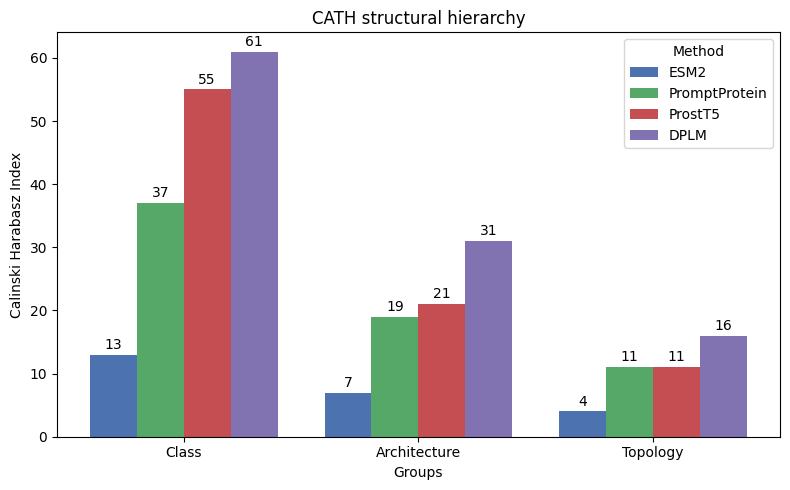

In [755]:
import matplotlib.pyplot as plt
import numpy as np

# === Data ===
groups = ["Class", "Architecture", "Topology"]
esm2       = [13, 7, 4]
promptprot = [37, 19, 11]
prostt5     = [55, 21, 11]
dplm       = [61, 31, 16]

methods = ["ESM2", "PromptProtein", "ProstT5", "DPLM"]
all_methods = [esm2, promptprot, prostt5, dplm]

# === Plot settings ===
x = np.arange(len(groups))        # positions for groups
width = 0.2                       # width of each bar

fig, ax = plt.subplots(figsize=(8, 5))

colors=["#4C72B0", "#55A868", "#C44E52", "#8172B2"]
# Plot bars for each method, shifted along x
ax.bar(x - 1.5*width, esm2, width, label="ESM2", color=colors[0])
ax.bar(x - 0.5*width, promptprot, width, label="PromptProtein", color=colors[1])
ax.bar(x + 0.5*width, prostt5, width, label="ProstT5", color=colors[2])
ax.bar(x + 1.5*width, dplm, width, label="DPLM", color=colors[3])

# === Formatting ===
ax.set_ylabel("Calinski Harabasz Index")
ax.set_xlabel("Groups")
ax.set_title("CATH structural hierarchy")
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend(title="Method")

# Optional: add numeric labels
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', padding=2)

plt.tight_layout()
plt.show()
# If running in non-interactive mode, use:
# plt.savefig("grouped_barplot.png", dpi=300, bbox_inches="tight")


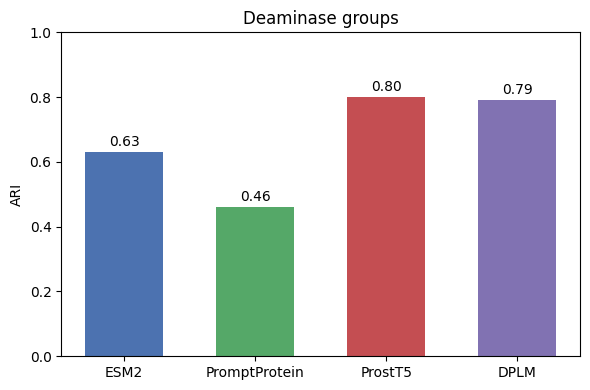

In [751]:
import matplotlib.pyplot as plt

# === Data ===
methods = ["ESM2", "PromptProtein", "ProstT5", "DPLM"]
values = [0.63, 0.46, 0.80, 0.79]

# === Plot ===
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, values, color=["#4C72B0", "#55A868", "#C44E52", "#8172B2"], width=0.6)

# Add labels and title
plt.ylabel("ARI")
plt.title("Deaminase groups")

# Add numerical value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Optional: tidy look
plt.ylim(0, 1.0)
plt.tight_layout()

plt.show()
# If running in non-interactive mode, use:
# plt.savefig("method_barplot.png", dpi=300, bbox_inches="tight")


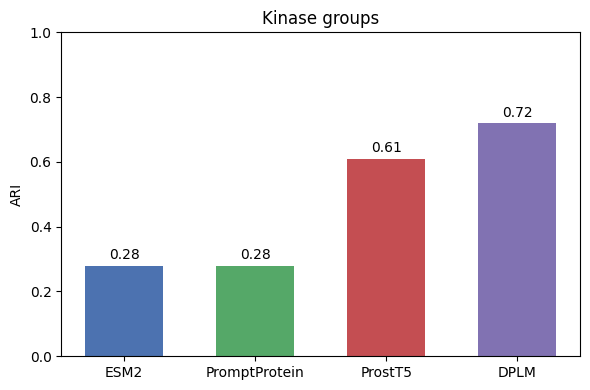

In [752]:
import matplotlib.pyplot as plt

# === Data ===
methods = ["ESM2", "PromptProtein", "ProstT5", "DPLM"]
values = [0.28, 0.28, 0.61, 0.72]

# === Plot ===
plt.figure(figsize=(6, 4))
bars = plt.bar(methods, values, color=["#4C72B0", "#55A868", "#C44E52", "#8172B2"], width=0.6)

# Add labels and title
plt.ylabel("ARI")
plt.title("Kinase groups")

# Add numerical value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Optional: tidy look
plt.ylim(0, 1.0)
plt.tight_layout()

plt.show()

In [95]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm


import argparse
import torch
import esm
import esm_adapterH
import yaml
from utils.utils import load_configs
from collections import OrderedDict
from peft import LoraConfig, get_peft_model
# ----------------------------
# Setup
# ----------------------------



# ----------------------------
# Define your embedding function
# ----------------------------

def embed_sequence(mt_seq, wt_seq,batch_converter, args):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time

    score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    return np.log(np.mean(score))*-1
    """
    Replace this with your actual embedding model.
    This dummy version returns a fixed-length random vector.
    """
    np.random.seed(hash(seq) % 2**32)  # deterministic randomness per sequence
    return np.random.rand(128)

# ----------------------------
# Mutate sequence + embed
# ----------------------------

def apply_mutation(seq, mutation):
    """
    Apply mutation like 'Q2C' on seq.
    """
    ref = mutation[0]
    pos = int(mutation[1:-1]) - 1  # convert to 0-index
    alt = mutation[-1]
    assert seq[pos] == ref, f"Reference mismatch at pos {pos+1}: expected {ref}, got {seq[pos]}"
    mutated = seq[:pos] + alt + seq[pos+1:]
    return mutated

def load_checkpoints(model,checkpoint_path):
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            if  any('adapter' in name for name, _ in model.named_modules()):
                if np.sum(["adapter_layer_dict" in key for key in checkpoint[
                    'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                        if "adapter_layer_dict" not in key:
                            new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
                            new_ordered_dict[new_key] = value
                        else:
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
                else:
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
            elif  any('lora' in name for name, _ in model.named_modules()):
                #this model does not contain esm2
                new_ordered_dict = OrderedDict()
                for key, value in checkpoint['state_dict1'].items():
                        print(key)
                        key = key.replace("esm2.","")
                        new_ordered_dict[key] = value
                
                model.load_state_dict(new_ordered_dict, strict=False)
            
            print("checkpoints were loaded from " + checkpoint_path)
        else:
            print("checkpoints not exist "+ checkpoint_path)

def load_model(args):
    if args.model_type=="s-plm":
        with open(args.config_path) as file:
            config_file = yaml.full_load(file)
            configs = load_configs(config_file, args=None)
        if configs.model.esm_encoder.adapter_h.enable:
            model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
        elif configs.model.esm_encoder.lora.enable:
            model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            lora_targets =  ["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj","self_attn.out_proj"]
            target_modules=[]
            if configs.model.esm_encoder.lora.esm_num_end_lora > 0:
                start_layer_idx = np.max([model.num_layers - configs.model.esm_encoder.lora.esm_num_end_lora, 0])
                for idx in range(start_layer_idx, model.num_layers):
                    for layer_name in lora_targets:
                        target_modules.append(f"layers.{idx}.{layer_name}")
                
            peft_config = LoraConfig(
                inference_mode=False,
                r=configs.model.esm_encoder.lora.r,
                lora_alpha=configs.model.esm_encoder.lora.alpha,
                target_modules=target_modules,
                lora_dropout=configs.model.esm_encoder.lora.dropout,
                bias="none",
                # modules_to_save=modules_to_save
            )
            peft_model = get_peft_model(model, peft_config)
        
        # inference for each model
        # model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)/
        load_checkpoints(model,args.model_location)
    elif args.model_type=="ESM2":
        #if use ESM2
        model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
    
    return model,alphabet

# Generate embeddings for each mutant sequence

def embed_sequence(mt_seq, wt_seq,batch_converter, args, pos):
    data = [
        ("protein1", mt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        mt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    mt_representation = mt_representation.squeeze(0) #only one sequence a time
    data = [
        ("protein1", wt_seq),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    wt_representation = wt_representation.squeeze(0) #only one sequence a time

    # score = np.linalg.norm((mt_representation-wt_representation).to('cpu').detach().numpy(),axis=1)
    # return np.log(np.mean(score))*-1

    # return mt_representation[0]-wt_representation[0]
    score = (mt_representation-wt_representation).to('cpu').detach().numpy()
    return np.mean(score, axis=0)




df_S9028 = pd.read_csv("./evaluate/S9028.csv")
df_S552 = pd.read_csv("./evaluate/S552.csv")
pdb2seq_S9028 = {}
pdb2seq_S552 = {}
with open("./evaluate/S552_seq.txt", "r") as file:
    line=file.readline().strip()
    while line:
        pdb=line.split('\t')[0]
        seq=line.split('\t')[1]
        pdb2seq_S552[pdb]=seq
        line=file.readline().strip()

with open("./evaluate/S9028_seq.txt", "r") as file:
    line=file.readline().strip()
    while line:
        pdb=line.split('\t')[0]
        seq=line.split('\t')[1]
        pdb2seq_S9028[pdb]=seq
        line=file.readline().strip()

df_S9028

pdb_mut_chain   pH  TEMP   ddG     type  ddG_DDMut
0     1A43_C218S_A  7.3  25.0 -3.70  Forward      -3.64
1     1A43_E159D_A  7.3  25.0 -4.55  Forward      -1.50
2     1A43_G156A_A  7.3  25.0 -2.40  Forward      -1.00
3     1A43_R167A_A  7.3  25.0 -4.55  Forward      -0.83
4     1A43_W184A_A  7.3  25.0 -0.70  Forward      -1.24
...            ...  ...   ...   ...      ...        ...
9023   3MBP_A48P_A  7.4  63.0 -0.50  Reverse       0.10
9024   3MBP_S48P_A  7.4  63.0 -0.30  Reverse       0.15
9025  3MBP_I345T_A  7.6  25.0 -0.70  Reverse      -0.47
9026    3MBP_G8V_A  7.6  25.0  1.10  Reverse       1.84
9027  3MBP_D283Y_A  7.6  25.0  3.20  Reverse       2.16

[9028 rows x 6 columns]

In [98]:
parser = argparse.ArgumentParser(description="DMS regression tasks")
parser.add_argument('--model_type', type=str, required=False, default="s-plm")
parser.add_argument('--config_path', type=str, required=False, default="../results/vivit_2/config.yaml")
parser.add_argument('--model_location', type=str, required=False, 
                    default="../results/vivit_2/checkpoints/checkpoint_best_val_dms_corr.pth")

parser.add_argument('--reverse', action='store_true')

args = parser.parse_args(args=['--model_type', "s-plm", #"s-plm" "ESM2"
                               '--config_path', "./results/vivit_3/config_vivit3.yaml",
                               '--model_location', "./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth",
                               '--reverse']
                               )

args.model, args.alphabet = load_model(args)
batch_converter = args.alphabet.get_batch_converter()

checkpoints were loaded from ./results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth
Transferred model to GPU


In [101]:
###################
X_train = []
y_train = []
pos_list=[]
print("Generating embeddings...")
for _, row in tqdm(df_S9028.iterrows(), total=len(df_S9028)):
    pdb=row['pdb_mut_chain'].split('_')[0]
    if not pdb in pdb2seq_S9028.keys():
        continue
    mut=row['pdb_mut_chain'].split('_')[1]
    effect = row['ddG']
    if pd.isna(effect) or effect == '':
        continue
    SEQ=pdb2seq_S9028[pdb]
    print(row['pdb_mut_chain'])
    try:
        mutated_seq = apply_mutation(SEQ, mut)
    except:
        print(pdb)
        continue
    if mutated_seq==SEQ:
        continue
    # print(mutated_seq)
    # print(SEQ)
    pos = int(mut[1:-1]) - 1
    embedding = embed_sequence(mutated_seq, SEQ, batch_converter, args, pos)
    pos_list.append(pos)
    X_train.append(embedding)
    y_train.append(effect)

# X_test = []
# y_test = []
# pos_list=[]
# print("Generating embeddings...")
# for _, row in tqdm(df_S552.iterrows(), total=len(df_S552)):
#     pdb=row['pdb_mut_chain'].split('_')[0]
#     if not pdb in pdb2seq_S552.keys():
#         continue
#     mut=row['pdb_mut_chain'].split('_')[1]
#     effect = row['ddG']
#     if pd.isna(effect) or effect == '':
#         continue
#     SEQ=pdb2seq_S552[pdb]
#     mutated_seq = apply_mutation(SEQ, mut)
#     if mutated_seq==SEQ:
#         continue
#     pos = int(mut[1:-1]) - 1
#     embedding = embed_sequence(mutated_seq, SEQ, batch_converter, args, pos)
#     pos_list.append(pos)
#     X_test.append(embedding)
#     y_test.append(effect)

Generating embeddings...


  0%|          | 0/9028 [00:00<?, ?it/s]

1A43_C218S_A
1A43
1A43_E159D_A
1A43
1A43_G156A_A
1A43
1A43_R167A_A
1A43
1A43_W184A_A
1A43
1A5E_L121R_A


  0%|          | 6/9028 [00:00<09:01, 16.68it/s]

1A5E_L37S_A
1A5E_W15D_A


  0%|          | 8/9028 [00:00<13:30, 11.13it/s]

1AAR_F45W_A
1AAR_H68E_A


  0%|          | 10/9028 [00:01<23:09,  6.49it/s]

1AAR_H68Q_A


  0%|          | 11/9028 [00:01<26:47,  5.61it/s]

1AAR_K27Q_A


  0%|          | 12/9028 [00:01<30:05,  4.99it/s]

1AAR_K29N_A


  0%|          | 13/9028 [00:02<33:03,  4.54it/s]

1AAR_K29Q_A


  0%|          | 14/9028 [00:02<35:37,  4.22it/s]

1AAR_K6E_A


  0%|          | 15/9028 [00:02<37:39,  3.99it/s]

1AAR_K6Q_A


  0%|          | 16/9028 [00:02<39:04,  3.84it/s]

1AAR_R42E_A


  0%|          | 17/9028 [00:03<40:11,  3.74it/s]

1AAR_R72Q_A


  0%|          | 19/9028 [00:03<35:57,  4.17it/s]

1ACB_L27A_I
1ACB_V14A_I


  0%|          | 21/9028 [00:04<29:15,  5.13it/s]

1ACB_V18A_I
1ACB_V54A_I


  0%|          | 23/9028 [00:04<24:23,  6.15it/s]

1ACB_V62A_I
1AEP_A137K_A
1AEP
1AEP_L14K_A
1AEP
1AEP_T141A_A
1AEP
1AEP_T28A_A
1AEP
1AG2_F175W_A
1AG2
1AJ3_A102G_A
1AJ3
1AJ3_A104G_A
1AJ3
1AJ3_A54G_A
1AJ3
1AJ3_A58G_A
1AJ3
1AJ3_A89G_A
1AJ3
1AJ3_D17A_A
1AJ3
1AJ3_D17G_A
1AJ3
1AJ3_D68A_A
1AJ3
1AJ3_D68G_A
1AJ3
1AJ3_D93A_A
1AJ3
1AJ3_D93G_A
1AJ3
1AJ3_E25A_A
1AJ3
1AJ3_E25G_A
1AJ3
1AJ3_F12A_A
1AJ3
1AJ3_F12L_A
1AJ3
1AJ3_F91A_A
1AJ3
1AJ3_F91L_A
1AJ3
1AJ3_H49A_A
1AJ3
1AJ3_H59A_A
1AJ3
1AJ3_I23A_A
1AJ3
1AJ3_I23V_A
1AJ3
1AJ3_I63A_A
1AJ3
1AJ3_I63V_A
1AJ3
1AJ3_I84A_A
1AJ3
1AJ3_I84V_A
1AJ3
1AJ3_K26A_A
1AJ3
1AJ3_K47A_A
1AJ3
1AJ3_K47G_A
1AJ3
1AJ3_K72A_A
1AJ3
1AJ3_K72G_A
1AJ3
1AJ3_K96A_A
1AJ3
1AJ3_K96G_A
1AJ3
1AJ3_L45A_A
1AJ3
1AJ3_L52A_A
1AJ3
1AJ3_L56A_A


  1%|          | 63/9028 [00:05<06:04, 24.60it/s]

1AJ3_L73A_A
1AJ3
1AJ3_L88A_A
1AJ3
1AJ3_L98A_A
1AJ3
1AJ3_M16A_A
1AJ3
1AJ3_N44A_A
1AJ3
1AJ3_N44G_A
1AJ3
1AJ3_P61A_A
1AJ3
1AJ3_Q100A_A
1AJ3
1AJ3_Q100G_A
1AJ3
1AJ3_Q107A_A
1AJ3
1AJ3_Q107G_A
1AJ3
1AJ3_Q107L_A
1AJ3
1AJ3_Q64A_A
1AJ3
1AJ3_Q64G_A
1AJ3
1AJ3_Q86A_A


  1%|          | 78/9028 [00:06<08:32, 17.47it/s]

1AJ3_Q86G_A


  1%|          | 80/9028 [00:08<14:15, 10.46it/s]

1AJ3_R105A_A
1AJ3
1AJ3_R14A_A
1AJ3
1AJ3_R14G_A
1AJ3
1AJ3_R51A_A


  1%|          | 83/9028 [00:09<20:33,  7.25it/s]

1AJ3_R51G_A


  1%|          | 84/9028 [00:11<29:51,  4.99it/s]

1AJ3_S21A_A
1AJ3
1AJ3_S21G_A
1AJ3
1AJ3_T40A_A
1AJ3
1AJ3_T40G_A
1AJ3
1AJ3_V30A_A
1AJ3
1AJ3_V42A_A
1AJ3
1AJ3_V66A_A
1AJ3
1AJ3_W22Y_A
1AJ3
1AJ3_W95F_A
1AJ3
1AKK_L94A_A
1AKK
1AKY_I213F_A
1AKY
1AKY_N169D_A
1AKY
1AKY_Q48E_A
1AKY
1AKY_T110H_A
1AKY
1AKY_T77H_A
1AKY
1AKY_V8I_A
1AKY
1AM7_H31D_A


  1%|          | 101/9028 [00:11<14:22, 10.35it/s]

1AM7_H31N_A
1AM7_H48N_A


  1%|‚ñè         | 118/9028 [00:11<08:47, 16.88it/s]

1AMQ_C191A_A
1AMQ
1AMQ_C191F_A
1AMQ
1AMQ_C191G_A
1AMQ
1AMQ_C191R_A
1AMQ
1AMQ_C191S_A
1AMQ
1AMQ_C191W_A
1AMQ
1AMQ_C191Y_A
1AMQ
1AMQ_C192A_A
1AMQ
1AMQ_C192S_A
1AMQ
1AMQ_C270A_A
1AMQ
1AMQ_C401A_A
1AMQ
1AMQ_C401S_A
1AMQ
1AMQ_C82A_A
1AMQ
1AMQ_C82S_A
1AMQ
1ANK_D84H_A
1ANK_F86L_A
1ANK_G85V_A
1AON_I3C_U
1AON_I3W_U
1AON_I48W_U


  1%|‚ñè         | 127/9028 [00:12<10:03, 14.75it/s]

1AON_V95C_U
1APS_A30G_A
1APS
1APS_E29D_A
1APS
1APS_E83D_A
1APS
1APS_F22L_A
1APS
1APS_F94L_A
1APS
1APS_G45A_A
1APS
1APS_I75V_A
1APS
1APS_I86V_A
1APS
1APS_L65V_A
1APS
1APS_L89A_A
1APS
1APS_M61A_A
1APS
1APS_P54A_A
1APS
1APS_P71A_A
1APS
1APS_T42A_A
1APS
1APS_T78S_A
1APS
1APS_V13A_A
1APS
1APS_V17A_A
1APS
1APS_V20A_A
1APS
1APS_V35A_A
1APS
1APS_V36A_A


  2%|‚ñè         | 154/9028 [00:12<04:34, 32.38it/s]

1APS_V39A_A
1APS
1APS_V47A_A
1APS
1APS_V51A_A
1APS
1APS_W38F_A
1APS
1APS_W64A_A
1APS
1APS_Y11F_A
1APS
1APS_Y11I_A
1APS
1APS_Y25A_A
1APS
1AQH_Q58C_A
1AQH
1ARR_D20A_A
1ARR_D20G_A
1ARR_E17A_A
1ARR_E17G_A
1ARR_E27A_A
1ARR_E27G_A


  2%|‚ñè         | 160/9028 [00:13<07:58, 18.52it/s]

1ARR_E28A_A
1ARR_E28G_A
1ARR_E43A_A
1ARR_E48G_A
1ARR_F10A_A
1ARR_G3A_A


  2%|‚ñè         | 165/9028 [00:14<10:51, 13.60it/s]

1ARR_G49A_A
1ARR_G52A_A
1ARR_I51A_A
1ARR_K24A_A


  2%|‚ñè         | 169/9028 [00:15<13:00, 11.34it/s]

1ARR_K24G_A
1ARR_K24T_A


  2%|‚ñè         | 172/9028 [00:15<14:23, 10.26it/s]

1ARR_K2A_A
1ARR_K46A_A


  2%|‚ñè         | 174/9028 [00:15<15:33,  9.48it/s]

1ARR_K46G_A
1ARR_K47A_A


  2%|‚ñè         | 176/9028 [00:16<17:00,  8.68it/s]

1ARR_K47G_A
1ARR_K6A_A


  2%|‚ñè         | 178/9028 [00:16<18:51,  7.82it/s]

1ARR_L19Q_A
1ARR_L21A_A
1ARR_M1A_A


  2%|‚ñè         | 181/9028 [00:17<19:36,  7.52it/s]

1ARR_M42A_A
1ARR_M4A_A


  2%|‚ñè         | 183/9028 [00:17<20:04,  7.34it/s]

1ARR_M7A_A
1ARR_N11A_A


  2%|‚ñè         | 185/9028 [00:17<20:44,  7.10it/s]

1ARR_N29A_A
1ARR_N34A_A


  2%|‚ñè         | 187/9028 [00:18<21:46,  6.76it/s]

1ARR_N34G_A
1ARR_P15A_A


  2%|‚ñè         | 189/9028 [00:18<23:09,  6.36it/s]

1ARR_P8A_A
1ARR_Q39A_A


  2%|‚ñè         | 191/9028 [00:18<23:19,  6.32it/s]

1ARR_Q39G_A
1ARR_Q9A_A


  2%|‚ñè         | 193/9028 [00:19<23:56,  6.15it/s]

1ARR_Q9G_A
1ARR_R13A_A


  2%|‚ñè         | 195/9028 [00:19<22:20,  6.59it/s]

1ARR_R13G_A
1ARR_R16A_A


  2%|‚ñè         | 197/9028 [00:19<20:48,  7.07it/s]

1ARR_R16G_A
1ARR_R23A_A


  2%|‚ñè         | 199/9028 [00:19<22:18,  6.59it/s]

1ARR_R23G_A
1ARR_R31A_A


  2%|‚ñè         | 201/9028 [00:20<22:33,  6.52it/s]

1ARR_R40A_A
1ARR_R50A_A


  2%|‚ñè         | 203/9028 [00:20<21:51,  6.73it/s]

1ARR_S35A_A
1ARR_S35G_A


  2%|‚ñè         | 205/9028 [00:20<22:04,  6.66it/s]

1ARR_S5A_A
1ARR_W14A_A


  2%|‚ñè         | 207/9028 [00:21<22:31,  6.53it/s]

1ARR_Y38A_A
1AXB_E104K_A
1AXB
1AXB_G238S_A
1AXB
1AXB_R164H_A
1AXB
1AXB_R164S_A
1AXB
1AXB_S235A_A
1AXB
1AYE_E5G_A
1AYE
1AYE_K24A_A
1AYE
1AYE_V59A_A
1AYE
1AYE_V61A_A
1AYE
1AYF_C95S_A
1AYF
1AYF_D15E_A


  3%|‚ñé         | 229/9028 [00:21<03:54, 37.47it/s]

1AYF_D76E_A
1AYF
1AYF_H56Q_A
1AYF
1AYF_H56R_A
1AYF
1AYF_H56T_A
1AYF
1AYF_T54A_A
1AYF
1AYF_T54S_A
1AYF
1AYF_Y82F_A
1AYF
1AYF_Y82L_A
1AYF
1AYF_Y82S_A
1AYF
1AYF_Y82W_A
1AYF
1AZP_A44G_A
1AZP_A50G_A
1AZP_D35A_A
1AZP_D56G_A
1AZP_E12A_A


  3%|‚ñé         | 233/9028 [00:22<08:38, 16.97it/s]

1AZP_F32A_A
1AZP_K7A_A


  3%|‚ñé         | 236/9028 [00:22<11:07, 13.16it/s]

1AZP_L55A_A
1AZP_L58A_A
1AZP_R25A_A
1AZP_R42A_A


  3%|‚ñé         | 239/9028 [00:22<12:58, 11.29it/s]

1AZP_S18A_A
1AZP_S31A_A


  3%|‚ñé         | 241/9028 [00:23<14:09, 10.34it/s]

1AZP_S46A_A
1AZP_T17A_A


  3%|‚ñé         | 243/9028 [00:23<15:27,  9.47it/s]

1AZP_T40A_A
1AZP_V15A_A


  3%|‚ñé         | 245/9028 [00:23<16:37,  8.80it/s]

1AZP_V23A_A
1AZP_V30A_A


  3%|‚ñé         | 248/9028 [00:24<17:58,  8.14it/s]

1AZP_V30I_A
1AZP_V45A_A


  3%|‚ñé         | 250/9028 [00:24<18:07,  8.07it/s]

1AZP_V4A_A
1AZP_W24A_A


  3%|‚ñé         | 279/9028 [00:24<02:29, 58.35it/s]

1B5M_P65A_A
1B5M
1B5M_R15H_A
1B5M
1B8E_W19Y_A
1B8E
1BCX_S100C_A
1BCX
1BCX_V98C_A
1BCX
1BLC_D179N_A
1BLC
1BNI_A32P_A
1BNI
1BNI_D12A_A
1BNI
1BNI_D12G_A
1BNI
1BNI_D22M_A
1BNI
1BNI_D54A_A
1BNI
1BNI_D54N_A
1BNI
1BNI_D75N_A
1BNI
1BNI_D8A_A
1BNI
1BNI_E29G_A
1BNI
1BNI_E73F_A
1BNI
1BNI_E73Q_A
1BNI
1BNI_E73W_A
1BNI
1BNI_F7L_A
1BNI
1BNI_G34H_A
1BNI
1BNI_G52A_A
1BNI
1BNI_G53A_A
1BNI
1BNI_G53V_A
1BNI
1BNI_H102A_A
1BNI
1BNI_H18G_A
1BNI
1BNI_H18K_A
1BNI
1BNI_I109V_A
1BNI
1BNI_I51V_A
1BNI_I76T_A
1BNI
1BNI_I88A_A
1BNI
1BNI_I88V_A
1BNI
1BNI_I96A_A
1BNI
1BNI_I96V_A
1BNI
1BNI_K19A_A
1BNI
1BNI_K19R_A
1BNI
1BNI_K27A_A
1BNI
1BNI_K27G_A
1BNI
1BNI_K62R_A
1BNI
1BNI_L14A_A
1BNI
1BNI_L42T_A
1BNI
1BNI_L42V_A
1BNI
1BNI_L89V_A


  4%|‚ñç         | 371/9028 [00:25<00:43, 197.74it/s]

1BNI_Q31S_A
1BNI
1BNI_R59A_A
1BNI
1BNI_R69M_A
1BNI
1BNI_R83Q_A
1BNI
1BNI_S38A_A
1BNI
1BNI_S57A_A
1BNI
1BNI_S91A_A
1BNI
1BNI_S92A_A
1BNI
1BNI_T16R_A
1BNI
1BNI_T16S_A
1BNI
1BNI_T26A_A
1BNI
1BNI_T26E_A
1BNI
1BNI_T26G_A
1BNI
1BNI_T26H_A
1BNI
1BNI_T26N_A
1BNI
1BNI_T26Q_A
1BNI
1BNI_T26S_A
1BNI
1BNI_T26V_A
1BNI
1BNI_T6A_A
1BNI
1BNI_T6D_A
1BNI
1BNI_T6E_A
1BNI
1BNI_T6G_A
1BNI
1BNI_T6H_A
1BNI
1BNI_T6N_A
1BNI
1BNI_T6P_A
1BNI
1BNI_T6Q_A
1BNI
1BNI_T6S_A
1BNI
1BNI_W94F_A
1BNI
1BNI_W94L_A
1BNI
1BNI_W94Y_A
1BNI
1BNI_Y13A_A
1BNI
1BNI_Y17A_A
1BNI
1BNI_Y17G_A
1BNI
1BNI_Y78F_A
1BNI
1BOY_R200W_A
1BOY
1BP2_F106A_A
1BP2
1BP2_F106I_A
1BP2
1BP2_F106Y_A
1BP2
1BP2_F22A_A
1BP2
1BP2_F22Y_A
1BP2
1BP2_H48A_A
1BP2
1BP2_H48N_A
1BP2
1BP2_H48Q_A
1BP2
1BPI_A16T_A
1BPI
1BPI_A16V_A
1BPI
1BPI_C30A_A
1BPI
1BPI_C30G_A
1BPI
1BPI_C30S_A
1BPI
1BPI_C30T_A
1BPI
1BPI_C30V_A
1BPI
1BPI_D3A_A
1BPI
1BPI_D50A_A
1BPI
1BPI_E49A_A
1BPI
1BPI_E7A_A
1BPI
1BPI_F22A_A
1BPI
1BPI_F33I_A
1BPI
1BPI_F45A_A
1BPI
1BPI_F4A_A
1BPI
1BPI_F4L_A
1BPI
1BPI_G

  5%|‚ñç         | 411/9028 [00:25<00:51, 166.64it/s]

1BPI_R17A_A
1BPI
1BPI_R1A_A
1BPI
1BPI_R20A_A
1BPI
1BPI_R39A_A
1BPI
1BPI_R42A_A
1BPI
1BPI_R53A_A
1BPI
1BPI_S47A_A
1BPI
1BPI_T11A_A
1BPI
1BPI_T32A_A
1BPI
1BPI_T54A_A
1BPI
1BPI_V34A_A
1BPI
1BPI_Y10A_A
1BPI
1BPI_Y10L_A
1BPI
1BPI_Y21A_A
1BPI
1BPI_Y21L_A
1BPI
1BPI_Y23A_A
1BPI
1BPI_Y35A_A
1BPI
1BPI_Y35D_A
1BPI
1BPI_Y35F_A
1BPI
1BPI_Y35G_A
1BPI
1BPI_Y35L_A
1BPI
1BPI_Y35N_A
1BPI
1BRF_A1K_A
1BRF
1BTA_C40A_A
1BTA
1BTA_C82A_A
1BTA
1BTA_E57K_A
1BTA
1BTA_K21A_A
1BTA
1BTA_K21Q_A
1BTA
1BTA_K22Q_A
1BTA_K60E_A
1BTA
1BTA_K60L_A
1BTA
1BTA_K78A_A
1BTA
1BTA_K78Q_A
1BTA
1BTA_R75L_A
1BTA
1BTA_R75Q_A
1BTA
1BVC_A125L_A
1BVC
1BVC_A130K_A
1BVC
1BVC_A130L_A
1BVC
1BVC_A144L_A


  5%|‚ñç         | 445/9028 [00:25<01:01, 140.30it/s]

1BVC_A15L_A
1BVC
1BVC_D44A_A
1BVC
1BVC_D60A_A
1BVC
1BVC_E109A_A
1BVC
1BVC_E109G_A
1BVC
1BVC_E18A_A
1BVC
1BVC_E4A_A
1BVC
1BVC_F106A_A
1BVC
1BVC_F123A_A
1BVC
1BVC_F123K_A
1BVC
1BVC_F123T_A
1BVC
1BVC_G129A_A
1BVC
1BVC_G23A_A
1BVC
1BVC_G65A_A
1BVC
1BVC_H113Q_A
1BVC
1BVC_H116A_A
1BVC
1BVC_H119F_A
1BVC
1BVC_H24V_A
1BVC
1BVC_H36Q_A
1BVC
1BVC_H48Q_A
1BVC
1BVC_H64Q_A
1BVC
1BVC_H81Q_A
1BVC
1BVC_H82Q_A
1BVC_H93G_A
1BVC
1BVC_I111L_A
1BVC
1BVC_I111M_A
1BVC
1BVC_I142A_A
1BVC
1BVC_I142L_A
1BVC
1BVC_I142M_A
1BVC
1BVC_I142V_A
1BVC
1BVC_I28L_A
1BVC
1BVC_I28M_A
1BVC
1BVC_I28V_A
1BVC
1BVC_I30A_A
1BVC
1BVC_K140A_A
1BVC
1BVC_K56A_A
1BVC
1BVC_K77A_A
1BVC
1BVC_L11A_A
1BVC
1BVC_L135I_A
1BVC
1BVC_L135M_A
1BVC
1BVC_L135V_A
1BVC
1BVC_L137A_A
1BVC
1BVC_L149A_A
1BVC
1BVC_L29A_A
1BVC
1BVC_L29I_A
1BVC
1BVC_L29M_A
1BVC
1BVC_L29V_A
1BVC
1BVC_L32A_A
1BVC
1BVC_L49I_A
1BVC
1BVC_L69I_A
1BVC
1BVC_L69M_A
1BVC
1BVC_L69V_A
1BVC
1BVC_L9A_A
1BVC
1BVC_P88A_A
1BVC
1BVC_Q8A_A
1BVC
1BVC_Q8G_A
1BVC
1BVC_S117A_A
1BVC
1BVC_T51A_A
1BVC


  5%|‚ñå         | 492/9028 [00:25<00:49, 171.91it/s]

1C52_M69H_A
1C8C_F32Y_A
1C8C_I30V_A
1C8C_W24A_A
1C9O_E12K_A
1C9O_E21A_A
1C9O_E21K_A
1C9O_E36K_A
1C9O_E46A_A
1C9O_E46K_A
1C9O_E50K_A
1C9O_E50W_A
1C9O_F38W_A
1C9O_G23Q_A
1C9O_H29E_A
1C9O_L66E_A


  6%|‚ñå         | 509/9028 [00:28<04:55, 28.80it/s] 

1C9O_N11S_A
1C9O_N55K_A
1C9O_Q2L_A
1C9O_Q53E_A
1C9O_R3A_A
1C9O_R3E_A
1C9O_R3K_A
1C9O_R3L_A
1C9O_R56E_A
1C9O_S24D_A
1C9O_T31S_A
1C9O_V64T_A


  6%|‚ñå         | 521/9028 [00:30<07:40, 18.48it/s]

1C9O_Y15F_A
1CAH_C206S_A
1CAH
1CAH_I256C_A
1CAH
1CAH_L60C_A
1CAH_S56C_A
1CAH_V68C_A
1CAH_W123C_A
1CAH_W5F_A
1CEY_A101G_A
1CEY_A113G_A


  6%|‚ñå         | 530/9028 [00:31<08:56, 15.84it/s]

1CEY_A114G_A
1CEY_A48G_A
1CEY_A74G_A
1CEY_A77G_A
1CEY_A80G_A
1CEY_A88G_A


  6%|‚ñå         | 537/9028 [00:32<10:29, 13.48it/s]

1CEY_A90G_A
1CEY_A99G_A
1CEY_D12A_A
1CEY_D13A_A
1CEY_D57A_A
1CEY_F14N_A


  6%|‚ñå         | 547/9028 [00:33<11:01, 12.82it/s]

1CHK_W101F_A
1CHK
1CHK_W227F_A
1CHK
1CHK_W28F_A
1CHK
1CLW_G435D_A
1CLW
1CSP_A46E_A
1CSP_A46K_A
1CSP_A46L_A


  6%|‚ñå         | 549/9028 [00:33<08:37, 16.38it/s]

1CSP_D24K_A


KeyboardInterrupt: 

In [ ]:




X = []
y = []
pos_list=[]
print("Generating embeddings...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    mut = row['mutation']
    effect = row['effect']
    if pd.isna(effect) or effect == '':
        continue
    mutated_seq = apply_mutation(SEQ, mut)
    if mutated_seq==SEQ:
        continue
    pos = int(mut[1:-1]) - 1
    embedding = embed_sequence(mutated_seq, SEQ, batch_converter, args, pos)
    pos_list.append(pos)
    X.append(embedding)
    y.append(effect)